In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
        ''' 
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1
    '''
        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        '''

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)
    '''
    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.nn.init as init\nfrom torch.nn import Parameter\n\n__all__ = [\'resnet32\', \'NormedLinear\']\n\ndef _weights_init(m):\n    classname = m.__class__.__name__\n    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):\n        init.kaiming_normal_(m.weight)\n\nclass NormedLinear(nn.Module):\n\n    def __init__(self, in_features, out_features):\n        super(NormedLinear, self).__init__()\n        self.weight = Parameter(torch.Tensor(in_features, out_features))\n        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)\n\n    def forward(self, x):\n        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))\n        return out\n\nclass LambdaLayer(nn.Module):\n\n    def __init__(self, lambd):\n        super(LambdaLayer, self).__init__()\n        self.lambd = lambd\n\n    def forward(self, x):\n        return self.lambd(x)\n\n\nclass BasicBlock(nn.Module):\n    expansion = 1\n

net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    if args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    '''
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    '''
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [35]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=False, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ride', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list1=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        
        #code for weight L1 norm
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ride':
                trans_weight1=model_weights['linears.0.weight'].transpose(0, 1)
                trans_weight2=model_weights['linears.1.weight'].transpose(0, 1)
                trans_weight3=model_weights['linears.2.weight'].transpose(0, 1)
                
                class_l1_norm1 = torch.abs(trans_weight1[class_label]).sum()
                class_l1_norm2 = torch.abs(trans_weight2[class_label]).sum()
                class_l1_norm3 = torch.abs(trans_weight3[class_label]).sum()

                class_l1_norm = class_l1_norm1 + class_l1_norm2 + class_l1_norm3
                
            elif args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
                linear_weight = trans_weight[class_label]
                class_l1_norm = torch.abs(linear_weight).sum()
            else:
                trans_weight = model_weights['linear.weight']
                linear_weight = trans_weight[class_label]
                class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list1.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        #endu
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()
    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.5
    > cutout      : False
    > cmo         : False
    > posthoc_la  : False
    > cuda        : False
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 10
    > accept_rate : 0.6
    > verbose     : False
    > use_norm    : False
    > out         : /kaggle/working/log3
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : None
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ride
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.79M


/tmp/ipykernel_1840/2298205333.py:97: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  final_output = torch.where(index, x_m, x)
---> Epoch: [1 | 200]
    > [Train]	Loss:	31.8801
    > [Test ]	Loss:	5.5722	Acc:	5.5400
    > [Stats]	Many:	0.1446	Medium:	0.0137	Few:	0.0000
    > [Best ]	Acc:	5.5400	Many:	14.4571	Medium:	1.3714	Few:	0.0000
    > [Param]	LR:	0.02000000


2.9233015779622535


---> Epoch: [2 | 200]
    > [Train]	Loss:	29.7277
    > [Test ]	Loss:	5.6810	Acc:	6.8600
    > [Stats]	Many:	0.1917	Medium:	0.0043	Few:	0.0000
    > [Best ]	Acc:	6.8600	Many:	19.1714	Medium:	0.4286	Few:	0.0000
    > [Param]	LR:	0.04000000


5.031301948596366


---> Epoch: [3 | 200]
    > [Train]	Loss:	29.0659
    > [Test ]	Loss:	5.5151	Acc:	8.6400
    > [Stats]	Many:	0.2317	Medium:	0.0151	Few:	0.0000
    > [Best ]	Acc:	8.6400	Many:	23.1714	Medium:	1.5143	Few:	0.0000
    > [Param]	LR:	0.06000000


7.5654318566466285


---> Epoch: [4 | 200]
    > [Train]	Loss:	28.2297
    > [Test ]	Loss:	5.2919	Acc:	10.4400
    > [Stats]	Many:	0.2840	Medium:	0.0143	Few:	0.0000
    > [Best ]	Acc:	10.4400	Many:	28.4000	Medium:	1.4286	Few:	0.0000
    > [Param]	LR:	0.08000000


9.704695166064162


---> Epoch: [5 | 200]
    > [Train]	Loss:	27.3601
    > [Test ]	Loss:	5.3933	Acc:	10.4600
    > [Stats]	Many:	0.2669	Medium:	0.0300	Few:	0.0023
    > [Best ]	Acc:	10.4600	Many:	26.6857	Medium:	3.0000	Few:	0.2333
    > [Param]	LR:	0.10000000


11.340183952383676


---> Epoch: [6 | 200]
    > [Train]	Loss:	26.4079
    > [Test ]	Loss:	5.3399	Acc:	10.3400
    > [Stats]	Many:	0.2480	Medium:	0.0469	Few:	0.0007
    > [Best ]	Acc:	10.4600	Many:	26.6857	Medium:	3.0000	Few:	0.2333
    > [Param]	LR:	0.10000000


12.395697847689462


---> Epoch: [7 | 200]
    > [Train]	Loss:	25.5027
    > [Test ]	Loss:	4.9420	Acc:	12.2600
    > [Stats]	Many:	0.3057	Medium:	0.0446	Few:	0.0000
    > [Best ]	Acc:	12.2600	Many:	30.5714	Medium:	4.4571	Few:	0.0000
    > [Param]	LR:	0.10000000


13.053884649426136


---> Epoch: [8 | 200]
    > [Train]	Loss:	24.7427
    > [Test ]	Loss:	4.9069	Acc:	14.1300
    > [Stats]	Many:	0.3700	Medium:	0.0291	Few:	0.0053
    > [Best ]	Acc:	14.1300	Many:	37.0000	Medium:	2.9143	Few:	0.5333
    > [Param]	LR:	0.10000000


13.566071986446048


---> Epoch: [9 | 200]
    > [Train]	Loss:	24.1061
    > [Test ]	Loss:	4.8085	Acc:	15.2000
    > [Stats]	Many:	0.3469	Medium:	0.0826	Few:	0.0057
    > [Best ]	Acc:	15.2000	Many:	34.6857	Medium:	8.2571	Few:	0.5667
    > [Param]	LR:	0.10000000


14.137371400169636


---> Epoch: [10 | 200]
    > [Train]	Loss:	23.5557
    > [Test ]	Loss:	4.5999	Acc:	18.0800
    > [Stats]	Many:	0.4280	Medium:	0.0869	Few:	0.0020
    > [Best ]	Acc:	18.0800	Many:	42.8000	Medium:	8.6857	Few:	0.2000
    > [Param]	LR:	0.10000000


14.403944744224878


---> Epoch: [11 | 200]
    > [Train]	Loss:	22.8348
    > [Test ]	Loss:	4.7491	Acc:	17.6900
    > [Stats]	Many:	0.4191	Medium:	0.0820	Few:	0.0050
    > [Best ]	Acc:	18.0800	Many:	42.8000	Medium:	8.6857	Few:	0.2000
    > [Param]	LR:	0.10000000


14.588420739947418


---> Epoch: [12 | 200]
    > [Train]	Loss:	22.1555
    > [Test ]	Loss:	4.4223	Acc:	18.9700
    > [Stats]	Many:	0.4517	Medium:	0.0883	Few:	0.0023
    > [Best ]	Acc:	18.9700	Many:	45.1714	Medium:	8.8286	Few:	0.2333
    > [Param]	LR:	0.10000000


14.758634169561182


---> Epoch: [13 | 200]
    > [Train]	Loss:	21.8072
    > [Test ]	Loss:	4.7701	Acc:	18.9000
    > [Stats]	Many:	0.4377	Medium:	0.0949	Few:	0.0087
    > [Best ]	Acc:	18.9700	Many:	45.1714	Medium:	8.8286	Few:	0.2333
    > [Param]	LR:	0.10000000


14.834765386703596


---> Epoch: [14 | 200]
    > [Train]	Loss:	21.2810
    > [Test ]	Loss:	4.5020	Acc:	20.2200
    > [Stats]	Many:	0.4566	Medium:	0.1157	Few:	0.0063
    > [Best ]	Acc:	20.2200	Many:	45.6571	Medium:	11.5714	Few:	0.6333
    > [Param]	LR:	0.10000000


14.986992456497633


---> Epoch: [15 | 200]
    > [Train]	Loss:	20.9503
    > [Test ]	Loss:	4.5665	Acc:	21.1100
    > [Stats]	Many:	0.4729	Medium:	0.1134	Few:	0.0197
    > [Best ]	Acc:	21.1100	Many:	47.2857	Medium:	11.3429	Few:	1.9667
    > [Param]	LR:	0.10000000


15.053018831322326


---> Epoch: [16 | 200]
    > [Train]	Loss:	20.3762
    > [Test ]	Loss:	4.6140	Acc:	20.4800
    > [Stats]	Many:	0.4640	Medium:	0.1163	Few:	0.0057
    > [Best ]	Acc:	21.1100	Many:	47.2857	Medium:	11.3429	Few:	1.9667
    > [Param]	LR:	0.10000000


15.028133648241349


---> Epoch: [17 | 200]
    > [Train]	Loss:	19.9974
    > [Test ]	Loss:	4.3372	Acc:	22.6800
    > [Stats]	Many:	0.5129	Medium:	0.1306	Few:	0.0053
    > [Best ]	Acc:	22.6800	Many:	51.2857	Medium:	13.0571	Few:	0.5333
    > [Param]	LR:	0.10000000


14.940399765908277


---> Epoch: [18 | 200]
    > [Train]	Loss:	19.5888
    > [Test ]	Loss:	4.4053	Acc:	22.7500
    > [Stats]	Many:	0.4954	Medium:	0.1460	Few:	0.0100
    > [Best ]	Acc:	22.7500	Many:	49.5429	Medium:	14.6000	Few:	1.0000
    > [Param]	LR:	0.10000000


14.980495860292402


---> Epoch: [19 | 200]
    > [Train]	Loss:	19.3047
    > [Test ]	Loss:	4.3015	Acc:	24.0300
    > [Stats]	Many:	0.5271	Medium:	0.1523	Few:	0.0083
    > [Best ]	Acc:	24.0300	Many:	52.7143	Medium:	15.2286	Few:	0.8333
    > [Param]	LR:	0.10000000


14.904459717204087


---> Epoch: [20 | 200]
    > [Train]	Loss:	18.9348
    > [Test ]	Loss:	4.7153	Acc:	21.6300
    > [Stats]	Many:	0.4966	Medium:	0.1137	Few:	0.0090
    > [Best ]	Acc:	24.0300	Many:	52.7143	Medium:	15.2286	Few:	0.8333
    > [Param]	LR:	0.10000000


14.821547340719752


---> Epoch: [21 | 200]
    > [Train]	Loss:	18.6552
    > [Test ]	Loss:	4.5948	Acc:	22.2600
    > [Stats]	Many:	0.4854	Medium:	0.1386	Few:	0.0140
    > [Best ]	Acc:	24.0300	Many:	52.7143	Medium:	15.2286	Few:	0.8333
    > [Param]	LR:	0.10000000


14.804152355422605


---> Epoch: [22 | 200]
    > [Train]	Loss:	18.2945
    > [Test ]	Loss:	4.2619	Acc:	24.5300
    > [Stats]	Many:	0.5440	Medium:	0.1491	Few:	0.0090
    > [Best ]	Acc:	24.5300	Many:	54.4000	Medium:	14.9143	Few:	0.9000
    > [Param]	LR:	0.10000000


14.695735813978267


---> Epoch: [23 | 200]
    > [Train]	Loss:	18.1147
    > [Test ]	Loss:	4.3184	Acc:	26.1300
    > [Stats]	Many:	0.5471	Medium:	0.1826	Few:	0.0197
    > [Best ]	Acc:	26.1300	Many:	54.7143	Medium:	18.2571	Few:	1.9667
    > [Param]	LR:	0.10000000


14.610923326611728


---> Epoch: [24 | 200]
    > [Train]	Loss:	17.7716
    > [Test ]	Loss:	4.8046	Acc:	22.6800
    > [Stats]	Many:	0.5054	Medium:	0.1266	Few:	0.0187
    > [Best ]	Acc:	26.1300	Many:	54.7143	Medium:	18.2571	Few:	1.9667
    > [Param]	LR:	0.10000000


14.47650754929152


---> Epoch: [25 | 200]
    > [Train]	Loss:	17.5639
    > [Test ]	Loss:	4.2655	Acc:	25.7500
    > [Stats]	Many:	0.5620	Medium:	0.1631	Few:	0.0123
    > [Best ]	Acc:	26.1300	Many:	54.7143	Medium:	18.2571	Few:	1.9667
    > [Param]	LR:	0.10000000


14.357034116968146


---> Epoch: [26 | 200]
    > [Train]	Loss:	17.1901
    > [Test ]	Loss:	4.2035	Acc:	26.9800
    > [Stats]	Many:	0.5757	Medium:	0.1869	Few:	0.0097
    > [Best ]	Acc:	26.9800	Many:	57.5714	Medium:	18.6857	Few:	0.9667
    > [Param]	LR:	0.10000000


14.277514471828209


---> Epoch: [27 | 200]
    > [Train]	Loss:	16.9084
    > [Test ]	Loss:	4.1075	Acc:	27.6900
    > [Stats]	Many:	0.5654	Medium:	0.2137	Few:	0.0140
    > [Best ]	Acc:	27.6900	Many:	56.5429	Medium:	21.3714	Few:	1.4000
    > [Param]	LR:	0.10000000


14.126882852302165


---> Epoch: [28 | 200]
    > [Train]	Loss:	16.7494
    > [Test ]	Loss:	4.1939	Acc:	26.7500
    > [Stats]	Many:	0.5806	Medium:	0.1657	Few:	0.0210
    > [Best ]	Acc:	27.6900	Many:	56.5429	Medium:	21.3714	Few:	1.4000
    > [Param]	LR:	0.10000000


14.007218180993236


---> Epoch: [29 | 200]
    > [Train]	Loss:	16.3515
    > [Test ]	Loss:	4.3477	Acc:	28.0500
    > [Stats]	Many:	0.5857	Medium:	0.2057	Few:	0.0117
    > [Best ]	Acc:	28.0500	Many:	58.5714	Medium:	20.5714	Few:	1.1667
    > [Param]	LR:	0.10000000


13.901697598614053


---> Epoch: [30 | 200]
    > [Train]	Loss:	16.1732
    > [Test ]	Loss:	4.2317	Acc:	27.6900
    > [Stats]	Many:	0.5663	Medium:	0.2057	Few:	0.0223
    > [Best ]	Acc:	28.0500	Many:	58.5714	Medium:	20.5714	Few:	1.1667
    > [Param]	LR:	0.10000000


13.80548916568714


---> Epoch: [31 | 200]
    > [Train]	Loss:	16.0023
    > [Test ]	Loss:	3.8138	Acc:	30.5000
    > [Stats]	Many:	0.5974	Medium:	0.2477	Few:	0.0307
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.656866916791532


---> Epoch: [32 | 200]
    > [Train]	Loss:	15.9280
    > [Test ]	Loss:	4.2175	Acc:	27.5800
    > [Stats]	Many:	0.5460	Medium:	0.2257	Few:	0.0190
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.574357772793238


---> Epoch: [33 | 200]
    > [Train]	Loss:	15.6974
    > [Test ]	Loss:	4.1687	Acc:	29.0600
    > [Stats]	Many:	0.5894	Medium:	0.2280	Few:	0.0150
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.512570535697455


---> Epoch: [34 | 200]
    > [Train]	Loss:	15.4566
    > [Test ]	Loss:	4.0876	Acc:	29.6500
    > [Stats]	Many:	0.5911	Medium:	0.2309	Few:	0.0293
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.45848698573586


---> Epoch: [35 | 200]
    > [Train]	Loss:	15.2857
    > [Test ]	Loss:	4.0868	Acc:	29.5100
    > [Stats]	Many:	0.5980	Medium:	0.2357	Few:	0.0110
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.317704633248576


---> Epoch: [36 | 200]
    > [Train]	Loss:	15.0149
    > [Test ]	Loss:	4.1260	Acc:	29.5300
    > [Stats]	Many:	0.6034	Medium:	0.2246	Few:	0.0183
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.190841490025376


---> Epoch: [37 | 200]
    > [Train]	Loss:	14.8742
    > [Test ]	Loss:	4.4353	Acc:	28.4000
    > [Stats]	Many:	0.5637	Medium:	0.2211	Few:	0.0310
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.121905257130273


---> Epoch: [38 | 200]
    > [Train]	Loss:	14.7098
    > [Test ]	Loss:	4.1225	Acc:	30.0000
    > [Stats]	Many:	0.6211	Medium:	0.2294	Few:	0.0077
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


13.040509647496673


---> Epoch: [39 | 200]
    > [Train]	Loss:	14.5820
    > [Test ]	Loss:	4.2301	Acc:	28.6100
    > [Stats]	Many:	0.5877	Medium:	0.2217	Few:	0.0093
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


12.945723757482915


---> Epoch: [40 | 200]
    > [Train]	Loss:	14.4887
    > [Test ]	Loss:	4.1948	Acc:	29.9100
    > [Stats]	Many:	0.6054	Medium:	0.2403	Few:	0.0103
    > [Best ]	Acc:	30.5000	Many:	59.7429	Medium:	24.7714	Few:	3.0667
    > [Param]	LR:	0.10000000


12.934415043562685


---> Epoch: [41 | 200]
    > [Train]	Loss:	14.3076
    > [Test ]	Loss:	3.9598	Acc:	32.0300
    > [Stats]	Many:	0.6409	Medium:	0.2500	Few:	0.0283
    > [Best ]	Acc:	32.0300	Many:	64.0857	Medium:	25.0000	Few:	2.8333
    > [Param]	LR:	0.10000000


12.905234421076486


---> Epoch: [42 | 200]
    > [Train]	Loss:	14.2816
    > [Test ]	Loss:	4.1483	Acc:	31.5800
    > [Stats]	Many:	0.6263	Medium:	0.2646	Few:	0.0133
    > [Best ]	Acc:	32.0300	Many:	64.0857	Medium:	25.0000	Few:	2.8333
    > [Param]	LR:	0.10000000


12.794793077655132


---> Epoch: [43 | 200]
    > [Train]	Loss:	13.9941
    > [Test ]	Loss:	4.1619	Acc:	30.8900
    > [Stats]	Many:	0.6100	Medium:	0.2543	Few:	0.0213
    > [Best ]	Acc:	32.0300	Many:	64.0857	Medium:	25.0000	Few:	2.8333
    > [Param]	LR:	0.10000000


12.745569967611328


---> Epoch: [44 | 200]
    > [Train]	Loss:	13.7131
    > [Test ]	Loss:	4.2594	Acc:	30.7500
    > [Stats]	Many:	0.6054	Medium:	0.2586	Few:	0.0170
    > [Best ]	Acc:	32.0300	Many:	64.0857	Medium:	25.0000	Few:	2.8333
    > [Param]	LR:	0.10000000


12.653857951640754


---> Epoch: [45 | 200]
    > [Train]	Loss:	13.7237
    > [Test ]	Loss:	4.2063	Acc:	31.1600
    > [Stats]	Many:	0.6146	Medium:	0.2537	Few:	0.0257
    > [Best ]	Acc:	32.0300	Many:	64.0857	Medium:	25.0000	Few:	2.8333
    > [Param]	LR:	0.10000000


12.537519742431943


---> Epoch: [46 | 200]
    > [Train]	Loss:	13.6622
    > [Test ]	Loss:	4.2287	Acc:	32.1400
    > [Stats]	Many:	0.6220	Medium:	0.2749	Few:	0.0250
    > [Best ]	Acc:	32.1400	Many:	62.2000	Medium:	27.4857	Few:	2.5000
    > [Param]	LR:	0.10000000


12.434714325706237


---> Epoch: [47 | 200]
    > [Train]	Loss:	13.2760
    > [Test ]	Loss:	4.0642	Acc:	32.3000
    > [Stats]	Many:	0.6477	Medium:	0.2591	Few:	0.0187
    > [Best ]	Acc:	32.3000	Many:	64.7714	Medium:	25.9143	Few:	1.8667
    > [Param]	LR:	0.10000000


12.34823965956289


---> Epoch: [48 | 200]
    > [Train]	Loss:	13.2761
    > [Test ]	Loss:	4.4496	Acc:	30.2400
    > [Stats]	Many:	0.6163	Medium:	0.2303	Few:	0.0203
    > [Best ]	Acc:	32.3000	Many:	64.7714	Medium:	25.9143	Few:	1.8667
    > [Param]	LR:	0.10000000


12.215561716776874


---> Epoch: [49 | 200]
    > [Train]	Loss:	13.1807
    > [Test ]	Loss:	3.9648	Acc:	33.2200
    > [Stats]	Many:	0.6274	Medium:	0.2937	Few:	0.0327
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


12.15674873116881


---> Epoch: [50 | 200]
    > [Train]	Loss:	12.9468
    > [Test ]	Loss:	4.2031	Acc:	32.2100
    > [Stats]	Many:	0.6357	Medium:	0.2680	Few:	0.0193
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.9562127929166


---> Epoch: [51 | 200]
    > [Train]	Loss:	12.8445
    > [Test ]	Loss:	4.7359	Acc:	29.6400
    > [Stats]	Many:	0.6014	Medium:	0.2331	Few:	0.0143
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.857300116852176


---> Epoch: [52 | 200]
    > [Train]	Loss:	12.9030
    > [Test ]	Loss:	4.2069	Acc:	30.9700
    > [Stats]	Many:	0.6029	Medium:	0.2663	Few:	0.0183
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.828533873133589


---> Epoch: [53 | 200]
    > [Train]	Loss:	12.6850
    > [Test ]	Loss:	4.5751	Acc:	30.3500
    > [Stats]	Many:	0.5934	Medium:	0.2603	Few:	0.0157
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.800060009555132


---> Epoch: [54 | 200]
    > [Train]	Loss:	12.5781
    > [Test ]	Loss:	4.0528	Acc:	32.8600
    > [Stats]	Many:	0.6254	Medium:	0.2857	Few:	0.0323
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.705980625320809


---> Epoch: [55 | 200]
    > [Train]	Loss:	12.4409
    > [Test ]	Loss:	4.4708	Acc:	31.4500
    > [Stats]	Many:	0.6286	Medium:	0.2451	Few:	0.0290
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.526198175342923


---> Epoch: [56 | 200]
    > [Train]	Loss:	12.3962
    > [Test ]	Loss:	4.2039	Acc:	32.7200
    > [Stats]	Many:	0.6443	Medium:	0.2754	Few:	0.0177
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.453715043861763


---> Epoch: [57 | 200]
    > [Train]	Loss:	12.2920
    > [Test ]	Loss:	4.3055	Acc:	32.8300
    > [Stats]	Many:	0.6346	Medium:	0.2869	Few:	0.0193
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.408489337564445


---> Epoch: [58 | 200]
    > [Train]	Loss:	12.4072
    > [Test ]	Loss:	4.2427	Acc:	31.0900
    > [Stats]	Many:	0.6263	Medium:	0.2414	Few:	0.0240
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.322513685654666


---> Epoch: [59 | 200]
    > [Train]	Loss:	12.0921
    > [Test ]	Loss:	4.1531	Acc:	32.8800
    > [Stats]	Many:	0.6486	Medium:	0.2649	Few:	0.0303
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.17134834592805


---> Epoch: [60 | 200]
    > [Train]	Loss:	12.1477
    > [Test ]	Loss:	4.4928	Acc:	30.8800
    > [Stats]	Many:	0.6174	Medium:	0.2497	Few:	0.0177
    > [Best ]	Acc:	33.2200	Many:	62.7428	Medium:	29.3714	Few:	3.2667
    > [Param]	LR:	0.10000000


11.22767266161683


---> Epoch: [61 | 200]
    > [Train]	Loss:	11.9483
    > [Test ]	Loss:	4.0728	Acc:	34.2600
    > [Stats]	Many:	0.6620	Medium:	0.2829	Few:	0.0397
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


11.16811060803465


---> Epoch: [62 | 200]
    > [Train]	Loss:	11.9609
    > [Test ]	Loss:	4.5318	Acc:	31.3000
    > [Stats]	Many:	0.6051	Medium:	0.2546	Few:	0.0403
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


11.164458443820763


---> Epoch: [63 | 200]
    > [Train]	Loss:	11.8661
    > [Test ]	Loss:	4.5004	Acc:	31.3800
    > [Stats]	Many:	0.5983	Medium:	0.2769	Few:	0.0250
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


11.107972077129197


---> Epoch: [64 | 200]
    > [Train]	Loss:	11.5367
    > [Test ]	Loss:	4.2140	Acc:	33.9000
    > [Stats]	Many:	0.6383	Medium:	0.3120	Few:	0.0213
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


11.024193243970942


---> Epoch: [65 | 200]
    > [Train]	Loss:	11.8301
    > [Test ]	Loss:	4.7013	Acc:	30.1600
    > [Stats]	Many:	0.5994	Medium:	0.2460	Few:	0.0190
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


10.924635700946222


---> Epoch: [66 | 200]
    > [Train]	Loss:	11.5041
    > [Test ]	Loss:	4.2795	Acc:	32.5000
    > [Stats]	Many:	0.6229	Medium:	0.2794	Few:	0.0307
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


10.848927428466528


---> Epoch: [67 | 200]
    > [Train]	Loss:	11.2957
    > [Test ]	Loss:	4.0194	Acc:	34.1900
    > [Stats]	Many:	0.6266	Medium:	0.3280	Few:	0.0260
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


10.806747736334556


---> Epoch: [68 | 200]
    > [Train]	Loss:	11.4190
    > [Test ]	Loss:	4.0284	Acc:	34.1800
    > [Stats]	Many:	0.6380	Medium:	0.3203	Few:	0.0213
    > [Best ]	Acc:	34.2600	Many:	66.2000	Medium:	28.2857	Few:	3.9667
    > [Param]	LR:	0.10000000


10.767353835761968


---> Epoch: [69 | 200]
    > [Train]	Loss:	11.2705
    > [Test ]	Loss:	4.1090	Acc:	34.9300
    > [Stats]	Many:	0.6617	Medium:	0.3111	Few:	0.0293
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.6849325530945


---> Epoch: [70 | 200]
    > [Train]	Loss:	11.2210
    > [Test ]	Loss:	4.1159	Acc:	34.8400
    > [Stats]	Many:	0.6691	Medium:	0.3011	Few:	0.0293
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.628747524683837


---> Epoch: [71 | 200]
    > [Train]	Loss:	10.9692
    > [Test ]	Loss:	4.3094	Acc:	33.1900
    > [Stats]	Many:	0.6389	Medium:	0.2911	Few:	0.0213
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.511302008439081


---> Epoch: [72 | 200]
    > [Train]	Loss:	10.9931
    > [Test ]	Loss:	4.1897	Acc:	34.1100
    > [Stats]	Many:	0.6437	Medium:	0.3057	Few:	0.0293
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.516588731310515


---> Epoch: [73 | 200]
    > [Train]	Loss:	11.0320
    > [Test ]	Loss:	4.0957	Acc:	34.0100
    > [Stats]	Many:	0.6471	Medium:	0.3071	Few:	0.0203
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.355102039395815


---> Epoch: [74 | 200]
    > [Train]	Loss:	10.7836
    > [Test ]	Loss:	4.2085	Acc:	33.3000
    > [Stats]	Many:	0.6329	Medium:	0.2917	Few:	0.0313
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.244993908327105


---> Epoch: [75 | 200]
    > [Train]	Loss:	10.9750
    > [Test ]	Loss:	4.6445	Acc:	32.4600
    > [Stats]	Many:	0.6329	Medium:	0.2706	Few:	0.0280
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.295483612250722


---> Epoch: [76 | 200]
    > [Train]	Loss:	10.7257
    > [Test ]	Loss:	4.2963	Acc:	34.3500
    > [Stats]	Many:	0.6503	Medium:	0.3143	Few:	0.0197
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.269005692402125


---> Epoch: [77 | 200]
    > [Train]	Loss:	10.6856
    > [Test ]	Loss:	4.6586	Acc:	33.4000
    > [Stats]	Many:	0.6280	Medium:	0.3034	Few:	0.0267
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.12798058936985


---> Epoch: [78 | 200]
    > [Train]	Loss:	10.7214
    > [Test ]	Loss:	4.3592	Acc:	32.9000
    > [Stats]	Many:	0.6214	Medium:	0.2949	Few:	0.0277
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.061377881137755


---> Epoch: [79 | 200]
    > [Train]	Loss:	10.7934
    > [Test ]	Loss:	4.4385	Acc:	33.3300
    > [Stats]	Many:	0.6289	Medium:	0.2986	Few:	0.0290
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.069374226712982


---> Epoch: [80 | 200]
    > [Train]	Loss:	10.6789
    > [Test ]	Loss:	4.2628	Acc:	34.1600
    > [Stats]	Many:	0.6374	Medium:	0.3200	Few:	0.0217
    > [Best ]	Acc:	34.9300	Many:	66.1714	Medium:	31.1143	Few:	2.9333
    > [Param]	LR:	0.10000000


10.021252307952672


---> Epoch: [81 | 200]
    > [Train]	Loss:	10.5261
    > [Test ]	Loss:	3.9971	Acc:	36.2400
    > [Stats]	Many:	0.6543	Medium:	0.3466	Few:	0.0403
    > [Best ]	Acc:	36.2400	Many:	65.4286	Medium:	34.6571	Few:	4.0333
    > [Param]	LR:	0.10000000


9.944721240711754


---> Epoch: [82 | 200]
    > [Train]	Loss:	10.4094
    > [Test ]	Loss:	4.5031	Acc:	33.1700
    > [Stats]	Many:	0.6260	Medium:	0.2951	Few:	0.0310
    > [Best ]	Acc:	36.2400	Many:	65.4286	Medium:	34.6571	Few:	4.0333
    > [Param]	LR:	0.10000000


9.891061866964186


---> Epoch: [83 | 200]
    > [Train]	Loss:	10.3391
    > [Test ]	Loss:	4.1896	Acc:	36.2200
    > [Stats]	Many:	0.6606	Medium:	0.3486	Few:	0.0300
    > [Best ]	Acc:	36.2400	Many:	65.4286	Medium:	34.6571	Few:	4.0333
    > [Param]	LR:	0.10000000


9.889553780283572


---> Epoch: [84 | 200]
    > [Train]	Loss:	10.4167
    > [Test ]	Loss:	4.0703	Acc:	36.3700
    > [Stats]	Many:	0.6623	Medium:	0.3440	Few:	0.0383
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.85098268135135


---> Epoch: [85 | 200]
    > [Train]	Loss:	10.4677
    > [Test ]	Loss:	4.5352	Acc:	33.1300
    > [Stats]	Many:	0.6331	Medium:	0.2980	Few:	0.0180
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.76850873805451


---> Epoch: [86 | 200]
    > [Train]	Loss:	10.2452
    > [Test ]	Loss:	4.3167	Acc:	34.0100
    > [Stats]	Many:	0.6506	Medium:	0.2980	Few:	0.0270
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.659318328407801


---> Epoch: [87 | 200]
    > [Train]	Loss:	10.2118
    > [Test ]	Loss:	4.2964	Acc:	34.5600
    > [Stats]	Many:	0.6366	Medium:	0.3177	Few:	0.0387
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.608080267330877


---> Epoch: [88 | 200]
    > [Train]	Loss:	10.0849
    > [Test ]	Loss:	4.7177	Acc:	32.0100
    > [Stats]	Many:	0.6071	Medium:	0.2903	Few:	0.0200
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.591850982479928


---> Epoch: [89 | 200]
    > [Train]	Loss:	10.1326
    > [Test ]	Loss:	4.5013	Acc:	33.6200
    > [Stats]	Many:	0.6254	Medium:	0.3194	Few:	0.0183
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.512249319576892


---> Epoch: [90 | 200]
    > [Train]	Loss:	10.0344
    > [Test ]	Loss:	4.2453	Acc:	34.8100
    > [Stats]	Many:	0.6434	Medium:	0.3334	Few:	0.0207
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.535477734454778


---> Epoch: [91 | 200]
    > [Train]	Loss:	10.1874
    > [Test ]	Loss:	4.5147	Acc:	33.5600
    > [Stats]	Many:	0.6511	Medium:	0.2929	Few:	0.0173
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.445672650826955


---> Epoch: [92 | 200]
    > [Train]	Loss:	9.9994
    > [Test ]	Loss:	4.2542	Acc:	35.5500
    > [Stats]	Many:	0.6763	Medium:	0.3137	Few:	0.0300
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.46084943515081


---> Epoch: [93 | 200]
    > [Train]	Loss:	9.8649
    > [Test ]	Loss:	4.1848	Acc:	35.7300
    > [Stats]	Many:	0.6514	Medium:	0.3414	Few:	0.0327
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.390729152385473


---> Epoch: [94 | 200]
    > [Train]	Loss:	9.7783
    > [Test ]	Loss:	4.3588	Acc:	34.8600
    > [Stats]	Many:	0.6494	Medium:	0.3243	Few:	0.0260
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.489143646246667


---> Epoch: [95 | 200]
    > [Train]	Loss:	9.9156
    > [Test ]	Loss:	4.3271	Acc:	34.6100
    > [Stats]	Many:	0.6366	Medium:	0.3306	Few:	0.0253
    > [Best ]	Acc:	36.3700	Many:	66.2286	Medium:	34.4000	Few:	3.8333
    > [Param]	LR:	0.10000000


9.389755473233993


---> Epoch: [96 | 200]
    > [Train]	Loss:	9.7540
    > [Test ]	Loss:	4.0636	Acc:	36.6500
    > [Stats]	Many:	0.6731	Medium:	0.3394	Few:	0.0403
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.32315946934765


---> Epoch: [97 | 200]
    > [Train]	Loss:	9.8577
    > [Test ]	Loss:	4.5206	Acc:	34.5700
    > [Stats]	Many:	0.6500	Medium:	0.3080	Few:	0.0347
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.37643023348974


---> Epoch: [98 | 200]
    > [Train]	Loss:	9.6123
    > [Test ]	Loss:	4.6396	Acc:	34.5800
    > [Stats]	Many:	0.6446	Medium:	0.3157	Few:	0.0323
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.273728120357495


---> Epoch: [99 | 200]
    > [Train]	Loss:	9.7100
    > [Test ]	Loss:	4.2329	Acc:	35.2500
    > [Stats]	Many:	0.6517	Medium:	0.3377	Few:	0.0207
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.238133843529761


---> Epoch: [100 | 200]
    > [Train]	Loss:	9.7006
    > [Test ]	Loss:	4.7371	Acc:	32.4600
    > [Stats]	Many:	0.6091	Medium:	0.3000	Few:	0.0213
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.189991496826565


---> Epoch: [101 | 200]
    > [Train]	Loss:	9.5166
    > [Test ]	Loss:	4.2188	Acc:	34.9600
    > [Stats]	Many:	0.6417	Medium:	0.3291	Few:	0.0327
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.181028909104382


---> Epoch: [102 | 200]
    > [Train]	Loss:	9.6862
    > [Test ]	Loss:	4.3424	Acc:	34.4800
    > [Stats]	Many:	0.6509	Medium:	0.3174	Few:	0.0197
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.141774075023209


---> Epoch: [103 | 200]
    > [Train]	Loss:	9.4455
    > [Test ]	Loss:	4.4673	Acc:	34.1600
    > [Stats]	Many:	0.6406	Medium:	0.3054	Few:	0.0350
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.086607257787712


---> Epoch: [104 | 200]
    > [Train]	Loss:	9.5460
    > [Test ]	Loss:	4.3206	Acc:	35.2400
    > [Stats]	Many:	0.6509	Medium:	0.3366	Few:	0.0227
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


9.03970040075081


---> Epoch: [105 | 200]
    > [Train]	Loss:	9.5057
    > [Test ]	Loss:	4.2336	Acc:	35.8600
    > [Stats]	Many:	0.6563	Medium:	0.3443	Few:	0.0280
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.994548845336064


---> Epoch: [106 | 200]
    > [Train]	Loss:	9.3993
    > [Test ]	Loss:	4.3922	Acc:	35.1700
    > [Stats]	Many:	0.6160	Medium:	0.3611	Few:	0.0323
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.942147704751275


---> Epoch: [107 | 200]
    > [Train]	Loss:	9.3615
    > [Test ]	Loss:	4.4455	Acc:	34.3800
    > [Stats]	Many:	0.6400	Medium:	0.3163	Few:	0.0303
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.824258257878196


---> Epoch: [108 | 200]
    > [Train]	Loss:	9.2105
    > [Test ]	Loss:	4.5931	Acc:	34.7500
    > [Stats]	Many:	0.6426	Medium:	0.3240	Few:	0.0307
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.831148459625476


---> Epoch: [109 | 200]
    > [Train]	Loss:	9.2062
    > [Test ]	Loss:	4.4220	Acc:	34.5100
    > [Stats]	Many:	0.6240	Medium:	0.3414	Few:	0.0240
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.771610739444867


---> Epoch: [110 | 200]
    > [Train]	Loss:	9.3251
    > [Test ]	Loss:	4.3616	Acc:	35.2000
    > [Stats]	Many:	0.6657	Medium:	0.3049	Few:	0.0410
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.70029473816341


---> Epoch: [111 | 200]
    > [Train]	Loss:	9.2459
    > [Test ]	Loss:	4.7288	Acc:	33.0300
    > [Stats]	Many:	0.6251	Medium:	0.2949	Few:	0.0277
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.7235248626998


---> Epoch: [112 | 200]
    > [Train]	Loss:	9.3221
    > [Test ]	Loss:	4.7150	Acc:	32.6500
    > [Stats]	Many:	0.6114	Medium:	0.3006	Few:	0.0243
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.734439725108833


---> Epoch: [113 | 200]
    > [Train]	Loss:	9.0598
    > [Test ]	Loss:	4.3746	Acc:	35.3200
    > [Stats]	Many:	0.6491	Medium:	0.3340	Few:	0.0303
    > [Best ]	Acc:	36.6500	Many:	67.3143	Medium:	33.9429	Few:	4.0333
    > [Param]	LR:	0.10000000


8.595613636795642


---> Epoch: [114 | 200]
    > [Train]	Loss:	9.2490
    > [Test ]	Loss:	4.2367	Acc:	37.6400
    > [Stats]	Many:	0.6540	Medium:	0.3817	Few:	0.0463
    > [Best ]	Acc:	37.6400	Many:	65.4000	Medium:	38.1714	Few:	4.6333
    > [Param]	LR:	0.10000000


8.624785133451017


---> Epoch: [115 | 200]
    > [Train]	Loss:	9.1736
    > [Test ]	Loss:	4.0748	Acc:	37.9200
    > [Stats]	Many:	0.6669	Medium:	0.3826	Few:	0.0397
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.594536515922204


---> Epoch: [116 | 200]
    > [Train]	Loss:	8.8104
    > [Test ]	Loss:	4.2282	Acc:	36.3000
    > [Stats]	Many:	0.6737	Medium:	0.3394	Few:	0.0280
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.523947472549276


---> Epoch: [117 | 200]
    > [Train]	Loss:	9.0212
    > [Test ]	Loss:	4.4008	Acc:	34.7500
    > [Stats]	Many:	0.6451	Medium:	0.3231	Few:	0.0287
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.406249538227918


---> Epoch: [118 | 200]
    > [Train]	Loss:	8.9468
    > [Test ]	Loss:	4.1468	Acc:	36.9900
    > [Stats]	Many:	0.6783	Medium:	0.3383	Few:	0.0470
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.387937830031696


---> Epoch: [119 | 200]
    > [Train]	Loss:	9.0908
    > [Test ]	Loss:	4.3300	Acc:	35.3000
    > [Stats]	Many:	0.6400	Medium:	0.3446	Few:	0.0280
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.390520613239795


---> Epoch: [120 | 200]
    > [Train]	Loss:	8.9199
    > [Test ]	Loss:	4.4973	Acc:	35.4500
    > [Stats]	Many:	0.6666	Medium:	0.3083	Few:	0.0443
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.28631586578875


---> Epoch: [121 | 200]
    > [Train]	Loss:	8.9615
    > [Test ]	Loss:	5.0061	Acc:	32.7400
    > [Stats]	Many:	0.6223	Medium:	0.2911	Few:	0.0257
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.269119801215302


---> Epoch: [122 | 200]
    > [Train]	Loss:	8.8446
    > [Test ]	Loss:	4.4278	Acc:	35.6900
    > [Stats]	Many:	0.6580	Medium:	0.3354	Few:	0.0307
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.213693773250425


---> Epoch: [123 | 200]
    > [Train]	Loss:	8.8091
    > [Test ]	Loss:	4.4562	Acc:	35.6300
    > [Stats]	Many:	0.6803	Medium:	0.3097	Few:	0.0327
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.167303250136433


---> Epoch: [124 | 200]
    > [Train]	Loss:	8.8647
    > [Test ]	Loss:	4.4036	Acc:	35.8500
    > [Stats]	Many:	0.6594	Medium:	0.3337	Few:	0.0363
    > [Best ]	Acc:	37.9200	Many:	66.6857	Medium:	38.2571	Few:	3.9667
    > [Param]	LR:	0.10000000


8.219164379100473


---> Epoch: [125 | 200]
    > [Train]	Loss:	8.8061
    > [Test ]	Loss:	4.1361	Acc:	38.4600
    > [Stats]	Many:	0.6657	Medium:	0.3917	Few:	0.0483
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.201381177307288


---> Epoch: [126 | 200]
    > [Train]	Loss:	8.6651
    > [Test ]	Loss:	4.4871	Acc:	33.9400
    > [Stats]	Many:	0.6391	Medium:	0.3037	Few:	0.0313
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.172195588079225


---> Epoch: [127 | 200]
    > [Train]	Loss:	8.8073
    > [Test ]	Loss:	4.6450	Acc:	34.6100
    > [Stats]	Many:	0.6454	Medium:	0.3163	Few:	0.0317
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.105734318631182


---> Epoch: [128 | 200]
    > [Train]	Loss:	8.5954
    > [Test ]	Loss:	4.5072	Acc:	35.3700
    > [Stats]	Many:	0.6743	Medium:	0.3120	Few:	0.0283
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.041967128030311


---> Epoch: [129 | 200]
    > [Train]	Loss:	8.8629
    > [Test ]	Loss:	4.2859	Acc:	36.9300
    > [Stats]	Many:	0.6651	Medium:	0.3643	Few:	0.0300
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.055448768001003


---> Epoch: [130 | 200]
    > [Train]	Loss:	8.5913
    > [Test ]	Loss:	4.2766	Acc:	35.7900
    > [Stats]	Many:	0.6571	Medium:	0.3337	Few:	0.0370
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.082052524931163


---> Epoch: [131 | 200]
    > [Train]	Loss:	8.5759
    > [Test ]	Loss:	4.3385	Acc:	35.7300
    > [Stats]	Many:	0.6554	Medium:	0.3377	Few:	0.0323
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


8.013355454224355


---> Epoch: [132 | 200]
    > [Train]	Loss:	8.4871
    > [Test ]	Loss:	4.1061	Acc:	37.7900
    > [Stats]	Many:	0.6711	Medium:	0.3786	Few:	0.0350
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.9401622204730575


---> Epoch: [133 | 200]
    > [Train]	Loss:	8.6313
    > [Test ]	Loss:	4.0080	Acc:	37.9100
    > [Stats]	Many:	0.6686	Medium:	0.3786	Few:	0.0420
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.933617361037261


---> Epoch: [134 | 200]
    > [Train]	Loss:	8.7271
    > [Test ]	Loss:	4.4682	Acc:	36.2800
    > [Stats]	Many:	0.6689	Medium:	0.3380	Few:	0.0347
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.887843128581746


---> Epoch: [135 | 200]
    > [Train]	Loss:	8.6011
    > [Test ]	Loss:	4.2039	Acc:	36.8500
    > [Stats]	Many:	0.6729	Medium:	0.3331	Few:	0.0547
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.964408823068051


---> Epoch: [136 | 200]
    > [Train]	Loss:	8.3802
    > [Test ]	Loss:	4.3603	Acc:	36.8800
    > [Stats]	Many:	0.6654	Medium:	0.3551	Few:	0.0387
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.914398941749153


---> Epoch: [137 | 200]
    > [Train]	Loss:	8.5295
    > [Test ]	Loss:	4.2446	Acc:	37.2800
    > [Stats]	Many:	0.6734	Medium:	0.3477	Few:	0.0513
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.9136463004584785


---> Epoch: [138 | 200]
    > [Train]	Loss:	8.4700
    > [Test ]	Loss:	4.4599	Acc:	36.4800
    > [Stats]	Many:	0.6769	Medium:	0.3337	Few:	0.0370
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.741742287451336


---> Epoch: [139 | 200]
    > [Train]	Loss:	8.4305
    > [Test ]	Loss:	4.0857	Acc:	37.5400
    > [Stats]	Many:	0.6546	Medium:	0.3777	Few:	0.0470
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.858930163256071


---> Epoch: [140 | 200]
    > [Train]	Loss:	8.4298
    > [Test ]	Loss:	4.2933	Acc:	36.1500
    > [Stats]	Many:	0.6617	Medium:	0.3411	Few:	0.0350
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.763677884221545


---> Epoch: [141 | 200]
    > [Train]	Loss:	8.3610
    > [Test ]	Loss:	4.2158	Acc:	37.3500
    > [Stats]	Many:	0.6826	Medium:	0.3414	Few:	0.0503
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.705378412351367


---> Epoch: [142 | 200]
    > [Train]	Loss:	8.3529
    > [Test ]	Loss:	4.8873	Acc:	33.5300
    > [Stats]	Many:	0.6426	Medium:	0.2909	Few:	0.0287
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.731084286505097


---> Epoch: [143 | 200]
    > [Train]	Loss:	8.4604
    > [Test ]	Loss:	4.4662	Acc:	35.5500
    > [Stats]	Many:	0.6540	Medium:	0.3431	Few:	0.0217
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.776524876198948


---> Epoch: [144 | 200]
    > [Train]	Loss:	8.3890
    > [Test ]	Loss:	4.5427	Acc:	37.2400
    > [Stats]	Many:	0.6551	Medium:	0.3811	Few:	0.0323
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.683944835706669


---> Epoch: [145 | 200]
    > [Train]	Loss:	8.4623
    > [Test ]	Loss:	4.4002	Acc:	36.2000
    > [Stats]	Many:	0.6577	Medium:	0.3460	Few:	0.0357
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.7734421397883615


---> Epoch: [146 | 200]
    > [Train]	Loss:	8.3186
    > [Test ]	Loss:	4.6661	Acc:	35.0200
    > [Stats]	Many:	0.6694	Medium:	0.3040	Few:	0.0317
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.654561954028284


---> Epoch: [147 | 200]
    > [Train]	Loss:	8.1191
    > [Test ]	Loss:	4.8560	Acc:	32.5000
    > [Stats]	Many:	0.6246	Medium:	0.2849	Few:	0.0223
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.657318478756773


---> Epoch: [148 | 200]
    > [Train]	Loss:	8.5160
    > [Test ]	Loss:	4.5157	Acc:	36.0100
    > [Stats]	Many:	0.6623	Medium:	0.3417	Few:	0.0290
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.73497898411838


---> Epoch: [149 | 200]
    > [Train]	Loss:	8.3763
    > [Test ]	Loss:	4.6421	Acc:	35.2200
    > [Stats]	Many:	0.6411	Medium:	0.3400	Few:	0.0293
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.716165880632263


---> Epoch: [150 | 200]
    > [Train]	Loss:	8.2009
    > [Test ]	Loss:	4.3350	Acc:	36.1000
    > [Stats]	Many:	0.6477	Medium:	0.3511	Few:	0.0380
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.699855559320397


---> Epoch: [151 | 200]
    > [Train]	Loss:	8.1345
    > [Test ]	Loss:	4.5858	Acc:	35.5800
    > [Stats]	Many:	0.6511	Medium:	0.3406	Few:	0.0290
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.644454677451702


---> Epoch: [152 | 200]
    > [Train]	Loss:	8.0764
    > [Test ]	Loss:	4.4920	Acc:	36.1000
    > [Stats]	Many:	0.6543	Medium:	0.3517	Few:	0.0297
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.640183378153501


---> Epoch: [153 | 200]
    > [Train]	Loss:	8.3045
    > [Test ]	Loss:	4.8018	Acc:	35.4000
    > [Stats]	Many:	0.6574	Medium:	0.3297	Few:	0.0283
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.640952538788202


---> Epoch: [154 | 200]
    > [Train]	Loss:	8.1761
    > [Test ]	Loss:	4.4359	Acc:	37.2200
    > [Stats]	Many:	0.6769	Medium:	0.3520	Few:	0.0403
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.586110047793184


---> Epoch: [155 | 200]
    > [Train]	Loss:	8.2320
    > [Test ]	Loss:	4.5413	Acc:	36.1800
    > [Stats]	Many:	0.6686	Medium:	0.3417	Few:	0.0273
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.607848131300492


---> Epoch: [156 | 200]
    > [Train]	Loss:	8.1107
    > [Test ]	Loss:	4.5002	Acc:	36.2700
    > [Stats]	Many:	0.6571	Medium:	0.3554	Few:	0.0277
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.604448264314174


---> Epoch: [157 | 200]
    > [Train]	Loss:	8.2055
    > [Test ]	Loss:	4.6555	Acc:	34.5500
    > [Stats]	Many:	0.6286	Medium:	0.3340	Few:	0.0287
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.593050518569474


---> Epoch: [158 | 200]
    > [Train]	Loss:	8.2096
    > [Test ]	Loss:	4.5233	Acc:	35.2700
    > [Stats]	Many:	0.6420	Medium:	0.3397	Few:	0.0303
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.511512354253072


---> Epoch: [159 | 200]
    > [Train]	Loss:	8.1010
    > [Test ]	Loss:	4.5023	Acc:	35.5100
    > [Stats]	Many:	0.6363	Medium:	0.3471	Few:	0.0363
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.508025669723353


---> Epoch: [160 | 200]
    > [Train]	Loss:	7.9234
    > [Test ]	Loss:	4.3611	Acc:	36.2800
    > [Stats]	Many:	0.6506	Medium:	0.3537	Few:	0.0377
    > [Best ]	Acc:	38.4600	Many:	66.5714	Medium:	39.1714	Few:	4.8333
    > [Param]	LR:	0.10000000


7.409651263335373


---> Epoch: [161 | 200]
    > [Train]	Loss:	7.0364
    > [Test ]	Loss:	4.2158	Acc:	39.7800
    > [Stats]	Many:	0.7031	Medium:	0.3937	Few:	0.0463
    > [Best ]	Acc:	39.7800	Many:	70.3143	Medium:	39.3714	Few:	4.6333
    > [Param]	LR:	0.00100000


7.410390815518588


---> Epoch: [162 | 200]
    > [Train]	Loss:	19.7442
    > [Test ]	Loss:	3.7443	Acc:	41.8800
    > [Stats]	Many:	0.7071	Medium:	0.4277	Few:	0.0720
    > [Best ]	Acc:	41.8800	Many:	70.7143	Medium:	42.7714	Few:	7.2000
    > [Param]	LR:	0.00100000


7.523222120852478


---> Epoch: [163 | 200]
    > [Train]	Loss:	18.1628
    > [Test ]	Loss:	3.4443	Acc:	43.5200
    > [Stats]	Many:	0.7031	Medium:	0.4520	Few:	0.1030
    > [Best ]	Acc:	43.5200	Many:	70.3143	Medium:	45.2000	Few:	10.3000
    > [Param]	LR:	0.00100000


7.62660105055605


---> Epoch: [164 | 200]
    > [Train]	Loss:	17.0556
    > [Test ]	Loss:	3.2364	Acc:	44.2700
    > [Stats]	Many:	0.6946	Medium:	0.4586	Few:	0.1303
    > [Best ]	Acc:	44.2700	Many:	69.4571	Medium:	45.8571	Few:	13.0333
    > [Param]	LR:	0.00100000


7.712627390260248


---> Epoch: [165 | 200]
    > [Train]	Loss:	16.1731
    > [Test ]	Loss:	3.1320	Acc:	45.1800
    > [Stats]	Many:	0.6866	Medium:	0.4683	Few:	0.1587
    > [Best ]	Acc:	45.1800	Many:	68.6571	Medium:	46.8286	Few:	15.8667
    > [Param]	LR:	0.00100000


7.792358990235029


---> Epoch: [166 | 200]
    > [Train]	Loss:	15.6031
    > [Test ]	Loss:	3.0502	Acc:	45.6900
    > [Stats]	Many:	0.6843	Medium:	0.4709	Few:	0.1753
    > [Best ]	Acc:	45.6900	Many:	68.4286	Medium:	47.0857	Few:	17.5333
    > [Param]	LR:	0.00100000


7.852684212093326


---> Epoch: [167 | 200]
    > [Train]	Loss:	15.3646
    > [Test ]	Loss:	2.9960	Acc:	46.2600
    > [Stats]	Many:	0.6840	Medium:	0.4743	Few:	0.1907
    > [Best ]	Acc:	46.2600	Many:	68.4000	Medium:	47.4286	Few:	19.0667
    > [Param]	LR:	0.00100000


7.907040520008601


---> Epoch: [168 | 200]
    > [Train]	Loss:	14.8097
    > [Test ]	Loss:	2.9599	Acc:	46.3600
    > [Stats]	Many:	0.6797	Medium:	0.4700	Few:	0.2040
    > [Best ]	Acc:	46.3600	Many:	67.9714	Medium:	47.0000	Few:	20.4000
    > [Param]	LR:	0.00100000


7.951909675833049


---> Epoch: [169 | 200]
    > [Train]	Loss:	14.5428
    > [Test ]	Loss:	2.9499	Acc:	46.7200
    > [Stats]	Many:	0.6769	Medium:	0.4791	Few:	0.2087
    > [Best ]	Acc:	46.7200	Many:	67.6857	Medium:	47.9143	Few:	20.8667
    > [Param]	LR:	0.00100000


7.99441028268772


---> Epoch: [170 | 200]
    > [Train]	Loss:	14.1583
    > [Test ]	Loss:	2.9356	Acc:	46.7200
    > [Stats]	Many:	0.6734	Medium:	0.4783	Few:	0.2137
    > [Best ]	Acc:	46.7200	Many:	67.3428	Medium:	47.8286	Few:	21.3667
    > [Param]	LR:	0.00100000


8.027508430878981


---> Epoch: [171 | 200]
    > [Train]	Loss:	13.9862
    > [Test ]	Loss:	2.9118	Acc:	47.1000
    > [Stats]	Many:	0.6737	Medium:	0.4834	Few:	0.2200
    > [Best ]	Acc:	47.1000	Many:	67.3714	Medium:	48.3429	Few:	22.0000
    > [Param]	LR:	0.00100000


8.062903553393813


---> Epoch: [172 | 200]
    > [Train]	Loss:	13.5757
    > [Test ]	Loss:	2.9276	Acc:	47.0100
    > [Stats]	Many:	0.6749	Medium:	0.4766	Few:	0.2237
    > [Best ]	Acc:	47.1000	Many:	67.3714	Medium:	48.3429	Few:	22.0000
    > [Param]	LR:	0.00100000


8.090810901586803


---> Epoch: [173 | 200]
    > [Train]	Loss:	13.7883
    > [Test ]	Loss:	2.9212	Acc:	47.1900
    > [Stats]	Many:	0.6760	Medium:	0.4806	Few:	0.2237
    > [Best ]	Acc:	47.1900	Many:	67.6000	Medium:	48.0571	Few:	22.3667
    > [Param]	LR:	0.00100000


8.122531451771756


---> Epoch: [174 | 200]
    > [Train]	Loss:	13.4496
    > [Test ]	Loss:	2.9203	Acc:	47.3100
    > [Stats]	Many:	0.6751	Medium:	0.4809	Few:	0.2283
    > [Best ]	Acc:	47.3100	Many:	67.5143	Medium:	48.0857	Few:	22.8333
    > [Param]	LR:	0.00100000


8.146977712335632


---> Epoch: [175 | 200]
    > [Train]	Loss:	13.3400
    > [Test ]	Loss:	2.9246	Acc:	47.2200
    > [Stats]	Many:	0.6706	Medium:	0.4800	Few:	0.2317
    > [Best ]	Acc:	47.3100	Many:	67.5143	Medium:	48.0857	Few:	22.8333
    > [Param]	LR:	0.00100000


8.168716110411587


---> Epoch: [176 | 200]
    > [Train]	Loss:	13.2324
    > [Test ]	Loss:	2.9241	Acc:	47.3700
    > [Stats]	Many:	0.6714	Medium:	0.4823	Few:	0.2330
    > [Best ]	Acc:	47.3700	Many:	67.1429	Medium:	48.2286	Few:	23.3000
    > [Param]	LR:	0.00100000


8.194919351690745


---> Epoch: [177 | 200]
    > [Train]	Loss:	12.9964
    > [Test ]	Loss:	2.9176	Acc:	47.5300
    > [Stats]	Many:	0.6674	Medium:	0.4897	Few:	0.2343
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00100000


8.224640514091364


---> Epoch: [178 | 200]
    > [Train]	Loss:	12.7696
    > [Test ]	Loss:	2.9392	Acc:	47.2800
    > [Stats]	Many:	0.6700	Medium:	0.4823	Few:	0.2317
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00100000


8.243510231637107


---> Epoch: [179 | 200]
    > [Train]	Loss:	12.6837
    > [Test ]	Loss:	2.9436	Acc:	47.2300
    > [Stats]	Many:	0.6683	Medium:	0.4797	Few:	0.2350
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00100000


8.267772433950178


---> Epoch: [180 | 200]
    > [Train]	Loss:	12.6296
    > [Test ]	Loss:	2.9346	Acc:	47.3900
    > [Stats]	Many:	0.6689	Medium:	0.4814	Few:	0.2377
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00100000


8.29243300548862


---> Epoch: [181 | 200]
    > [Train]	Loss:	12.1959
    > [Test ]	Loss:	2.9319	Acc:	47.4100
    > [Stats]	Many:	0.6689	Medium:	0.4829	Few:	0.2367
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.292617131184446


---> Epoch: [182 | 200]
    > [Train]	Loss:	12.3492
    > [Test ]	Loss:	2.9353	Acc:	47.3200
    > [Stats]	Many:	0.6700	Medium:	0.4789	Few:	0.2370
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.29287484978625


---> Epoch: [183 | 200]
    > [Train]	Loss:	12.2874
    > [Test ]	Loss:	2.9321	Acc:	47.3700
    > [Stats]	Many:	0.6671	Medium:	0.4820	Few:	0.2383
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.293116358020386


---> Epoch: [184 | 200]
    > [Train]	Loss:	12.4052
    > [Test ]	Loss:	2.9377	Acc:	47.2100
    > [Stats]	Many:	0.6660	Medium:	0.4777	Few:	0.2393
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.293323113204513


---> Epoch: [185 | 200]
    > [Train]	Loss:	12.3187
    > [Test ]	Loss:	2.9338	Acc:	47.3300
    > [Stats]	Many:	0.6663	Medium:	0.4811	Few:	0.2390
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.29351907564438


---> Epoch: [186 | 200]
    > [Train]	Loss:	12.1920
    > [Test ]	Loss:	2.9292	Acc:	47.2700
    > [Stats]	Many:	0.6646	Medium:	0.4809	Few:	0.2393
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.293792249699463


---> Epoch: [187 | 200]
    > [Train]	Loss:	12.3827
    > [Test ]	Loss:	2.9372	Acc:	47.3500
    > [Stats]	Many:	0.6689	Medium:	0.4811	Few:	0.2367
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.294031148921125


---> Epoch: [188 | 200]
    > [Train]	Loss:	12.2927
    > [Test ]	Loss:	2.9291	Acc:	47.3700
    > [Stats]	Many:	0.6671	Medium:	0.4817	Few:	0.2387
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.294252263627543


---> Epoch: [189 | 200]
    > [Train]	Loss:	12.3744
    > [Test ]	Loss:	2.9417	Acc:	47.3700
    > [Stats]	Many:	0.6657	Medium:	0.4814	Few:	0.2407
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.294560681555563


---> Epoch: [190 | 200]
    > [Train]	Loss:	12.3686
    > [Test ]	Loss:	2.9329	Acc:	47.2900
    > [Stats]	Many:	0.6671	Medium:	0.4806	Few:	0.2373
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.29478246962666


---> Epoch: [191 | 200]
    > [Train]	Loss:	12.3584
    > [Test ]	Loss:	2.9368	Acc:	47.3600
    > [Stats]	Many:	0.6680	Medium:	0.4800	Few:	0.2393
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.29500462936318


---> Epoch: [192 | 200]
    > [Train]	Loss:	12.3779
    > [Test ]	Loss:	2.9365	Acc:	47.4500
    > [Stats]	Many:	0.6686	Medium:	0.4800	Few:	0.2417
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.295302721589545


---> Epoch: [193 | 200]
    > [Train]	Loss:	12.3814
    > [Test ]	Loss:	2.9407	Acc:	47.2200
    > [Stats]	Many:	0.6651	Medium:	0.4803	Few:	0.2377
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.295500393140298


---> Epoch: [194 | 200]
    > [Train]	Loss:	12.3102
    > [Test ]	Loss:	2.9295	Acc:	47.4100
    > [Stats]	Many:	0.6677	Medium:	0.4809	Few:	0.2403
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.295684959877613


---> Epoch: [195 | 200]
    > [Train]	Loss:	12.3461
    > [Test ]	Loss:	2.9274	Acc:	47.4000
    > [Stats]	Many:	0.6674	Medium:	0.4814	Few:	0.2397
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.295953626180241


---> Epoch: [196 | 200]
    > [Train]	Loss:	12.2399
    > [Test ]	Loss:	2.9331	Acc:	47.3700
    > [Stats]	Many:	0.6666	Medium:	0.4834	Few:	0.2373
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.29620289172589


---> Epoch: [197 | 200]
    > [Train]	Loss:	12.2464
    > [Test ]	Loss:	2.9394	Acc:	47.3200
    > [Stats]	Many:	0.6683	Medium:	0.4817	Few:	0.2357
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.296384207041706


---> Epoch: [198 | 200]
    > [Train]	Loss:	12.3705
    > [Test ]	Loss:	2.9362	Acc:	47.4100
    > [Stats]	Many:	0.6689	Medium:	0.4829	Few:	0.2367
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.296586172534749


---> Epoch: [199 | 200]
    > [Train]	Loss:	12.4180
    > [Test ]	Loss:	2.9333	Acc:	47.2800
    > [Stats]	Many:	0.6646	Medium:	0.4814	Few:	0.2390
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000


8.296806931378907


---> Epoch: [200 | 200]
    > [Train]	Loss:	12.3805
    > [Test ]	Loss:	2.9336	Acc:	47.3700
    > [Stats]	Many:	0.6677	Medium:	0.4806	Few:	0.2393
    > [Best ]	Acc:	47.5300	Many:	66.7429	Medium:	48.9714	Few:	23.4333
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	47.53
    > best statistics:	Many:	0.6674285531044006	Med:	0.48971426486968994	Few:	0.2343333214521408
---> Training Time: 0:23:37.22


8.297007436497328


In [36]:
variance_list1

[2.9233015779622535,
 5.031301948596366,
 7.5654318566466285,
 9.704695166064162,
 11.340183952383676,
 12.395697847689462,
 13.053884649426136,
 13.566071986446048,
 14.137371400169636,
 14.403944744224878,
 14.588420739947418,
 14.758634169561182,
 14.834765386703596,
 14.986992456497633,
 15.053018831322326,
 15.028133648241349,
 14.940399765908277,
 14.980495860292402,
 14.904459717204087,
 14.821547340719752,
 14.804152355422605,
 14.695735813978267,
 14.610923326611728,
 14.47650754929152,
 14.357034116968146,
 14.277514471828209,
 14.126882852302165,
 14.007218180993236,
 13.901697598614053,
 13.80548916568714,
 13.656866916791532,
 13.574357772793238,
 13.512570535697455,
 13.45848698573586,
 13.317704633248576,
 13.190841490025376,
 13.121905257130273,
 13.040509647496673,
 12.945723757482915,
 12.934415043562685,
 12.905234421076486,
 12.794793077655132,
 12.745569967611328,
 12.653857951640754,
 12.537519742431943,
 12.434714325706237,
 12.34823965956289,
 12.215561716776874

In [37]:
'''
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])
plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list\n\nplt.figure(figsize=(8, 6))\nplt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)\nplt.xlabel('Classes')\nplt.ylabel('Variance of L1-norm')\nplt.title('Variance of L1-norm Among Classes')\nplt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])\nplt.grid(True)\nplt.show()\n"

In [40]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ride', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list2=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        
        #code for weight L1 norm
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ride':
                trans_weight1=model_weights['linears.0.weight'].transpose(0, 1)
                trans_weight2=model_weights['linears.1.weight'].transpose(0, 1)
                trans_weight3=model_weights['linears.2.weight'].transpose(0, 1)
                
                class_l1_norm1 = torch.abs(trans_weight1[class_label]).sum()
                class_l1_norm2 = torch.abs(trans_weight2[class_label]).sum()
                class_l1_norm3 = torch.abs(trans_weight3[class_label]).sum()

                class_l1_norm = class_l1_norm1 + class_l1_norm2 + class_l1_norm3
                
            elif args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
                linear_weight = trans_weight[class_label]
                class_l1_norm = torch.abs(linear_weight).sum()
            else:
                trans_weight = model_weights['linear.weight']
                linear_weight = trans_weight[class_label]
                class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list2.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        #endu
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()
    
    


---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > nesterov  

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.79M
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	31.8228
    > [Train]	Loss:	31.8228
    > [Train]	Loss:	31.8228
    > [Train]	Loss:	31.8228
    > [Test ]	Loss:	5.6949	Acc:	5.7300
    > [Test ]	Loss:	5.6949	Acc:	5.7300
    > [Test ]	Loss:	5.6949	Acc:	5.7300
    > [Test ]	Loss:	5.6949	Acc:	5.7300
    > [Stats]	Many:	0.1549	Medium:	0.0089	Few:	0.0000
    > [Stats]	Many:	0.1549	Medium:	0.0089	Few:	0.0000
    > [Stats]	Many:	0.1549	Medium:	0.0089	Few:	0.0000
    > [Stats]	Many:	0.1549	Medium:	0.0089	Few:	0.0000
    > [Best ]	Acc:	5.7300	Many:	15.4857	Medium:	0.8857	Few:	0.0000
    > [Best ]	Acc:	5.7300	Many:	15.4857	Medium:	0.8857	Few:	0.0000
    > [Best ]	Acc:	5.7300	Many:	15.4857	Medium:	0.8857	Few:	0.0000
    > [Best ]	Acc:	5.7300	Many:	15.4857	Medium:	0.8857	Few:	0.0000
    > [Param]	LR:	0.02000000

2.6169450599932924
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	29.7927
    > [Train]	Loss:	29.7927
    > [Train]	Loss:	29.7927
    > [Train]	Loss:	29.7927
    > [Test ]	Loss:	5.5277	Acc:	8.1400
    > [Test ]	Loss:	5.5277	Acc:	8.1400
    > [Test ]	Loss:	5.5277	Acc:	8.1400
    > [Test ]	Loss:	5.5277	Acc:	8.1400
    > [Stats]	Many:	0.2226	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.2226	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.2226	Medium:	0.0100	Few:	0.0000
    > [Stats]	Many:	0.2226	Medium:	0.0100	Few:	0.0000
    > [Best ]	Acc:	8.1400	Many:	22.2571	Medium:	1.0000	Few:	0.0000
    > [Best ]	Acc:	8.1400	Many:	22.2571	Medium:	1.0000	Few:	0.0000
    > [Best ]	Acc:	8.1400	Many:	22.2571	Medium:	1.0000	Few:	0.0000
    > [Best ]	Acc:	8.1400	Many:	22.2571	Medium:	1.0000	Few:	0.0000
    > [Param]	LR:	0.04000000

5.264145290177183
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	28.8884
    > [Train]	Loss:	28.8884
    > [Train]	Loss:	28.8884
    > [Train]	Loss:	28.8884
    > [Test ]	Loss:	5.5809	Acc:	9.1600
    > [Test ]	Loss:	5.5809	Acc:	9.1600
    > [Test ]	Loss:	5.5809	Acc:	9.1600
    > [Test ]	Loss:	5.5809	Acc:	9.1600
    > [Stats]	Many:	0.2377	Medium:	0.0240	Few:	0.0000
    > [Stats]	Many:	0.2377	Medium:	0.0240	Few:	0.0000
    > [Stats]	Many:	0.2377	Medium:	0.0240	Few:	0.0000
    > [Stats]	Many:	0.2377	Medium:	0.0240	Few:	0.0000
    > [Best ]	Acc:	9.1600	Many:	23.7714	Medium:	2.4000	Few:	0.0000
    > [Best ]	Acc:	9.1600	Many:	23.7714	Medium:	2.4000	Few:	0.0000
    > [Best ]	Acc:	9.1600	Many:	23.7714	Medium:	2.4000	Few:	0.0000
    > [Best ]	Acc:	9.1600	Many:	23.7714	Medium:	2.4000	Few:	0.0000
    > [Param]	LR:	0.06000000

7.483072768167486
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	28.0600
    > [Train]	Loss:	28.0600
    > [Train]	Loss:	28.0600
    > [Train]	Loss:	28.0600
    > [Test ]	Loss:	5.4392	Acc:	9.8200
    > [Test ]	Loss:	5.4392	Acc:	9.8200
    > [Test ]	Loss:	5.4392	Acc:	9.8200
    > [Test ]	Loss:	5.4392	Acc:	9.8200
    > [Stats]	Many:	0.2537	Medium:	0.0269	Few:	0.0000
    > [Stats]	Many:	0.2537	Medium:	0.0269	Few:	0.0000
    > [Stats]	Many:	0.2537	Medium:	0.0269	Few:	0.0000
    > [Stats]	Many:	0.2537	Medium:	0.0269	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Param]	LR:	0.08000000

9.64288658274472
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	27.4674
    > [Train]	Loss:	27.4674
    > [Train]	Loss:	27.4674
    > [Train]	Loss:	27.4674
    > [Test ]	Loss:	5.6490	Acc:	9.5000
    > [Test ]	Loss:	5.6490	Acc:	9.5000
    > [Test ]	Loss:	5.6490	Acc:	9.5000
    > [Test ]	Loss:	5.6490	Acc:	9.5000
    > [Stats]	Many:	0.2343	Medium:	0.0371	Few:	0.0000
    > [Stats]	Many:	0.2343	Medium:	0.0371	Few:	0.0000
    > [Stats]	Many:	0.2343	Medium:	0.0371	Few:	0.0000
    > [Stats]	Many:	0.2343	Medium:	0.0371	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Best ]	Acc:	9.8200	Many:	25.3714	Medium:	2.6857	Few:	0.0000
    > [Param]	LR:	0.10000000

11.555419241220704
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	26.7086
    > [Train]	Loss:	26.7086
    > [Train]	Loss:	26.7086
    > [Train]	Loss:	26.7086
    > [Test ]	Loss:	5.0937	Acc:	12.1000
    > [Test ]	Loss:	5.0937	Acc:	12.1000
    > [Test ]	Loss:	5.0937	Acc:	12.1000
    > [Test ]	Loss:	5.0937	Acc:	12.1000
    > [Stats]	Many:	0.3020	Medium:	0.0437	Few:	0.0000
    > [Stats]	Many:	0.3020	Medium:	0.0437	Few:	0.0000
    > [Stats]	Many:	0.3020	Medium:	0.0437	Few:	0.0000
    > [Stats]	Many:	0.3020	Medium:	0.0437	Few:	0.0000
    > [Best ]	Acc:	12.1000	Many:	30.2000	Medium:	4.3714	Few:	0.0000
    > [Best ]	Acc:	12.1000	Many:	30.2000	Medium:	4.3714	Few:	0.0000
    > [Best ]	Acc:	12.1000	Many:	30.2000	Medium:	4.3714	Few:	0.0000
    > [Best ]	Acc:	12.1000	Many:	30.2000	Medium:	4.3714	Few:	0.0000
    > [Param]	LR:	0.

12.578502359796268
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	25.5458
    > [Train]	Loss:	25.5458
    > [Train]	Loss:	25.5458
    > [Train]	Loss:	25.5458
    > [Test ]	Loss:	5.0411	Acc:	12.6000
    > [Test ]	Loss:	5.0411	Acc:	12.6000
    > [Test ]	Loss:	5.0411	Acc:	12.6000
    > [Test ]	Loss:	5.0411	Acc:	12.6000
    > [Stats]	Many:	0.3243	Medium:	0.0357	Few:	0.0000
    > [Stats]	Many:	0.3243	Medium:	0.0357	Few:	0.0000
    > [Stats]	Many:	0.3243	Medium:	0.0357	Few:	0.0000
    > [Stats]	Many:	0.3243	Medium:	0.0357	Few:	0.0000
    > [Best ]	Acc:	12.6000	Many:	32.4286	Medium:	3.5714	Few:	0.0000
    > [Best ]	Acc:	12.6000	Many:	32.4286	Medium:	3.5714	Few:	0.0000
    > [Best ]	Acc:	12.6000	Many:	32.4286	Medium:	3.5714	Few:	0.0000
    > [Best ]	Acc:	12.6000	Many:	32.4286	Medium:	3.5714	Few:	0.0000
    > [Param]	LR:	0.

13.303141996993883
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	25.0277
    > [Train]	Loss:	25.0277
    > [Train]	Loss:	25.0277
    > [Train]	Loss:	25.0277
    > [Test ]	Loss:	4.9856	Acc:	13.5500
    > [Test ]	Loss:	4.9856	Acc:	13.5500
    > [Test ]	Loss:	4.9856	Acc:	13.5500
    > [Test ]	Loss:	4.9856	Acc:	13.5500
    > [Stats]	Many:	0.3571	Medium:	0.0291	Few:	0.0010
    > [Stats]	Many:	0.3571	Medium:	0.0291	Few:	0.0010
    > [Stats]	Many:	0.3571	Medium:	0.0291	Few:	0.0010
    > [Stats]	Many:	0.3571	Medium:	0.0291	Few:	0.0010
    > [Best ]	Acc:	13.5500	Many:	35.7143	Medium:	2.9143	Few:	0.1000
    > [Best ]	Acc:	13.5500	Many:	35.7143	Medium:	2.9143	Few:	0.1000
    > [Best ]	Acc:	13.5500	Many:	35.7143	Medium:	2.9143	Few:	0.1000
    > [Best ]	Acc:	13.5500	Many:	35.7143	Medium:	2.9143	Few:	0.1000
    > [Param]	LR:	0.

13.896273085194924
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	24.3153
    > [Train]	Loss:	24.3153
    > [Train]	Loss:	24.3153
    > [Train]	Loss:	24.3153
    > [Test ]	Loss:	4.3352	Acc:	17.5800
    > [Test ]	Loss:	4.3352	Acc:	17.5800
    > [Test ]	Loss:	4.3352	Acc:	17.5800
    > [Test ]	Loss:	4.3352	Acc:	17.5800
    > [Stats]	Many:	0.4083	Medium:	0.0891	Few:	0.0057
    > [Stats]	Many:	0.4083	Medium:	0.0891	Few:	0.0057
    > [Stats]	Many:	0.4083	Medium:	0.0891	Few:	0.0057
    > [Stats]	Many:	0.4083	Medium:	0.0891	Few:	0.0057
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Param]	LR:	0.

14.30798901594291
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	23.7297
    > [Train]	Loss:	23.7297
    > [Train]	Loss:	23.7297
    > [Train]	Loss:	23.7297
    > [Test ]	Loss:	4.8313	Acc:	15.8400
    > [Test ]	Loss:	4.8313	Acc:	15.8400
    > [Test ]	Loss:	4.8313	Acc:	15.8400
    > [Test ]	Loss:	4.8313	Acc:	15.8400
    > [Stats]	Many:	0.3869	Medium:	0.0594	Few:	0.0073
    > [Stats]	Many:	0.3869	Medium:	0.0594	Few:	0.0073
    > [Stats]	Many:	0.3869	Medium:	0.0594	Few:	0.0073
    > [Stats]	Many:	0.3869	Medium:	0.0594	Few:	0.0073
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Param]	LR

14.533676684469489
Max state: 0 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	22.9496
    > [Train]	Loss:	22.9496
    > [Train]	Loss:	22.9496
    > [Train]	Loss:	22.9496
    > [Test ]	Loss:	4.8077	Acc:	16.5700
    > [Test ]	Loss:	4.8077	Acc:	16.5700
    > [Test ]	Loss:	4.8077	Acc:	16.5700
    > [Test ]	Loss:	4.8077	Acc:	16.5700
    > [Stats]	Many:	0.3903	Medium:	0.0817	Few:	0.0017
    > [Stats]	Many:	0.3903	Medium:	0.0817	Few:	0.0017
    > [Stats]	Many:	0.3903	Medium:	0.0817	Few:	0.0017
    > [Stats]	Many:	0.3903	Medium:	0.0817	Few:	0.0017
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Param]	LR

14.708157864332785
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	22.6665
    > [Train]	Loss:	22.6665
    > [Train]	Loss:	22.6665
    > [Train]	Loss:	22.6665
    > [Test ]	Loss:	5.0748	Acc:	14.2200
    > [Test ]	Loss:	5.0748	Acc:	14.2200
    > [Test ]	Loss:	5.0748	Acc:	14.2200
    > [Test ]	Loss:	5.0748	Acc:	14.2200
    > [Stats]	Many:	0.3360	Medium:	0.0623	Few:	0.0093
    > [Stats]	Many:	0.3360	Medium:	0.0623	Few:	0.0093
    > [Stats]	Many:	0.3360	Medium:	0.0623	Few:	0.0093
    > [Stats]	Many:	0.3360	Medium:	0.0623	Few:	0.0093
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Best ]	Acc:	17.5800	Many:	40.8286	Medium:	8.9143	Few:	0.5667
    > [Param]	LR

14.818820127148088
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	22.1244
    > [Train]	Loss:	22.1244
    > [Train]	Loss:	22.1244
    > [Train]	Loss:	22.1244
    > [Test ]	Loss:	4.5187	Acc:	19.4900
    > [Test ]	Loss:	4.5187	Acc:	19.4900
    > [Test ]	Loss:	4.5187	Acc:	19.4900
    > [Test ]	Loss:	4.5187	Acc:	19.4900
    > [Stats]	Many:	0.4337	Medium:	0.1174	Few:	0.0067
    > [Stats]	Many:	0.4337	Medium:	0.1174	Few:	0.0067
    > [Stats]	Many:	0.4337	Medium:	0.1174	Few:	0.0067
    > [Stats]	Many:	0.4337	Medium:	0.1174	Few:	0.0067
    > [Best ]	Acc:	19.4900	Many:	43.3714	Medium:	11.7429	Few:	0.6667
    > [Best ]	Acc:	19.4900	Many:	43.3714	Medium:	11.7429	Few:	0.6667
    > [Best ]	Acc:	19.4900	Many:	43.3714	Medium:	11.7429	Few:	0.6667
    > [Best ]	Acc:	19.4900	Many:	43.3714	Medium:	11.7429	Few:	0.6667
    > [Param

14.842551562215583
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	21.8677
    > [Train]	Loss:	21.8677
    > [Train]	Loss:	21.8677
    > [Train]	Loss:	21.8677
    > [Test ]	Loss:	4.5141	Acc:	19.8100
    > [Test ]	Loss:	4.5141	Acc:	19.8100
    > [Test ]	Loss:	4.5141	Acc:	19.8100
    > [Test ]	Loss:	4.5141	Acc:	19.8100
    > [Stats]	Many:	0.4560	Medium:	0.1046	Few:	0.0063
    > [Stats]	Many:	0.4560	Medium:	0.1046	Few:	0.0063
    > [Stats]	Many:	0.4560	Medium:	0.1046	Few:	0.0063
    > [Stats]	Many:	0.4560	Medium:	0.1046	Few:	0.0063
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Param

14.960119929046659
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	21.3269
    > [Train]	Loss:	21.3269
    > [Train]	Loss:	21.3269
    > [Train]	Loss:	21.3269
    > [Test ]	Loss:	5.2734	Acc:	15.1500
    > [Test ]	Loss:	5.2734	Acc:	15.1500
    > [Test ]	Loss:	5.2734	Acc:	15.1500
    > [Test ]	Loss:	5.2734	Acc:	15.1500
    > [Stats]	Many:	0.3520	Medium:	0.0709	Few:	0.0117
    > [Stats]	Many:	0.3520	Medium:	0.0709	Few:	0.0117
    > [Stats]	Many:	0.3520	Medium:	0.0709	Few:	0.0117
    > [Stats]	Many:	0.3520	Medium:	0.0709	Few:	0.0117
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Best ]	Acc:	19.8100	Many:	45.6000	Medium:	10.4571	Few:	0.6333
    > [Param

14.965604102961821
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	20.9468
    > [Train]	Loss:	20.9468
    > [Train]	Loss:	20.9468
    > [Train]	Loss:	20.9468
    > [Test ]	Loss:	4.4735	Acc:	20.1100
    > [Test ]	Loss:	4.4735	Acc:	20.1100
    > [Test ]	Loss:	4.4735	Acc:	20.1100
    > [Test ]	Loss:	4.4735	Acc:	20.1100
    > [Stats]	Many:	0.4686	Medium:	0.1020	Few:	0.0047
    > [Stats]	Many:	0.4686	Medium:	0.1020	Few:	0.0047
    > [Stats]	Many:	0.4686	Medium:	0.1020	Few:	0.0047
    > [Stats]	Many:	0.4686	Medium:	0.1020	Few:	0.0047
    > [Best ]	Acc:	20.1100	Many:	46.8571	Medium:	10.2000	Few:	0.4667
    > [Best ]	Acc:	20.1100	Many:	46.8571	Medium:	10.2000	Few:	0.4667
    > [Best ]	Acc:	20.1100	Many:	46.8571	Medium:	10.2000	Few:	0.4667
    > [Best ]	Acc:	20.1100	Many:	46.8571	Medium:	10.2000	Few:	0.4667
    > [Param

14.975066942900865
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	20.7322
    > [Train]	Loss:	20.7322
    > [Train]	Loss:	20.7322
    > [Train]	Loss:	20.7322
    > [Test ]	Loss:	4.4610	Acc:	22.4700
    > [Test ]	Loss:	4.4610	Acc:	22.4700
    > [Test ]	Loss:	4.4610	Acc:	22.4700
    > [Test ]	Loss:	4.4610	Acc:	22.4700
    > [Stats]	Many:	0.5006	Medium:	0.1317	Few:	0.0113
    > [Stats]	Many:	0.5006	Medium:	0.1317	Few:	0.0113
    > [Stats]	Many:	0.5006	Medium:	0.1317	Few:	0.0113
    > [Stats]	Many:	0.5006	Medium:	0.1317	Few:	0.0113
    > [Best ]	Acc:	22.4700	Many:	50.0571	Medium:	13.1714	Few:	1.1333
    > [Best ]	Acc:	22.4700	Many:	50.0571	Medium:	13.1714	Few:	1.1333
    > [Best ]	Acc:	22.4700	Many:	50.0571	Medium:	13.1714	Few:	1.1333
    > [Best ]	Acc:	22.4700	Many:	50.0571	Medium:	13.1714	Few:	1.1333
    > [Param

14.967752450003827
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	20.3980
    > [Train]	Loss:	20.3980
    > [Train]	Loss:	20.3980
    > [Train]	Loss:	20.3980
    > [Test ]	Loss:	4.2231	Acc:	22.7600
    > [Test ]	Loss:	4.2231	Acc:	22.7600
    > [Test ]	Loss:	4.2231	Acc:	22.7600
    > [Test ]	Loss:	4.2231	Acc:	22.7600
    > [Stats]	Many:	0.5000	Medium:	0.1394	Few:	0.0127
    > [Stats]	Many:	0.5000	Medium:	0.1394	Few:	0.0127
    > [Stats]	Many:	0.5000	Medium:	0.1394	Few:	0.0127
    > [Stats]	Many:	0.5000	Medium:	0.1394	Few:	0.0127
    > [Best ]	Acc:	22.7600	Many:	50.0000	Medium:	13.9429	Few:	1.2667
    > [Best ]	Acc:	22.7600	Many:	50.0000	Medium:	13.9429	Few:	1.2667
    > [Best ]	Acc:	22.7600	Many:	50.0000	Medium:	13.9429	Few:	1.2667
    > [Best ]	Acc:	22.7600	Many:	50.0000	Medium:	13.9429	Few:	1.2667
    > [Param

14.99330177730009
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	19.7665
    > [Train]	Loss:	19.7665
    > [Train]	Loss:	19.7665
    > [Train]	Loss:	19.7665
    > [Test ]	Loss:	4.3636	Acc:	24.3400
    > [Test ]	Loss:	4.3636	Acc:	24.3400
    > [Test ]	Loss:	4.3636	Acc:	24.3400
    > [Test ]	Loss:	4.3636	Acc:	24.3400
    > [Stats]	Many:	0.5374	Medium:	0.1500	Few:	0.0093
    > [Stats]	Many:	0.5374	Medium:	0.1500	Few:	0.0093
    > [Stats]	Many:	0.5374	Medium:	0.1500	Few:	0.0093
    > [Stats]	Many:	0.5374	Medium:	0.1500	Few:	0.0093
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Param

15.00653899466142
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	19.5971
    > [Train]	Loss:	19.5971
    > [Train]	Loss:	19.5971
    > [Train]	Loss:	19.5971
    > [Test ]	Loss:	4.4295	Acc:	23.9400
    > [Test ]	Loss:	4.4295	Acc:	23.9400
    > [Test ]	Loss:	4.4295	Acc:	23.9400
    > [Test ]	Loss:	4.4295	Acc:	23.9400
    > [Stats]	Many:	0.5143	Medium:	0.1634	Few:	0.0073
    > [Stats]	Many:	0.5143	Medium:	0.1634	Few:	0.0073
    > [Stats]	Many:	0.5143	Medium:	0.1634	Few:	0.0073
    > [Stats]	Many:	0.5143	Medium:	0.1634	Few:	0.0073
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Param

15.001834422407727
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	19.4955
    > [Train]	Loss:	19.4955
    > [Train]	Loss:	19.4955
    > [Train]	Loss:	19.4955
    > [Test ]	Loss:	4.4877	Acc:	22.4200
    > [Test ]	Loss:	4.4877	Acc:	22.4200
    > [Test ]	Loss:	4.4877	Acc:	22.4200
    > [Test ]	Loss:	4.4877	Acc:	22.4200
    > [Stats]	Many:	0.4840	Medium:	0.1517	Few:	0.0057
    > [Stats]	Many:	0.4840	Medium:	0.1517	Few:	0.0057
    > [Stats]	Many:	0.4840	Medium:	0.1517	Few:	0.0057
    > [Stats]	Many:	0.4840	Medium:	0.1517	Few:	0.0057
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Param

14.991754157888012
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	19.0309
    > [Train]	Loss:	19.0309
    > [Train]	Loss:	19.0309
    > [Train]	Loss:	19.0309
    > [Test ]	Loss:	5.4099	Acc:	18.1500
    > [Test ]	Loss:	5.4099	Acc:	18.1500
    > [Test ]	Loss:	5.4099	Acc:	18.1500
    > [Test ]	Loss:	5.4099	Acc:	18.1500
    > [Stats]	Many:	0.4131	Medium:	0.0977	Few:	0.0090
    > [Stats]	Many:	0.4131	Medium:	0.0977	Few:	0.0090
    > [Stats]	Many:	0.4131	Medium:	0.0977	Few:	0.0090
    > [Stats]	Many:	0.4131	Medium:	0.0977	Few:	0.0090
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Best ]	Acc:	24.3400	Many:	53.7429	Medium:	15.0000	Few:	0.9333
    > [Param

14.897437669789515
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	18.6735
    > [Train]	Loss:	18.6735
    > [Train]	Loss:	18.6735
    > [Train]	Loss:	18.6735
    > [Test ]	Loss:	4.1472	Acc:	26.1400
    > [Test ]	Loss:	4.1472	Acc:	26.1400
    > [Test ]	Loss:	4.1472	Acc:	26.1400
    > [Test ]	Loss:	4.1472	Acc:	26.1400
    > [Stats]	Many:	0.5406	Medium:	0.1951	Few:	0.0130
    > [Stats]	Many:	0.5406	Medium:	0.1951	Few:	0.0130
    > [Stats]	Many:	0.5406	Medium:	0.1951	Few:	0.0130
    > [Stats]	Many:	0.5406	Medium:	0.1951	Few:	0.0130
    > [Best ]	Acc:	26.1400	Many:	54.0571	Medium:	19.5143	Few:	1.3000
    > [Best ]	Acc:	26.1400	Many:	54.0571	Medium:	19.5143	Few:	1.3000
    > [Best ]	Acc:	26.1400	Many:	54.0571	Medium:	19.5143	Few:	1.3000
    > [Best ]	Acc:	26.1400	Many:	54.0571	Medium:	19.5143	Few:	1.3000
    > [Param

14.85931904115633
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	18.4741
    > [Train]	Loss:	18.4741
    > [Train]	Loss:	18.4741
    > [Train]	Loss:	18.4741
    > [Test ]	Loss:	4.1487	Acc:	26.3000
    > [Test ]	Loss:	4.1487	Acc:	26.3000
    > [Test ]	Loss:	4.1487	Acc:	26.3000
    > [Test ]	Loss:	4.1487	Acc:	26.3000
    > [Stats]	Many:	0.5449	Medium:	0.1991	Few:	0.0087
    > [Stats]	Many:	0.5449	Medium:	0.1991	Few:	0.0087
    > [Stats]	Many:	0.5449	Medium:	0.1991	Few:	0.0087
    > [Stats]	Many:	0.5449	Medium:	0.1991	Few:	0.0087
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Param

14.818078726807544
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	18.1798
    > [Train]	Loss:	18.1798
    > [Train]	Loss:	18.1798
    > [Train]	Loss:	18.1798
    > [Test ]	Loss:	4.4696	Acc:	24.6500
    > [Test ]	Loss:	4.4696	Acc:	24.6500
    > [Test ]	Loss:	4.4696	Acc:	24.6500
    > [Test ]	Loss:	4.4696	Acc:	24.6500
    > [Stats]	Many:	0.5151	Medium:	0.1849	Few:	0.0050
    > [Stats]	Many:	0.5151	Medium:	0.1849	Few:	0.0050
    > [Stats]	Many:	0.5151	Medium:	0.1849	Few:	0.0050
    > [Stats]	Many:	0.5151	Medium:	0.1849	Few:	0.0050
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Param

14.737203601871235
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	17.9337
    > [Train]	Loss:	17.9337
    > [Train]	Loss:	17.9337
    > [Train]	Loss:	17.9337
    > [Test ]	Loss:	4.5383	Acc:	24.2400
    > [Test ]	Loss:	4.5383	Acc:	24.2400
    > [Test ]	Loss:	4.5383	Acc:	24.2400
    > [Test ]	Loss:	4.5383	Acc:	24.2400
    > [Stats]	Many:	0.5177	Medium:	0.1714	Few:	0.0040
    > [Stats]	Many:	0.5177	Medium:	0.1714	Few:	0.0040
    > [Stats]	Many:	0.5177	Medium:	0.1714	Few:	0.0040
    > [Stats]	Many:	0.5177	Medium:	0.1714	Few:	0.0040
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Best ]	Acc:	26.3000	Many:	54.4857	Medium:	19.9143	Few:	0.8667
    > [Param

14.655431914907616
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	17.6210
    > [Train]	Loss:	17.6210
    > [Train]	Loss:	17.6210
    > [Train]	Loss:	17.6210
    > [Test ]	Loss:	4.0901	Acc:	27.4200
    > [Test ]	Loss:	4.0901	Acc:	27.4200
    > [Test ]	Loss:	4.0901	Acc:	27.4200
    > [Test ]	Loss:	4.0901	Acc:	27.4200
    > [Stats]	Many:	0.5626	Medium:	0.2006	Few:	0.0237
    > [Stats]	Many:	0.5626	Medium:	0.2006	Few:	0.0237
    > [Stats]	Many:	0.5626	Medium:	0.2006	Few:	0.0237
    > [Stats]	Many:	0.5626	Medium:	0.2006	Few:	0.0237
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Param

14.651813859413776
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	17.9317
    > [Train]	Loss:	17.9317
    > [Train]	Loss:	17.9317
    > [Train]	Loss:	17.9317
    > [Test ]	Loss:	4.3841	Acc:	25.6100
    > [Test ]	Loss:	4.3841	Acc:	25.6100
    > [Test ]	Loss:	4.3841	Acc:	25.6100
    > [Test ]	Loss:	4.3841	Acc:	25.6100
    > [Stats]	Many:	0.5471	Medium:	0.1689	Few:	0.0183
    > [Stats]	Many:	0.5471	Medium:	0.1689	Few:	0.0183
    > [Stats]	Many:	0.5471	Medium:	0.1689	Few:	0.0183
    > [Stats]	Many:	0.5471	Medium:	0.1689	Few:	0.0183
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Best ]	Acc:	27.4200	Many:	56.2571	Medium:	20.0571	Few:	2.3667
    > [Param

14.566340153020583
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	16.9791
    > [Train]	Loss:	16.9791
    > [Train]	Loss:	16.9791
    > [Train]	Loss:	16.9791
    > [Test ]	Loss:	4.0658	Acc:	27.6400
    > [Test ]	Loss:	4.0658	Acc:	27.6400
    > [Test ]	Loss:	4.0658	Acc:	27.6400
    > [Test ]	Loss:	4.0658	Acc:	27.6400
    > [Stats]	Many:	0.5580	Medium:	0.2180	Few:	0.0160
    > [Stats]	Many:	0.5580	Medium:	0.2180	Few:	0.0160
    > [Stats]	Many:	0.5580	Medium:	0.2180	Few:	0.0160
    > [Stats]	Many:	0.5580	Medium:	0.2180	Few:	0.0160
    > [Best ]	Acc:	27.6400	Many:	55.8000	Medium:	21.8000	Few:	1.6000
    > [Best ]	Acc:	27.6400	Many:	55.8000	Medium:	21.8000	Few:	1.6000
    > [Best ]	Acc:	27.6400	Many:	55.8000	Medium:	21.8000	Few:	1.6000
    > [Best ]	Acc:	27.6400	Many:	55.8000	Medium:	21.8000	Few:	1.6000
    > [Param

14.437289152294172
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	16.9090
    > [Train]	Loss:	16.9090
    > [Train]	Loss:	16.9090
    > [Train]	Loss:	16.9090
    > [Test ]	Loss:	4.1454	Acc:	27.9400
    > [Test ]	Loss:	4.1454	Acc:	27.9400
    > [Test ]	Loss:	4.1454	Acc:	27.9400
    > [Test ]	Loss:	4.1454	Acc:	27.9400
    > [Stats]	Many:	0.5826	Medium:	0.1974	Few:	0.0213
    > [Stats]	Many:	0.5826	Medium:	0.1974	Few:	0.0213
    > [Stats]	Many:	0.5826	Medium:	0.1974	Few:	0.0213
    > [Stats]	Many:	0.5826	Medium:	0.1974	Few:	0.0213
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Param

14.322335992809231
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.7340
    > [Train]	Loss:	16.7340
    > [Train]	Loss:	16.7340
    > [Train]	Loss:	16.7340
    > [Test ]	Loss:	4.3220	Acc:	27.3900
    > [Test ]	Loss:	4.3220	Acc:	27.3900
    > [Test ]	Loss:	4.3220	Acc:	27.3900
    > [Test ]	Loss:	4.3220	Acc:	27.3900
    > [Stats]	Many:	0.5709	Medium:	0.1954	Few:	0.0190
    > [Stats]	Many:	0.5709	Medium:	0.1954	Few:	0.0190
    > [Stats]	Many:	0.5709	Medium:	0.1954	Few:	0.0190
    > [Stats]	Many:	0.5709	Medium:	0.1954	Few:	0.0190
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Best ]	Acc:	27.9400	Many:	58.2571	Medium:	19.7429	Few:	2.1333
    > [Param

14.292035622704722
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	16.4977
    > [Train]	Loss:	16.4977
    > [Train]	Loss:	16.4977
    > [Train]	Loss:	16.4977
    > [Test ]	Loss:	3.9949	Acc:	28.3200
    > [Test ]	Loss:	3.9949	Acc:	28.3200
    > [Test ]	Loss:	3.9949	Acc:	28.3200
    > [Test ]	Loss:	3.9949	Acc:	28.3200
    > [Stats]	Many:	0.5777	Medium:	0.2163	Few:	0.0177
    > [Stats]	Many:	0.5777	Medium:	0.2163	Few:	0.0177
    > [Stats]	Many:	0.5777	Medium:	0.2163	Few:	0.0177
    > [Stats]	Many:	0.5777	Medium:	0.2163	Few:	0.0177
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Param

14.215803930652589
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.4202
    > [Train]	Loss:	16.4202
    > [Train]	Loss:	16.4202
    > [Train]	Loss:	16.4202
    > [Test ]	Loss:	4.2541	Acc:	26.5500
    > [Test ]	Loss:	4.2541	Acc:	26.5500
    > [Test ]	Loss:	4.2541	Acc:	26.5500
    > [Test ]	Loss:	4.2541	Acc:	26.5500
    > [Stats]	Many:	0.5543	Medium:	0.1883	Few:	0.0187
    > [Stats]	Many:	0.5543	Medium:	0.1883	Few:	0.0187
    > [Stats]	Many:	0.5543	Medium:	0.1883	Few:	0.0187
    > [Stats]	Many:	0.5543	Medium:	0.1883	Few:	0.0187
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Param

14.06244634904086
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	16.4741
    > [Train]	Loss:	16.4741
    > [Train]	Loss:	16.4741
    > [Train]	Loss:	16.4741
    > [Test ]	Loss:	4.5090	Acc:	24.9100
    > [Test ]	Loss:	4.5090	Acc:	24.9100
    > [Test ]	Loss:	4.5090	Acc:	24.9100
    > [Test ]	Loss:	4.5090	Acc:	24.9100
    > [Stats]	Many:	0.5420	Medium:	0.1609	Few:	0.0103
    > [Stats]	Many:	0.5420	Medium:	0.1609	Few:	0.0103
    > [Stats]	Many:	0.5420	Medium:	0.1609	Few:	0.0103
    > [Stats]	Many:	0.5420	Medium:	0.1609	Few:	0.0103
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Param

14.002435393194434
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.9443
    > [Train]	Loss:	15.9443
    > [Train]	Loss:	15.9443
    > [Train]	Loss:	15.9443
    > [Test ]	Loss:	4.6001	Acc:	25.4400
    > [Test ]	Loss:	4.6001	Acc:	25.4400
    > [Test ]	Loss:	4.6001	Acc:	25.4400
    > [Test ]	Loss:	4.6001	Acc:	25.4400
    > [Stats]	Many:	0.5454	Medium:	0.1783	Few:	0.0037
    > [Stats]	Many:	0.5454	Medium:	0.1783	Few:	0.0037
    > [Stats]	Many:	0.5454	Medium:	0.1783	Few:	0.0037
    > [Stats]	Many:	0.5454	Medium:	0.1783	Few:	0.0037
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Best ]	Acc:	28.3200	Many:	57.7714	Medium:	21.6286	Few:	1.7667
    > [Param

13.928431963822721
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	15.9368
    > [Train]	Loss:	15.9368
    > [Train]	Loss:	15.9368
    > [Train]	Loss:	15.9368
    > [Test ]	Loss:	4.2540	Acc:	29.6000
    > [Test ]	Loss:	4.2540	Acc:	29.6000
    > [Test ]	Loss:	4.2540	Acc:	29.6000
    > [Test ]	Loss:	4.2540	Acc:	29.6000
    > [Stats]	Many:	0.5854	Medium:	0.2509	Few:	0.0110
    > [Stats]	Many:	0.5854	Medium:	0.2509	Few:	0.0110
    > [Stats]	Many:	0.5854	Medium:	0.2509	Few:	0.0110
    > [Stats]	Many:	0.5854	Medium:	0.2509	Few:	0.0110
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Param

13.89304612677786
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.6500
    > [Train]	Loss:	15.6500
    > [Train]	Loss:	15.6500
    > [Train]	Loss:	15.6500
    > [Test ]	Loss:	4.2958	Acc:	29.1300
    > [Test ]	Loss:	4.2958	Acc:	29.1300
    > [Test ]	Loss:	4.2958	Acc:	29.1300
    > [Test ]	Loss:	4.2958	Acc:	29.1300
    > [Stats]	Many:	0.6171	Medium:	0.2023	Few:	0.0150
    > [Stats]	Many:	0.6171	Medium:	0.2023	Few:	0.0150
    > [Stats]	Many:	0.6171	Medium:	0.2023	Few:	0.0150
    > [Stats]	Many:	0.6171	Medium:	0.2023	Few:	0.0150
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Param

13.792397360920864
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	15.9084
    > [Train]	Loss:	15.9084
    > [Train]	Loss:	15.9084
    > [Train]	Loss:	15.9084
    > [Test ]	Loss:	4.4099	Acc:	28.4100
    > [Test ]	Loss:	4.4099	Acc:	28.4100
    > [Test ]	Loss:	4.4099	Acc:	28.4100
    > [Test ]	Loss:	4.4099	Acc:	28.4100
    > [Stats]	Many:	0.5731	Medium:	0.2226	Few:	0.0187
    > [Stats]	Many:	0.5731	Medium:	0.2226	Few:	0.0187
    > [Stats]	Many:	0.5731	Medium:	0.2226	Few:	0.0187
    > [Stats]	Many:	0.5731	Medium:	0.2226	Few:	0.0187
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Best ]	Acc:	29.6000	Many:	58.5429	Medium:	25.0857	Few:	1.1000
    > [Param

13.709413831961179
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.2603
    > [Train]	Loss:	16.2603
    > [Train]	Loss:	16.2603
    > [Train]	Loss:	16.2603
    > [Test ]	Loss:	4.1038	Acc:	30.0300
    > [Test ]	Loss:	4.1038	Acc:	30.0300
    > [Test ]	Loss:	4.1038	Acc:	30.0300
    > [Test ]	Loss:	4.1038	Acc:	30.0300
    > [Stats]	Many:	0.5763	Medium:	0.2606	Few:	0.0247
    > [Stats]	Many:	0.5763	Medium:	0.2606	Few:	0.0247
    > [Stats]	Many:	0.5763	Medium:	0.2606	Few:	0.0247
    > [Stats]	Many:	0.5763	Medium:	0.2606	Few:	0.0247
    > [Best ]	Acc:	30.0300	Many:	57.6286	Medium:	26.0571	Few:	2.4667
    > [Best ]	Acc:	30.0300	Many:	57.6286	Medium:	26.0571	Few:	2.4667
    > [Best ]	Acc:	30.0300	Many:	57.6286	Medium:	26.0571	Few:	2.4667
    > [Best ]	Acc:	30.0300	Many:	57.6286	Medium:	26.0571	Few:	2.4667
    > [Param

13.738447203020176
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.4756
    > [Train]	Loss:	15.4756
    > [Train]	Loss:	15.4756
    > [Train]	Loss:	15.4756
    > [Test ]	Loss:	3.9982	Acc:	30.0300
    > [Test ]	Loss:	3.9982	Acc:	30.0300
    > [Test ]	Loss:	3.9982	Acc:	30.0300
    > [Test ]	Loss:	3.9982	Acc:	30.0300
    > [Stats]	Many:	0.5897	Medium:	0.2597	Few:	0.0100
    > [Stats]	Many:	0.5897	Medium:	0.2597	Few:	0.0100
    > [Stats]	Many:	0.5897	Medium:	0.2597	Few:	0.0100
    > [Stats]	Many:	0.5897	Medium:	0.2597	Few:	0.0100
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Param

13.569516836251271
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.3553
    > [Train]	Loss:	15.3553
    > [Train]	Loss:	15.3553
    > [Train]	Loss:	15.3553
    > [Test ]	Loss:	4.2959	Acc:	29.2500
    > [Test ]	Loss:	4.2959	Acc:	29.2500
    > [Test ]	Loss:	4.2959	Acc:	29.2500
    > [Test ]	Loss:	4.2959	Acc:	29.2500
    > [Stats]	Many:	0.5846	Medium:	0.2391	Few:	0.0140
    > [Stats]	Many:	0.5846	Medium:	0.2391	Few:	0.0140
    > [Stats]	Many:	0.5846	Medium:	0.2391	Few:	0.0140
    > [Stats]	Many:	0.5846	Medium:	0.2391	Few:	0.0140
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Param

13.528080474647709
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	15.1126
    > [Train]	Loss:	15.1126
    > [Train]	Loss:	15.1126
    > [Train]	Loss:	15.1126
    > [Test ]	Loss:	4.3095	Acc:	29.1900
    > [Test ]	Loss:	4.3095	Acc:	29.1900
    > [Test ]	Loss:	4.3095	Acc:	29.1900
    > [Test ]	Loss:	4.3095	Acc:	29.1900
    > [Stats]	Many:	0.5923	Medium:	0.2249	Few:	0.0197
    > [Stats]	Many:	0.5923	Medium:	0.2249	Few:	0.0197
    > [Stats]	Many:	0.5923	Medium:	0.2249	Few:	0.0197
    > [Stats]	Many:	0.5923	Medium:	0.2249	Few:	0.0197
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Best ]	Acc:	30.0300	Many:	58.9714	Medium:	25.9714	Few:	1.0000
    > [Param

13.479261401519244
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.0198
    > [Train]	Loss:	15.0198
    > [Train]	Loss:	15.0198
    > [Train]	Loss:	15.0198
    > [Test ]	Loss:	4.0237	Acc:	31.0200
    > [Test ]	Loss:	4.0237	Acc:	31.0200
    > [Test ]	Loss:	4.0237	Acc:	31.0200
    > [Test ]	Loss:	4.0237	Acc:	31.0200
    > [Stats]	Many:	0.6137	Medium:	0.2591	Few:	0.0157
    > [Stats]	Many:	0.6137	Medium:	0.2591	Few:	0.0157
    > [Stats]	Many:	0.6137	Medium:	0.2591	Few:	0.0157
    > [Stats]	Many:	0.6137	Medium:	0.2591	Few:	0.0157
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.381426705971352
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	14.8166
    > [Train]	Loss:	14.8166
    > [Train]	Loss:	14.8166
    > [Train]	Loss:	14.8166
    > [Test ]	Loss:	4.6867	Acc:	27.1300
    > [Test ]	Loss:	4.6867	Acc:	27.1300
    > [Test ]	Loss:	4.6867	Acc:	27.1300
    > [Test ]	Loss:	4.6867	Acc:	27.1300
    > [Stats]	Many:	0.5643	Medium:	0.1963	Few:	0.0170
    > [Stats]	Many:	0.5643	Medium:	0.1963	Few:	0.0170
    > [Stats]	Many:	0.5643	Medium:	0.1963	Few:	0.0170
    > [Stats]	Many:	0.5643	Medium:	0.1963	Few:	0.0170
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.354000246697655
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.0844
    > [Train]	Loss:	15.0844
    > [Train]	Loss:	15.0844
    > [Train]	Loss:	15.0844
    > [Test ]	Loss:	4.1936	Acc:	30.6200
    > [Test ]	Loss:	4.1936	Acc:	30.6200
    > [Test ]	Loss:	4.1936	Acc:	30.6200
    > [Test ]	Loss:	4.1936	Acc:	30.6200
    > [Stats]	Many:	0.6126	Medium:	0.2517	Few:	0.0123
    > [Stats]	Many:	0.6126	Medium:	0.2517	Few:	0.0123
    > [Stats]	Many:	0.6126	Medium:	0.2517	Few:	0.0123
    > [Stats]	Many:	0.6126	Medium:	0.2517	Few:	0.0123
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.297477939433067
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	14.8876
    > [Train]	Loss:	14.8876
    > [Train]	Loss:	14.8876
    > [Train]	Loss:	14.8876
    > [Test ]	Loss:	4.2820	Acc:	29.6200
    > [Test ]	Loss:	4.2820	Acc:	29.6200
    > [Test ]	Loss:	4.2820	Acc:	29.6200
    > [Test ]	Loss:	4.2820	Acc:	29.6200
    > [Stats]	Many:	0.5963	Medium:	0.2371	Few:	0.0150
    > [Stats]	Many:	0.5963	Medium:	0.2371	Few:	0.0150
    > [Stats]	Many:	0.5963	Medium:	0.2371	Few:	0.0150
    > [Stats]	Many:	0.5963	Medium:	0.2371	Few:	0.0150
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.229482937123606
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	14.5423
    > [Train]	Loss:	14.5423
    > [Train]	Loss:	14.5423
    > [Train]	Loss:	14.5423
    > [Test ]	Loss:	4.2820	Acc:	28.9700
    > [Test ]	Loss:	4.2820	Acc:	28.9700
    > [Test ]	Loss:	4.2820	Acc:	28.9700
    > [Test ]	Loss:	4.2820	Acc:	28.9700
    > [Stats]	Many:	0.5869	Medium:	0.2269	Few:	0.0163
    > [Stats]	Many:	0.5869	Medium:	0.2269	Few:	0.0163
    > [Stats]	Many:	0.5869	Medium:	0.2269	Few:	0.0163
    > [Stats]	Many:	0.5869	Medium:	0.2269	Few:	0.0163
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.21088567110144
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	14.4353
    > [Train]	Loss:	14.4353
    > [Train]	Loss:	14.4353
    > [Train]	Loss:	14.4353
    > [Test ]	Loss:	4.1706	Acc:	30.6100
    > [Test ]	Loss:	4.1706	Acc:	30.6100
    > [Test ]	Loss:	4.1706	Acc:	30.6100
    > [Test ]	Loss:	4.1706	Acc:	30.6100
    > [Stats]	Many:	0.6131	Medium:	0.2489	Few:	0.0147
    > [Stats]	Many:	0.6131	Medium:	0.2489	Few:	0.0147
    > [Stats]	Many:	0.6131	Medium:	0.2489	Few:	0.0147
    > [Stats]	Many:	0.6131	Medium:	0.2489	Few:	0.0147
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Best ]	Acc:	31.0200	Many:	61.3714	Medium:	25.9143	Few:	1.5667
    > [Param

13.048248371211091
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	14.5676
    > [Train]	Loss:	14.5676
    > [Train]	Loss:	14.5676
    > [Train]	Loss:	14.5676
    > [Test ]	Loss:	4.0509	Acc:	32.0700
    > [Test ]	Loss:	4.0509	Acc:	32.0700
    > [Test ]	Loss:	4.0509	Acc:	32.0700
    > [Test ]	Loss:	4.0509	Acc:	32.0700
    > [Stats]	Many:	0.6329	Medium:	0.2674	Few:	0.0187
    > [Stats]	Many:	0.6329	Medium:	0.2674	Few:	0.0187
    > [Stats]	Many:	0.6329	Medium:	0.2674	Few:	0.0187
    > [Stats]	Many:	0.6329	Medium:	0.2674	Few:	0.0187
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Param

13.00939760114946
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	14.0896
    > [Train]	Loss:	14.0896
    > [Train]	Loss:	14.0896
    > [Train]	Loss:	14.0896
    > [Test ]	Loss:	4.1659	Acc:	31.4400
    > [Test ]	Loss:	4.1659	Acc:	31.4400
    > [Test ]	Loss:	4.1659	Acc:	31.4400
    > [Test ]	Loss:	4.1659	Acc:	31.4400
    > [Stats]	Many:	0.6254	Medium:	0.2534	Few:	0.0227
    > [Stats]	Many:	0.6254	Medium:	0.2534	Few:	0.0227
    > [Stats]	Many:	0.6254	Medium:	0.2534	Few:	0.0227
    > [Stats]	Many:	0.6254	Medium:	0.2534	Few:	0.0227
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Param

12.906278500145232
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	14.0054
    > [Train]	Loss:	14.0054
    > [Train]	Loss:	14.0054
    > [Train]	Loss:	14.0054
    > [Test ]	Loss:	4.4872	Acc:	30.5300
    > [Test ]	Loss:	4.4872	Acc:	30.5300
    > [Test ]	Loss:	4.4872	Acc:	30.5300
    > [Test ]	Loss:	4.4872	Acc:	30.5300
    > [Stats]	Many:	0.5917	Medium:	0.2700	Few:	0.0123
    > [Stats]	Many:	0.5917	Medium:	0.2700	Few:	0.0123
    > [Stats]	Many:	0.5917	Medium:	0.2700	Few:	0.0123
    > [Stats]	Many:	0.5917	Medium:	0.2700	Few:	0.0123
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Param

12.836379980811751
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	14.3530
    > [Train]	Loss:	14.3530
    > [Train]	Loss:	14.3530
    > [Train]	Loss:	14.3530
    > [Test ]	Loss:	4.3120	Acc:	29.7900
    > [Test ]	Loss:	4.3120	Acc:	29.7900
    > [Test ]	Loss:	4.3120	Acc:	29.7900
    > [Test ]	Loss:	4.3120	Acc:	29.7900
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0163
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0163
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0163
    > [Stats]	Many:	0.5914	Medium:	0.2457	Few:	0.0163
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Best ]	Acc:	32.0700	Many:	63.2857	Medium:	26.7429	Few:	1.8667
    > [Param

12.76355407663721
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.5768
    > [Train]	Loss:	13.5768
    > [Train]	Loss:	13.5768
    > [Train]	Loss:	13.5768
    > [Test ]	Loss:	4.0306	Acc:	32.5600
    > [Test ]	Loss:	4.0306	Acc:	32.5600
    > [Test ]	Loss:	4.0306	Acc:	32.5600
    > [Test ]	Loss:	4.0306	Acc:	32.5600
    > [Stats]	Many:	0.6309	Medium:	0.2823	Few:	0.0200
    > [Stats]	Many:	0.6309	Medium:	0.2823	Few:	0.0200
    > [Stats]	Many:	0.6309	Medium:	0.2823	Few:	0.0200
    > [Stats]	Many:	0.6309	Medium:	0.2823	Few:	0.0200
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Param

12.723989216507679
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	13.7616
    > [Train]	Loss:	13.7616
    > [Train]	Loss:	13.7616
    > [Train]	Loss:	13.7616
    > [Test ]	Loss:	4.1751	Acc:	31.8900
    > [Test ]	Loss:	4.1751	Acc:	31.8900
    > [Test ]	Loss:	4.1751	Acc:	31.8900
    > [Test ]	Loss:	4.1751	Acc:	31.8900
    > [Stats]	Many:	0.6283	Medium:	0.2649	Few:	0.0210
    > [Stats]	Many:	0.6283	Medium:	0.2649	Few:	0.0210
    > [Stats]	Many:	0.6283	Medium:	0.2649	Few:	0.0210
    > [Stats]	Many:	0.6283	Medium:	0.2649	Few:	0.0210
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Best ]	Acc:	32.5600	Many:	63.0857	Medium:	28.2286	Few:	2.0000
    > [Param

12.680443640374964
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.5760
    > [Train]	Loss:	13.5760
    > [Train]	Loss:	13.5760
    > [Train]	Loss:	13.5760
    > [Test ]	Loss:	3.8085	Acc:	34.0500
    > [Test ]	Loss:	3.8085	Acc:	34.0500
    > [Test ]	Loss:	3.8085	Acc:	34.0500
    > [Test ]	Loss:	3.8085	Acc:	34.0500
    > [Stats]	Many:	0.6297	Medium:	0.3186	Few:	0.0287
    > [Stats]	Many:	0.6297	Medium:	0.3186	Few:	0.0287
    > [Stats]	Many:	0.6297	Medium:	0.3186	Few:	0.0287
    > [Stats]	Many:	0.6297	Medium:	0.3186	Few:	0.0287
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.67055468798702
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	13.6326
    > [Train]	Loss:	13.6326
    > [Train]	Loss:	13.6326
    > [Train]	Loss:	13.6326
    > [Test ]	Loss:	4.3215	Acc:	30.9400
    > [Test ]	Loss:	4.3215	Acc:	30.9400
    > [Test ]	Loss:	4.3215	Acc:	30.9400
    > [Test ]	Loss:	4.3215	Acc:	30.9400
    > [Stats]	Many:	0.6094	Medium:	0.2569	Few:	0.0207
    > [Stats]	Many:	0.6094	Medium:	0.2569	Few:	0.0207
    > [Stats]	Many:	0.6094	Medium:	0.2569	Few:	0.0207
    > [Stats]	Many:	0.6094	Medium:	0.2569	Few:	0.0207
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.650355332954472
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.5951
    > [Train]	Loss:	13.5951
    > [Train]	Loss:	13.5951
    > [Train]	Loss:	13.5951
    > [Test ]	Loss:	3.9828	Acc:	32.5300
    > [Test ]	Loss:	3.9828	Acc:	32.5300
    > [Test ]	Loss:	3.9828	Acc:	32.5300
    > [Test ]	Loss:	3.9828	Acc:	32.5300
    > [Stats]	Many:	0.6340	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.6340	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.6340	Medium:	0.2774	Few:	0.0210
    > [Stats]	Many:	0.6340	Medium:	0.2774	Few:	0.0210
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.559945104037217
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	13.2348
    > [Train]	Loss:	13.2348
    > [Train]	Loss:	13.2348
    > [Train]	Loss:	13.2348
    > [Test ]	Loss:	4.3858	Acc:	30.5300
    > [Test ]	Loss:	4.3858	Acc:	30.5300
    > [Test ]	Loss:	4.3858	Acc:	30.5300
    > [Test ]	Loss:	4.3858	Acc:	30.5300
    > [Stats]	Many:	0.6143	Medium:	0.2477	Few:	0.0120
    > [Stats]	Many:	0.6143	Medium:	0.2477	Few:	0.0120
    > [Stats]	Many:	0.6143	Medium:	0.2477	Few:	0.0120
    > [Stats]	Many:	0.6143	Medium:	0.2477	Few:	0.0120
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.440598778830525
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.9598
    > [Train]	Loss:	13.9598
    > [Train]	Loss:	13.9598
    > [Train]	Loss:	13.9598
    > [Test ]	Loss:	4.2210	Acc:	32.3900
    > [Test ]	Loss:	4.2210	Acc:	32.3900
    > [Test ]	Loss:	4.2210	Acc:	32.3900
    > [Test ]	Loss:	4.2210	Acc:	32.3900
    > [Stats]	Many:	0.6149	Medium:	0.2906	Few:	0.0233
    > [Stats]	Many:	0.6149	Medium:	0.2906	Few:	0.0233
    > [Stats]	Many:	0.6149	Medium:	0.2906	Few:	0.0233
    > [Stats]	Many:	0.6149	Medium:	0.2906	Few:	0.0233
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.479049336225593
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	12.8832
    > [Train]	Loss:	12.8832
    > [Train]	Loss:	12.8832
    > [Train]	Loss:	12.8832
    > [Test ]	Loss:	3.8850	Acc:	33.7000
    > [Test ]	Loss:	3.8850	Acc:	33.7000
    > [Test ]	Loss:	3.8850	Acc:	33.7000
    > [Test ]	Loss:	3.8850	Acc:	33.7000
    > [Stats]	Many:	0.6509	Medium:	0.2966	Few:	0.0180
    > [Stats]	Many:	0.6509	Medium:	0.2966	Few:	0.0180
    > [Stats]	Many:	0.6509	Medium:	0.2966	Few:	0.0180
    > [Stats]	Many:	0.6509	Medium:	0.2966	Few:	0.0180
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Best ]	Acc:	34.0500	Many:	62.9714	Medium:	31.8571	Few:	2.8667
    > [Param

12.317254930243337
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.7692
    > [Train]	Loss:	13.7692
    > [Train]	Loss:	13.7692
    > [Train]	Loss:	13.7692
    > [Test ]	Loss:	3.9141	Acc:	34.1000
    > [Test ]	Loss:	3.9141	Acc:	34.1000
    > [Test ]	Loss:	3.9141	Acc:	34.1000
    > [Test ]	Loss:	3.9141	Acc:	34.1000
    > [Stats]	Many:	0.6451	Medium:	0.3006	Few:	0.0333
    > [Stats]	Many:	0.6451	Medium:	0.3006	Few:	0.0333
    > [Stats]	Many:	0.6451	Medium:	0.3006	Few:	0.0333
    > [Stats]	Many:	0.6451	Medium:	0.3006	Few:	0.0333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Param

12.283871646589564
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	13.2651
    > [Train]	Loss:	13.2651
    > [Train]	Loss:	13.2651
    > [Train]	Loss:	13.2651
    > [Test ]	Loss:	4.2922	Acc:	32.2000
    > [Test ]	Loss:	4.2922	Acc:	32.2000
    > [Test ]	Loss:	4.2922	Acc:	32.2000
    > [Test ]	Loss:	4.2922	Acc:	32.2000
    > [Stats]	Many:	0.6420	Medium:	0.2671	Few:	0.0127
    > [Stats]	Many:	0.6420	Medium:	0.2671	Few:	0.0127
    > [Stats]	Many:	0.6420	Medium:	0.2671	Few:	0.0127
    > [Stats]	Many:	0.6420	Medium:	0.2671	Few:	0.0127
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Param

12.165903964476103
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.1451
    > [Train]	Loss:	13.1451
    > [Train]	Loss:	13.1451
    > [Train]	Loss:	13.1451
    > [Test ]	Loss:	4.2164	Acc:	32.5600
    > [Test ]	Loss:	4.2164	Acc:	32.5600
    > [Test ]	Loss:	4.2164	Acc:	32.5600
    > [Test ]	Loss:	4.2164	Acc:	32.5600
    > [Stats]	Many:	0.6243	Medium:	0.2854	Few:	0.0240
    > [Stats]	Many:	0.6243	Medium:	0.2854	Few:	0.0240
    > [Stats]	Many:	0.6243	Medium:	0.2854	Few:	0.0240
    > [Stats]	Many:	0.6243	Medium:	0.2854	Few:	0.0240
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Param

12.151869198816005
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.9409
    > [Train]	Loss:	12.9409
    > [Train]	Loss:	12.9409
    > [Train]	Loss:	12.9409
    > [Test ]	Loss:	4.0815	Acc:	32.6900
    > [Test ]	Loss:	4.0815	Acc:	32.6900
    > [Test ]	Loss:	4.0815	Acc:	32.6900
    > [Test ]	Loss:	4.0815	Acc:	32.6900
    > [Stats]	Many:	0.6369	Medium:	0.2789	Few:	0.0213
    > [Stats]	Many:	0.6369	Medium:	0.2789	Few:	0.0213
    > [Stats]	Many:	0.6369	Medium:	0.2789	Few:	0.0213
    > [Stats]	Many:	0.6369	Medium:	0.2789	Few:	0.0213
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Best ]	Acc:	34.1000	Many:	64.5143	Medium:	30.0571	Few:	3.3333
    > [Param

12.04211079931484
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.3499
    > [Train]	Loss:	13.3499
    > [Train]	Loss:	13.3499
    > [Train]	Loss:	13.3499
    > [Test ]	Loss:	3.9393	Acc:	34.9900
    > [Test ]	Loss:	3.9393	Acc:	34.9900
    > [Test ]	Loss:	3.9393	Acc:	34.9900
    > [Test ]	Loss:	3.9393	Acc:	34.9900
    > [Stats]	Many:	0.6434	Medium:	0.3320	Few:	0.0283
    > [Stats]	Many:	0.6434	Medium:	0.3320	Few:	0.0283
    > [Stats]	Many:	0.6434	Medium:	0.3320	Few:	0.0283
    > [Stats]	Many:	0.6434	Medium:	0.3320	Few:	0.0283
    > [Best ]	Acc:	34.9900	Many:	64.3428	Medium:	33.2000	Few:	2.8333
    > [Best ]	Acc:	34.9900	Many:	64.3428	Medium:	33.2000	Few:	2.8333
    > [Best ]	Acc:	34.9900	Many:	64.3428	Medium:	33.2000	Few:	2.8333
    > [Best ]	Acc:	34.9900	Many:	64.3428	Medium:	33.2000	Few:	2.8333
    > [Param

12.050122884085527
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	12.6968
    > [Train]	Loss:	12.6968
    > [Train]	Loss:	12.6968
    > [Train]	Loss:	12.6968
    > [Test ]	Loss:	3.8935	Acc:	35.2300
    > [Test ]	Loss:	3.8935	Acc:	35.2300
    > [Test ]	Loss:	3.8935	Acc:	35.2300
    > [Test ]	Loss:	3.8935	Acc:	35.2300
    > [Stats]	Many:	0.6643	Medium:	0.3046	Few:	0.0440
    > [Stats]	Many:	0.6643	Medium:	0.3046	Few:	0.0440
    > [Stats]	Many:	0.6643	Medium:	0.3046	Few:	0.0440
    > [Stats]	Many:	0.6643	Medium:	0.3046	Few:	0.0440
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.881304817180098
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.3839
    > [Train]	Loss:	12.3839
    > [Train]	Loss:	12.3839
    > [Train]	Loss:	12.3839
    > [Test ]	Loss:	4.2349	Acc:	32.2500
    > [Test ]	Loss:	4.2349	Acc:	32.2500
    > [Test ]	Loss:	4.2349	Acc:	32.2500
    > [Test ]	Loss:	4.2349	Acc:	32.2500
    > [Stats]	Many:	0.6580	Medium:	0.2517	Few:	0.0137
    > [Stats]	Many:	0.6580	Medium:	0.2517	Few:	0.0137
    > [Stats]	Many:	0.6580	Medium:	0.2517	Few:	0.0137
    > [Stats]	Many:	0.6580	Medium:	0.2517	Few:	0.0137
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.807905892493977
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	13.0416
    > [Train]	Loss:	13.0416
    > [Train]	Loss:	13.0416
    > [Train]	Loss:	13.0416
    > [Test ]	Loss:	3.8481	Acc:	34.7400
    > [Test ]	Loss:	3.8481	Acc:	34.7400
    > [Test ]	Loss:	3.8481	Acc:	34.7400
    > [Test ]	Loss:	3.8481	Acc:	34.7400
    > [Stats]	Many:	0.6400	Medium:	0.3254	Few:	0.0317
    > [Stats]	Many:	0.6400	Medium:	0.3254	Few:	0.0317
    > [Stats]	Many:	0.6400	Medium:	0.3254	Few:	0.0317
    > [Stats]	Many:	0.6400	Medium:	0.3254	Few:	0.0317
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.770702055774189
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.6858
    > [Train]	Loss:	12.6858
    > [Train]	Loss:	12.6858
    > [Train]	Loss:	12.6858
    > [Test ]	Loss:	4.7613	Acc:	30.4500
    > [Test ]	Loss:	4.7613	Acc:	30.4500
    > [Test ]	Loss:	4.7613	Acc:	30.4500
    > [Test ]	Loss:	4.7613	Acc:	30.4500
    > [Stats]	Many:	0.5703	Medium:	0.2846	Few:	0.0177
    > [Stats]	Many:	0.5703	Medium:	0.2846	Few:	0.0177
    > [Stats]	Many:	0.5703	Medium:	0.2846	Few:	0.0177
    > [Stats]	Many:	0.5703	Medium:	0.2846	Few:	0.0177
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.666218303713801
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	12.2329
    > [Train]	Loss:	12.2329
    > [Train]	Loss:	12.2329
    > [Train]	Loss:	12.2329
    > [Test ]	Loss:	4.1575	Acc:	32.6300
    > [Test ]	Loss:	4.1575	Acc:	32.6300
    > [Test ]	Loss:	4.1575	Acc:	32.6300
    > [Test ]	Loss:	4.1575	Acc:	32.6300
    > [Stats]	Many:	0.6194	Medium:	0.2934	Few:	0.0227
    > [Stats]	Many:	0.6194	Medium:	0.2934	Few:	0.0227
    > [Stats]	Many:	0.6194	Medium:	0.2934	Few:	0.0227
    > [Stats]	Many:	0.6194	Medium:	0.2934	Few:	0.0227
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.54982310514862
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.3477
    > [Train]	Loss:	12.3477
    > [Train]	Loss:	12.3477
    > [Train]	Loss:	12.3477
    > [Test ]	Loss:	3.9962	Acc:	34.5000
    > [Test ]	Loss:	3.9962	Acc:	34.5000
    > [Test ]	Loss:	3.9962	Acc:	34.5000
    > [Test ]	Loss:	3.9962	Acc:	34.5000
    > [Stats]	Many:	0.6511	Medium:	0.3034	Few:	0.0363
    > [Stats]	Many:	0.6511	Medium:	0.3034	Few:	0.0363
    > [Stats]	Many:	0.6511	Medium:	0.3034	Few:	0.0363
    > [Stats]	Many:	0.6511	Medium:	0.3034	Few:	0.0363
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.535613665433258
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.8209
    > [Train]	Loss:	12.8209
    > [Train]	Loss:	12.8209
    > [Train]	Loss:	12.8209
    > [Test ]	Loss:	3.9847	Acc:	34.8600
    > [Test ]	Loss:	3.9847	Acc:	34.8600
    > [Test ]	Loss:	3.9847	Acc:	34.8600
    > [Test ]	Loss:	3.9847	Acc:	34.8600
    > [Stats]	Many:	0.6643	Medium:	0.3180	Few:	0.0160
    > [Stats]	Many:	0.6643	Medium:	0.3180	Few:	0.0160
    > [Stats]	Many:	0.6643	Medium:	0.3180	Few:	0.0160
    > [Stats]	Many:	0.6643	Medium:	0.3180	Few:	0.0160
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.470983874034948
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.4046
    > [Train]	Loss:	12.4046
    > [Train]	Loss:	12.4046
    > [Train]	Loss:	12.4046
    > [Test ]	Loss:	4.4556	Acc:	32.1600
    > [Test ]	Loss:	4.4556	Acc:	32.1600
    > [Test ]	Loss:	4.4556	Acc:	32.1600
    > [Test ]	Loss:	4.4556	Acc:	32.1600
    > [Stats]	Many:	0.6234	Medium:	0.2811	Few:	0.0167
    > [Stats]	Many:	0.6234	Medium:	0.2811	Few:	0.0167
    > [Stats]	Many:	0.6234	Medium:	0.2811	Few:	0.0167
    > [Stats]	Many:	0.6234	Medium:	0.2811	Few:	0.0167
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.415446156122064
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.7466
    > [Train]	Loss:	12.7466
    > [Train]	Loss:	12.7466
    > [Train]	Loss:	12.7466
    > [Test ]	Loss:	4.1848	Acc:	33.5000
    > [Test ]	Loss:	4.1848	Acc:	33.5000
    > [Test ]	Loss:	4.1848	Acc:	33.5000
    > [Test ]	Loss:	4.1848	Acc:	33.5000
    > [Stats]	Many:	0.6374	Medium:	0.3069	Few:	0.0150
    > [Stats]	Many:	0.6374	Medium:	0.3069	Few:	0.0150
    > [Stats]	Many:	0.6374	Medium:	0.3069	Few:	0.0150
    > [Stats]	Many:	0.6374	Medium:	0.3069	Few:	0.0150
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.341110993548948
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	12.0103
    > [Train]	Loss:	12.0103
    > [Train]	Loss:	12.0103
    > [Train]	Loss:	12.0103
    > [Test ]	Loss:	4.2597	Acc:	33.5200
    > [Test ]	Loss:	4.2597	Acc:	33.5200
    > [Test ]	Loss:	4.2597	Acc:	33.5200
    > [Test ]	Loss:	4.2597	Acc:	33.5200
    > [Stats]	Many:	0.6349	Medium:	0.2989	Few:	0.0280
    > [Stats]	Many:	0.6349	Medium:	0.2989	Few:	0.0280
    > [Stats]	Many:	0.6349	Medium:	0.2989	Few:	0.0280
    > [Stats]	Many:	0.6349	Medium:	0.2989	Few:	0.0280
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.279557299861553
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	13.0121
    > [Train]	Loss:	13.0121
    > [Train]	Loss:	13.0121
    > [Train]	Loss:	13.0121
    > [Test ]	Loss:	4.1831	Acc:	33.6300
    > [Test ]	Loss:	4.1831	Acc:	33.6300
    > [Test ]	Loss:	4.1831	Acc:	33.6300
    > [Test ]	Loss:	4.1831	Acc:	33.6300
    > [Stats]	Many:	0.6331	Medium:	0.3040	Few:	0.0277
    > [Stats]	Many:	0.6331	Medium:	0.3040	Few:	0.0277
    > [Stats]	Many:	0.6331	Medium:	0.3040	Few:	0.0277
    > [Stats]	Many:	0.6331	Medium:	0.3040	Few:	0.0277
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.337466198530262
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.7234
    > [Train]	Loss:	11.7234
    > [Train]	Loss:	11.7234
    > [Train]	Loss:	11.7234
    > [Test ]	Loss:	4.1885	Acc:	34.0400
    > [Test ]	Loss:	4.1885	Acc:	34.0400
    > [Test ]	Loss:	4.1885	Acc:	34.0400
    > [Test ]	Loss:	4.1885	Acc:	34.0400
    > [Stats]	Many:	0.6540	Medium:	0.2960	Few:	0.0263
    > [Stats]	Many:	0.6540	Medium:	0.2960	Few:	0.0263
    > [Stats]	Many:	0.6540	Medium:	0.2960	Few:	0.0263
    > [Stats]	Many:	0.6540	Medium:	0.2960	Few:	0.0263
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.282299268407458
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.3387
    > [Train]	Loss:	12.3387
    > [Train]	Loss:	12.3387
    > [Train]	Loss:	12.3387
    > [Test ]	Loss:	4.1601	Acc:	33.5700
    > [Test ]	Loss:	4.1601	Acc:	33.5700
    > [Test ]	Loss:	4.1601	Acc:	33.5700
    > [Test ]	Loss:	4.1601	Acc:	33.5700
    > [Stats]	Many:	0.6540	Medium:	0.2894	Few:	0.0183
    > [Stats]	Many:	0.6540	Medium:	0.2894	Few:	0.0183
    > [Stats]	Many:	0.6540	Medium:	0.2894	Few:	0.0183
    > [Stats]	Many:	0.6540	Medium:	0.2894	Few:	0.0183
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.272536841571206
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.7765
    > [Train]	Loss:	11.7765
    > [Train]	Loss:	11.7765
    > [Train]	Loss:	11.7765
    > [Test ]	Loss:	4.1702	Acc:	33.9100
    > [Test ]	Loss:	4.1702	Acc:	33.9100
    > [Test ]	Loss:	4.1702	Acc:	33.9100
    > [Test ]	Loss:	4.1702	Acc:	33.9100
    > [Stats]	Many:	0.6377	Medium:	0.3143	Few:	0.0197
    > [Stats]	Many:	0.6377	Medium:	0.3143	Few:	0.0197
    > [Stats]	Many:	0.6377	Medium:	0.3143	Few:	0.0197
    > [Stats]	Many:	0.6377	Medium:	0.3143	Few:	0.0197
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.21515190934516
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	12.1500
    > [Train]	Loss:	12.1500
    > [Train]	Loss:	12.1500
    > [Train]	Loss:	12.1500
    > [Test ]	Loss:	4.0176	Acc:	34.6500
    > [Test ]	Loss:	4.0176	Acc:	34.6500
    > [Test ]	Loss:	4.0176	Acc:	34.6500
    > [Test ]	Loss:	4.0176	Acc:	34.6500
    > [Stats]	Many:	0.6551	Medium:	0.3071	Few:	0.0323
    > [Stats]	Many:	0.6551	Medium:	0.3071	Few:	0.0323
    > [Stats]	Many:	0.6551	Medium:	0.3071	Few:	0.0323
    > [Stats]	Many:	0.6551	Medium:	0.3071	Few:	0.0323
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.198485304962482
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.7259
    > [Train]	Loss:	11.7259
    > [Train]	Loss:	11.7259
    > [Train]	Loss:	11.7259
    > [Test ]	Loss:	4.4187	Acc:	32.3900
    > [Test ]	Loss:	4.4187	Acc:	32.3900
    > [Test ]	Loss:	4.4187	Acc:	32.3900
    > [Test ]	Loss:	4.4187	Acc:	32.3900
    > [Stats]	Many:	0.6360	Medium:	0.2743	Few:	0.0177
    > [Stats]	Many:	0.6360	Medium:	0.2743	Few:	0.0177
    > [Stats]	Many:	0.6360	Medium:	0.2743	Few:	0.0177
    > [Stats]	Many:	0.6360	Medium:	0.2743	Few:	0.0177
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.119678057768114
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	12.4916
    > [Train]	Loss:	12.4916
    > [Train]	Loss:	12.4916
    > [Train]	Loss:	12.4916
    > [Test ]	Loss:	4.2628	Acc:	33.5100
    > [Test ]	Loss:	4.2628	Acc:	33.5100
    > [Test ]	Loss:	4.2628	Acc:	33.5100
    > [Test ]	Loss:	4.2628	Acc:	33.5100
    > [Stats]	Many:	0.6506	Medium:	0.2929	Few:	0.0163
    > [Stats]	Many:	0.6506	Medium:	0.2929	Few:	0.0163
    > [Stats]	Many:	0.6506	Medium:	0.2929	Few:	0.0163
    > [Stats]	Many:	0.6506	Medium:	0.2929	Few:	0.0163
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.09091098242151
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	12.1163
    > [Train]	Loss:	12.1163
    > [Train]	Loss:	12.1163
    > [Train]	Loss:	12.1163
    > [Test ]	Loss:	4.4582	Acc:	32.8400
    > [Test ]	Loss:	4.4582	Acc:	32.8400
    > [Test ]	Loss:	4.4582	Acc:	32.8400
    > [Test ]	Loss:	4.4582	Acc:	32.8400
    > [Stats]	Many:	0.6309	Medium:	0.2843	Few:	0.0270
    > [Stats]	Many:	0.6309	Medium:	0.2843	Few:	0.0270
    > [Stats]	Many:	0.6309	Medium:	0.2843	Few:	0.0270
    > [Stats]	Many:	0.6309	Medium:	0.2843	Few:	0.0270
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Best ]	Acc:	35.2300	Many:	66.4286	Medium:	30.4571	Few:	4.4000
    > [Param

11.100632402820441
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.8771
    > [Train]	Loss:	11.8771
    > [Train]	Loss:	11.8771
    > [Train]	Loss:	11.8771
    > [Test ]	Loss:	3.8920	Acc:	36.1100
    > [Test ]	Loss:	3.8920	Acc:	36.1100
    > [Test ]	Loss:	3.8920	Acc:	36.1100
    > [Test ]	Loss:	3.8920	Acc:	36.1100
    > [Stats]	Many:	0.6623	Medium:	0.3514	Few:	0.0210
    > [Stats]	Many:	0.6623	Medium:	0.3514	Few:	0.0210
    > [Stats]	Many:	0.6623	Medium:	0.3514	Few:	0.0210
    > [Stats]	Many:	0.6623	Medium:	0.3514	Few:	0.0210
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

11.034141425962076
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.6967
    > [Train]	Loss:	11.6967
    > [Train]	Loss:	11.6967
    > [Train]	Loss:	11.6967
    > [Test ]	Loss:	4.0524	Acc:	35.9200
    > [Test ]	Loss:	4.0524	Acc:	35.9200
    > [Test ]	Loss:	4.0524	Acc:	35.9200
    > [Test ]	Loss:	4.0524	Acc:	35.9200
    > [Stats]	Many:	0.6417	Medium:	0.3637	Few:	0.0243
    > [Stats]	Many:	0.6417	Medium:	0.3637	Few:	0.0243
    > [Stats]	Many:	0.6417	Medium:	0.3637	Few:	0.0243
    > [Stats]	Many:	0.6417	Medium:	0.3637	Few:	0.0243
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

11.00664510611227
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	11.8265
    > [Train]	Loss:	11.8265
    > [Train]	Loss:	11.8265
    > [Train]	Loss:	11.8265
    > [Test ]	Loss:	4.1314	Acc:	34.1400
    > [Test ]	Loss:	4.1314	Acc:	34.1400
    > [Test ]	Loss:	4.1314	Acc:	34.1400
    > [Test ]	Loss:	4.1314	Acc:	34.1400
    > [Stats]	Many:	0.6577	Medium:	0.3014	Few:	0.0190
    > [Stats]	Many:	0.6577	Medium:	0.3014	Few:	0.0190
    > [Stats]	Many:	0.6577	Medium:	0.3014	Few:	0.0190
    > [Stats]	Many:	0.6577	Medium:	0.3014	Few:	0.0190
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.909478337385968
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.6817
    > [Train]	Loss:	11.6817
    > [Train]	Loss:	11.6817
    > [Train]	Loss:	11.6817
    > [Test ]	Loss:	4.2819	Acc:	33.1600
    > [Test ]	Loss:	4.2819	Acc:	33.1600
    > [Test ]	Loss:	4.2819	Acc:	33.1600
    > [Test ]	Loss:	4.2819	Acc:	33.1600
    > [Stats]	Many:	0.6389	Medium:	0.2829	Few:	0.0300
    > [Stats]	Many:	0.6389	Medium:	0.2829	Few:	0.0300
    > [Stats]	Many:	0.6389	Medium:	0.2829	Few:	0.0300
    > [Stats]	Many:	0.6389	Medium:	0.2829	Few:	0.0300
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.869427398656438
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	11.6609
    > [Train]	Loss:	11.6609
    > [Train]	Loss:	11.6609
    > [Train]	Loss:	11.6609
    > [Test ]	Loss:	4.2403	Acc:	35.1700
    > [Test ]	Loss:	4.2403	Acc:	35.1700
    > [Test ]	Loss:	4.2403	Acc:	35.1700
    > [Test ]	Loss:	4.2403	Acc:	35.1700
    > [Stats]	Many:	0.6634	Medium:	0.3154	Few:	0.0303
    > [Stats]	Many:	0.6634	Medium:	0.3154	Few:	0.0303
    > [Stats]	Many:	0.6634	Medium:	0.3154	Few:	0.0303
    > [Stats]	Many:	0.6634	Medium:	0.3154	Few:	0.0303
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.746461730924493
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.5569
    > [Train]	Loss:	11.5569
    > [Train]	Loss:	11.5569
    > [Train]	Loss:	11.5569
    > [Test ]	Loss:	3.9577	Acc:	35.3300
    > [Test ]	Loss:	3.9577	Acc:	35.3300
    > [Test ]	Loss:	3.9577	Acc:	35.3300
    > [Test ]	Loss:	3.9577	Acc:	35.3300
    > [Stats]	Many:	0.6517	Medium:	0.3403	Few:	0.0203
    > [Stats]	Many:	0.6517	Medium:	0.3403	Few:	0.0203
    > [Stats]	Many:	0.6517	Medium:	0.3403	Few:	0.0203
    > [Stats]	Many:	0.6517	Medium:	0.3403	Few:	0.0203
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.744034738556845
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.9183
    > [Train]	Loss:	11.9183
    > [Train]	Loss:	11.9183
    > [Train]	Loss:	11.9183
    > [Test ]	Loss:	4.1900	Acc:	34.7800
    > [Test ]	Loss:	4.1900	Acc:	34.7800
    > [Test ]	Loss:	4.1900	Acc:	34.7800
    > [Test ]	Loss:	4.1900	Acc:	34.7800
    > [Stats]	Many:	0.6543	Medium:	0.3200	Few:	0.0227
    > [Stats]	Many:	0.6543	Medium:	0.3200	Few:	0.0227
    > [Stats]	Many:	0.6543	Medium:	0.3200	Few:	0.0227
    > [Stats]	Many:	0.6543	Medium:	0.3200	Few:	0.0227
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.739737579345318
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	11.4495
    > [Train]	Loss:	11.4495
    > [Train]	Loss:	11.4495
    > [Train]	Loss:	11.4495
    > [Test ]	Loss:	4.2618	Acc:	34.5900
    > [Test ]	Loss:	4.2618	Acc:	34.5900
    > [Test ]	Loss:	4.2618	Acc:	34.5900
    > [Test ]	Loss:	4.2618	Acc:	34.5900
    > [Stats]	Many:	0.6537	Medium:	0.3160	Few:	0.0217
    > [Stats]	Many:	0.6537	Medium:	0.3160	Few:	0.0217
    > [Stats]	Many:	0.6537	Medium:	0.3160	Few:	0.0217
    > [Stats]	Many:	0.6537	Medium:	0.3160	Few:	0.0217
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Best ]	Acc:	36.1100	Many:	66.2286	Medium:	35.1429	Few:	2.1000
    > [Param

10.723846548353904
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.6413
    > [Train]	Loss:	11.6413
    > [Train]	Loss:	11.6413
    > [Train]	Loss:	11.6413
    > [Test ]	Loss:	4.0964	Acc:	36.7300
    > [Test ]	Loss:	4.0964	Acc:	36.7300
    > [Test ]	Loss:	4.0964	Acc:	36.7300
    > [Test ]	Loss:	4.0964	Acc:	36.7300
    > [Stats]	Many:	0.6669	Medium:	0.3534	Few:	0.0340
    > [Stats]	Many:	0.6669	Medium:	0.3534	Few:	0.0340
    > [Stats]	Many:	0.6669	Medium:	0.3534	Few:	0.0340
    > [Stats]	Many:	0.6669	Medium:	0.3534	Few:	0.0340
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.687391291919415
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.4059
    > [Train]	Loss:	11.4059
    > [Train]	Loss:	11.4059
    > [Train]	Loss:	11.4059
    > [Test ]	Loss:	4.7953	Acc:	31.5600
    > [Test ]	Loss:	4.7953	Acc:	31.5600
    > [Test ]	Loss:	4.7953	Acc:	31.5600
    > [Test ]	Loss:	4.7953	Acc:	31.5600
    > [Stats]	Many:	0.6126	Medium:	0.2743	Few:	0.0173
    > [Stats]	Many:	0.6126	Medium:	0.2743	Few:	0.0173
    > [Stats]	Many:	0.6126	Medium:	0.2743	Few:	0.0173
    > [Stats]	Many:	0.6126	Medium:	0.2743	Few:	0.0173
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.649379766515588
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	11.5828
    > [Train]	Loss:	11.5828
    > [Train]	Loss:	11.5828
    > [Train]	Loss:	11.5828
    > [Test ]	Loss:	4.2310	Acc:	34.9100
    > [Test ]	Loss:	4.2310	Acc:	34.9100
    > [Test ]	Loss:	4.2310	Acc:	34.9100
    > [Test ]	Loss:	4.2310	Acc:	34.9100
    > [Stats]	Many:	0.6483	Medium:	0.3340	Few:	0.0177
    > [Stats]	Many:	0.6483	Medium:	0.3340	Few:	0.0177
    > [Stats]	Many:	0.6483	Medium:	0.3340	Few:	0.0177
    > [Stats]	Many:	0.6483	Medium:	0.3340	Few:	0.0177
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.614527393771082
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.7440
    > [Train]	Loss:	11.7440
    > [Train]	Loss:	11.7440
    > [Train]	Loss:	11.7440
    > [Test ]	Loss:	4.2836	Acc:	34.9100
    > [Test ]	Loss:	4.2836	Acc:	34.9100
    > [Test ]	Loss:	4.2836	Acc:	34.9100
    > [Test ]	Loss:	4.2836	Acc:	34.9100
    > [Stats]	Many:	0.6551	Medium:	0.3229	Few:	0.0227
    > [Stats]	Many:	0.6551	Medium:	0.3229	Few:	0.0227
    > [Stats]	Many:	0.6551	Medium:	0.3229	Few:	0.0227
    > [Stats]	Many:	0.6551	Medium:	0.3229	Few:	0.0227
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.584836780622258
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	11.5148
    > [Train]	Loss:	11.5148
    > [Train]	Loss:	11.5148
    > [Train]	Loss:	11.5148
    > [Test ]	Loss:	4.5002	Acc:	32.8600
    > [Test ]	Loss:	4.5002	Acc:	32.8600
    > [Test ]	Loss:	4.5002	Acc:	32.8600
    > [Test ]	Loss:	4.5002	Acc:	32.8600
    > [Stats]	Many:	0.6109	Medium:	0.3069	Few:	0.0247
    > [Stats]	Many:	0.6109	Medium:	0.3069	Few:	0.0247
    > [Stats]	Many:	0.6109	Medium:	0.3069	Few:	0.0247
    > [Stats]	Many:	0.6109	Medium:	0.3069	Few:	0.0247
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.541662437500412
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.7923
    > [Train]	Loss:	10.7923
    > [Train]	Loss:	10.7923
    > [Train]	Loss:	10.7923
    > [Test ]	Loss:	4.1714	Acc:	35.7000
    > [Test ]	Loss:	4.1714	Acc:	35.7000
    > [Test ]	Loss:	4.1714	Acc:	35.7000
    > [Test ]	Loss:	4.1714	Acc:	35.7000
    > [Stats]	Many:	0.6686	Medium:	0.3249	Few:	0.0310
    > [Stats]	Many:	0.6686	Medium:	0.3249	Few:	0.0310
    > [Stats]	Many:	0.6686	Medium:	0.3249	Few:	0.0310
    > [Stats]	Many:	0.6686	Medium:	0.3249	Few:	0.0310
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.423921568138908
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.1847
    > [Train]	Loss:	11.1847
    > [Train]	Loss:	11.1847
    > [Train]	Loss:	11.1847
    > [Test ]	Loss:	4.1562	Acc:	36.1000
    > [Test ]	Loss:	4.1562	Acc:	36.1000
    > [Test ]	Loss:	4.1562	Acc:	36.1000
    > [Test ]	Loss:	4.1562	Acc:	36.1000
    > [Stats]	Many:	0.6640	Medium:	0.3309	Few:	0.0427
    > [Stats]	Many:	0.6640	Medium:	0.3309	Few:	0.0427
    > [Stats]	Many:	0.6640	Medium:	0.3309	Few:	0.0427
    > [Stats]	Many:	0.6640	Medium:	0.3309	Few:	0.0427
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.336658241909538
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.4433
    > [Train]	Loss:	11.4433
    > [Train]	Loss:	11.4433
    > [Train]	Loss:	11.4433
    > [Test ]	Loss:	4.1090	Acc:	35.9200
    > [Test ]	Loss:	4.1090	Acc:	35.9200
    > [Test ]	Loss:	4.1090	Acc:	35.9200
    > [Test ]	Loss:	4.1090	Acc:	35.9200
    > [Stats]	Many:	0.6731	Medium:	0.3309	Few:	0.0260
    > [Stats]	Many:	0.6731	Medium:	0.3309	Few:	0.0260
    > [Stats]	Many:	0.6731	Medium:	0.3309	Few:	0.0260
    > [Stats]	Many:	0.6731	Medium:	0.3309	Few:	0.0260
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Param

10.319909288227715
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.1919
    > [Train]	Loss:	11.1919
    > [Train]	Loss:	11.1919
    > [Train]	Loss:	11.1919
    > [Test ]	Loss:	4.1768	Acc:	35.5700
    > [Test ]	Loss:	4.1768	Acc:	35.5700
    > [Test ]	Loss:	4.1768	Acc:	35.5700
    > [Test ]	Loss:	4.1768	Acc:	35.5700
    > [Stats]	Many:	0.6640	Medium:	0.3246	Few:	0.0323
    > [Stats]	Many:	0.6640	Medium:	0.3246	Few:	0.0323
    > [Stats]	Many:	0.6640	Medium:	0.3246	Few:	0.0323
    > [Stats]	Many:	0.6640	Medium:	0.3246	Few:	0.0323
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.264494542989617
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.4210
    > [Train]	Loss:	11.4210
    > [Train]	Loss:	11.4210
    > [Train]	Loss:	11.4210
    > [Test ]	Loss:	4.1512	Acc:	35.8500
    > [Test ]	Loss:	4.1512	Acc:	35.8500
    > [Test ]	Loss:	4.1512	Acc:	35.8500
    > [Test ]	Loss:	4.1512	Acc:	35.8500
    > [Stats]	Many:	0.6686	Medium:	0.3300	Few:	0.0300
    > [Stats]	Many:	0.6686	Medium:	0.3300	Few:	0.0300
    > [Stats]	Many:	0.6686	Medium:	0.3300	Few:	0.0300
    > [Stats]	Many:	0.6686	Medium:	0.3300	Few:	0.0300
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.246134363638888
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.1466
    > [Train]	Loss:	11.1466
    > [Train]	Loss:	11.1466
    > [Train]	Loss:	11.1466
    > [Test ]	Loss:	4.1300	Acc:	36.2400
    > [Test ]	Loss:	4.1300	Acc:	36.2400
    > [Test ]	Loss:	4.1300	Acc:	36.2400
    > [Test ]	Loss:	4.1300	Acc:	36.2400
    > [Stats]	Many:	0.6837	Medium:	0.3280	Few:	0.0277
    > [Stats]	Many:	0.6837	Medium:	0.3280	Few:	0.0277
    > [Stats]	Many:	0.6837	Medium:	0.3280	Few:	0.0277
    > [Stats]	Many:	0.6837	Medium:	0.3280	Few:	0.0277
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.24405026651963
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.1960
    > [Train]	Loss:	11.1960
    > [Train]	Loss:	11.1960
    > [Train]	Loss:	11.1960
    > [Test ]	Loss:	4.1440	Acc:	35.6300
    > [Test ]	Loss:	4.1440	Acc:	35.6300
    > [Test ]	Loss:	4.1440	Acc:	35.6300
    > [Test ]	Loss:	4.1440	Acc:	35.6300
    > [Stats]	Many:	0.6597	Medium:	0.3291	Few:	0.0340
    > [Stats]	Many:	0.6597	Medium:	0.3291	Few:	0.0340
    > [Stats]	Many:	0.6597	Medium:	0.3291	Few:	0.0340
    > [Stats]	Many:	0.6597	Medium:	0.3291	Few:	0.0340
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.176179994877439
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.5071
    > [Train]	Loss:	11.5071
    > [Train]	Loss:	11.5071
    > [Train]	Loss:	11.5071
    > [Test ]	Loss:	4.3389	Acc:	34.8700
    > [Test ]	Loss:	4.3389	Acc:	34.8700
    > [Test ]	Loss:	4.3389	Acc:	34.8700
    > [Test ]	Loss:	4.3389	Acc:	34.8700
    > [Stats]	Many:	0.6483	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6483	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6483	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6483	Medium:	0.3246	Few:	0.0273
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.227074904391507
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.1353
    > [Train]	Loss:	11.1353
    > [Train]	Loss:	11.1353
    > [Train]	Loss:	11.1353
    > [Test ]	Loss:	4.0971	Acc:	36.6900
    > [Test ]	Loss:	4.0971	Acc:	36.6900
    > [Test ]	Loss:	4.0971	Acc:	36.6900
    > [Test ]	Loss:	4.0971	Acc:	36.6900
    > [Stats]	Many:	0.6497	Medium:	0.3629	Few:	0.0417
    > [Stats]	Many:	0.6497	Medium:	0.3629	Few:	0.0417
    > [Stats]	Many:	0.6497	Medium:	0.3629	Few:	0.0417
    > [Stats]	Many:	0.6497	Medium:	0.3629	Few:	0.0417
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.272841848257363
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.3708
    > [Train]	Loss:	11.3708
    > [Train]	Loss:	11.3708
    > [Train]	Loss:	11.3708
    > [Test ]	Loss:	4.6594	Acc:	33.3300
    > [Test ]	Loss:	4.6594	Acc:	33.3300
    > [Test ]	Loss:	4.6594	Acc:	33.3300
    > [Test ]	Loss:	4.6594	Acc:	33.3300
    > [Stats]	Many:	0.6403	Medium:	0.2989	Few:	0.0153
    > [Stats]	Many:	0.6403	Medium:	0.2989	Few:	0.0153
    > [Stats]	Many:	0.6403	Medium:	0.2989	Few:	0.0153
    > [Stats]	Many:	0.6403	Medium:	0.2989	Few:	0.0153
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [Best ]	Acc:	36.7300	Many:	66.6857	Medium:	35.3429	Few:	3.4000
    > [P

10.169708277456651
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.0229
    > [Train]	Loss:	11.0229
    > [Train]	Loss:	11.0229
    > [Train]	Loss:	11.0229
    > [Test ]	Loss:	4.0633	Acc:	37.1400
    > [Test ]	Loss:	4.0633	Acc:	37.1400
    > [Test ]	Loss:	4.0633	Acc:	37.1400
    > [Test ]	Loss:	4.0633	Acc:	37.1400
    > [Stats]	Many:	0.6917	Medium:	0.3460	Few:	0.0273
    > [Stats]	Many:	0.6917	Medium:	0.3460	Few:	0.0273
    > [Stats]	Many:	0.6917	Medium:	0.3460	Few:	0.0273
    > [Stats]	Many:	0.6917	Medium:	0.3460	Few:	0.0273
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.12226740065128
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.5902
    > [Train]	Loss:	11.5902
    > [Train]	Loss:	11.5902
    > [Train]	Loss:	11.5902
    > [Test ]	Loss:	4.5347	Acc:	33.7100
    > [Test ]	Loss:	4.5347	Acc:	33.7100
    > [Test ]	Loss:	4.5347	Acc:	33.7100
    > [Test ]	Loss:	4.5347	Acc:	33.7100
    > [Stats]	Many:	0.6583	Medium:	0.2769	Few:	0.0327
    > [Stats]	Many:	0.6583	Medium:	0.2769	Few:	0.0327
    > [Stats]	Many:	0.6583	Medium:	0.2769	Few:	0.0327
    > [Stats]	Many:	0.6583	Medium:	0.2769	Few:	0.0327
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.104065824597987
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.9790
    > [Train]	Loss:	10.9790
    > [Train]	Loss:	10.9790
    > [Train]	Loss:	10.9790
    > [Test ]	Loss:	4.3171	Acc:	34.5000
    > [Test ]	Loss:	4.3171	Acc:	34.5000
    > [Test ]	Loss:	4.3171	Acc:	34.5000
    > [Test ]	Loss:	4.3171	Acc:	34.5000
    > [Stats]	Many:	0.6414	Medium:	0.3183	Few:	0.0303
    > [Stats]	Many:	0.6414	Medium:	0.3183	Few:	0.0303
    > [Stats]	Many:	0.6414	Medium:	0.3183	Few:	0.0303
    > [Stats]	Many:	0.6414	Medium:	0.3183	Few:	0.0303
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.110393163833544
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.3572
    > [Train]	Loss:	11.3572
    > [Train]	Loss:	11.3572
    > [Train]	Loss:	11.3572
    > [Test ]	Loss:	4.2963	Acc:	33.8700
    > [Test ]	Loss:	4.2963	Acc:	33.8700
    > [Test ]	Loss:	4.2963	Acc:	33.8700
    > [Test ]	Loss:	4.2963	Acc:	33.8700
    > [Stats]	Many:	0.6443	Medium:	0.3043	Few:	0.0223
    > [Stats]	Many:	0.6443	Medium:	0.3043	Few:	0.0223
    > [Stats]	Many:	0.6443	Medium:	0.3043	Few:	0.0223
    > [Stats]	Many:	0.6443	Medium:	0.3043	Few:	0.0223
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.038396346637565
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.3377
    > [Train]	Loss:	10.3377
    > [Train]	Loss:	10.3377
    > [Train]	Loss:	10.3377
    > [Test ]	Loss:	4.0941	Acc:	35.0300
    > [Test ]	Loss:	4.0941	Acc:	35.0300
    > [Test ]	Loss:	4.0941	Acc:	35.0300
    > [Test ]	Loss:	4.0941	Acc:	35.0300
    > [Stats]	Many:	0.6369	Medium:	0.3383	Few:	0.0300
    > [Stats]	Many:	0.6369	Medium:	0.3383	Few:	0.0300
    > [Stats]	Many:	0.6369	Medium:	0.3383	Few:	0.0300
    > [Stats]	Many:	0.6369	Medium:	0.3383	Few:	0.0300
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.035795820797425
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.8862
    > [Train]	Loss:	10.8862
    > [Train]	Loss:	10.8862
    > [Train]	Loss:	10.8862
    > [Test ]	Loss:	4.1489	Acc:	36.7700
    > [Test ]	Loss:	4.1489	Acc:	36.7700
    > [Test ]	Loss:	4.1489	Acc:	36.7700
    > [Test ]	Loss:	4.1489	Acc:	36.7700
    > [Stats]	Many:	0.6777	Medium:	0.3471	Few:	0.0300
    > [Stats]	Many:	0.6777	Medium:	0.3471	Few:	0.0300
    > [Stats]	Many:	0.6777	Medium:	0.3471	Few:	0.0300
    > [Stats]	Many:	0.6777	Medium:	0.3471	Few:	0.0300
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

9.967301413119278
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.9093
    > [Train]	Loss:	10.9093
    > [Train]	Loss:	10.9093
    > [Train]	Loss:	10.9093
    > [Test ]	Loss:	4.3095	Acc:	35.5900
    > [Test ]	Loss:	4.3095	Acc:	35.5900
    > [Test ]	Loss:	4.3095	Acc:	35.5900
    > [Test ]	Loss:	4.3095	Acc:	35.5900
    > [Stats]	Many:	0.6609	Medium:	0.3400	Few:	0.0187
    > [Stats]	Many:	0.6609	Medium:	0.3400	Few:	0.0187
    > [Stats]	Many:	0.6609	Medium:	0.3400	Few:	0.0187
    > [Stats]	Many:	0.6609	Medium:	0.3400	Few:	0.0187
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

10.003235115569451
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.9178
    > [Train]	Loss:	10.9178
    > [Train]	Loss:	10.9178
    > [Train]	Loss:	10.9178
    > [Test ]	Loss:	4.3449	Acc:	34.3800
    > [Test ]	Loss:	4.3449	Acc:	34.3800
    > [Test ]	Loss:	4.3449	Acc:	34.3800
    > [Test ]	Loss:	4.3449	Acc:	34.3800
    > [Stats]	Many:	0.6609	Medium:	0.3017	Few:	0.0230
    > [Stats]	Many:	0.6609	Medium:	0.3017	Few:	0.0230
    > [Stats]	Many:	0.6609	Medium:	0.3017	Few:	0.0230
    > [Stats]	Many:	0.6609	Medium:	0.3017	Few:	0.0230
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [Best ]	Acc:	37.1400	Many:	69.1714	Medium:	34.6000	Few:	2.7333
    > [P

9.959705206282619
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.5255
    > [Train]	Loss:	10.5255
    > [Train]	Loss:	10.5255
    > [Train]	Loss:	10.5255
    > [Test ]	Loss:	4.1073	Acc:	37.5300
    > [Test ]	Loss:	4.1073	Acc:	37.5300
    > [Test ]	Loss:	4.1073	Acc:	37.5300
    > [Test ]	Loss:	4.1073	Acc:	37.5300
    > [Stats]	Many:	0.6700	Medium:	0.3751	Few:	0.0317
    > [Stats]	Many:	0.6700	Medium:	0.3751	Few:	0.0317
    > [Stats]	Many:	0.6700	Medium:	0.3751	Few:	0.0317
    > [Stats]	Many:	0.6700	Medium:	0.3751	Few:	0.0317
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.90052240049546
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.3671
    > [Train]	Loss:	11.3671
    > [Train]	Loss:	11.3671
    > [Train]	Loss:	11.3671
    > [Test ]	Loss:	4.2975	Acc:	35.8400
    > [Test ]	Loss:	4.2975	Acc:	35.8400
    > [Test ]	Loss:	4.2975	Acc:	35.8400
    > [Test ]	Loss:	4.2975	Acc:	35.8400
    > [Stats]	Many:	0.6540	Medium:	0.3531	Few:	0.0197
    > [Stats]	Many:	0.6540	Medium:	0.3531	Few:	0.0197
    > [Stats]	Many:	0.6540	Medium:	0.3531	Few:	0.0197
    > [Stats]	Many:	0.6540	Medium:	0.3531	Few:	0.0197
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.923529922003262
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.1175
    > [Train]	Loss:	10.1175
    > [Train]	Loss:	10.1175
    > [Train]	Loss:	10.1175
    > [Test ]	Loss:	4.4736	Acc:	34.3600
    > [Test ]	Loss:	4.4736	Acc:	34.3600
    > [Test ]	Loss:	4.4736	Acc:	34.3600
    > [Test ]	Loss:	4.4736	Acc:	34.3600
    > [Stats]	Many:	0.6549	Medium:	0.2980	Few:	0.0337
    > [Stats]	Many:	0.6549	Medium:	0.2980	Few:	0.0337
    > [Stats]	Many:	0.6549	Medium:	0.2980	Few:	0.0337
    > [Stats]	Many:	0.6549	Medium:	0.2980	Few:	0.0337
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.839483250398288
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.4339
    > [Train]	Loss:	10.4339
    > [Train]	Loss:	10.4339
    > [Train]	Loss:	10.4339
    > [Test ]	Loss:	4.1859	Acc:	35.7600
    > [Test ]	Loss:	4.1859	Acc:	35.7600
    > [Test ]	Loss:	4.1859	Acc:	35.7600
    > [Test ]	Loss:	4.1859	Acc:	35.7600
    > [Stats]	Many:	0.6531	Medium:	0.3469	Few:	0.0253
    > [Stats]	Many:	0.6531	Medium:	0.3469	Few:	0.0253
    > [Stats]	Many:	0.6531	Medium:	0.3469	Few:	0.0253
    > [Stats]	Many:	0.6531	Medium:	0.3469	Few:	0.0253
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.85058056707946
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.3186
    > [Train]	Loss:	10.3186
    > [Train]	Loss:	10.3186
    > [Train]	Loss:	10.3186
    > [Test ]	Loss:	4.1955	Acc:	36.1800
    > [Test ]	Loss:	4.1955	Acc:	36.1800
    > [Test ]	Loss:	4.1955	Acc:	36.1800
    > [Test ]	Loss:	4.1955	Acc:	36.1800
    > [Stats]	Many:	0.6666	Medium:	0.3469	Few:	0.0237
    > [Stats]	Many:	0.6666	Medium:	0.3469	Few:	0.0237
    > [Stats]	Many:	0.6666	Medium:	0.3469	Few:	0.0237
    > [Stats]	Many:	0.6666	Medium:	0.3469	Few:	0.0237
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.826433436644074
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	11.0381
    > [Train]	Loss:	11.0381
    > [Train]	Loss:	11.0381
    > [Train]	Loss:	11.0381
    > [Test ]	Loss:	4.1884	Acc:	36.0600
    > [Test ]	Loss:	4.1884	Acc:	36.0600
    > [Test ]	Loss:	4.1884	Acc:	36.0600
    > [Test ]	Loss:	4.1884	Acc:	36.0600
    > [Stats]	Many:	0.6534	Medium:	0.3586	Few:	0.0213
    > [Stats]	Many:	0.6534	Medium:	0.3586	Few:	0.0213
    > [Stats]	Many:	0.6534	Medium:	0.3586	Few:	0.0213
    > [Stats]	Many:	0.6534	Medium:	0.3586	Few:	0.0213
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.838032722179923
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.6062
    > [Train]	Loss:	10.6062
    > [Train]	Loss:	10.6062
    > [Train]	Loss:	10.6062
    > [Test ]	Loss:	4.1479	Acc:	36.7900
    > [Test ]	Loss:	4.1479	Acc:	36.7900
    > [Test ]	Loss:	4.1479	Acc:	36.7900
    > [Test ]	Loss:	4.1479	Acc:	36.7900
    > [Stats]	Many:	0.6714	Medium:	0.3574	Few:	0.0260
    > [Stats]	Many:	0.6714	Medium:	0.3574	Few:	0.0260
    > [Stats]	Many:	0.6714	Medium:	0.3574	Few:	0.0260
    > [Stats]	Many:	0.6714	Medium:	0.3574	Few:	0.0260
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.810382818298438
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.3322
    > [Train]	Loss:	10.3322
    > [Train]	Loss:	10.3322
    > [Train]	Loss:	10.3322
    > [Test ]	Loss:	4.3138	Acc:	34.7800
    > [Test ]	Loss:	4.3138	Acc:	34.7800
    > [Test ]	Loss:	4.3138	Acc:	34.7800
    > [Test ]	Loss:	4.3138	Acc:	34.7800
    > [Stats]	Many:	0.6609	Medium:	0.3060	Few:	0.0313
    > [Stats]	Many:	0.6609	Medium:	0.3060	Few:	0.0313
    > [Stats]	Many:	0.6609	Medium:	0.3060	Few:	0.0313
    > [Stats]	Many:	0.6609	Medium:	0.3060	Few:	0.0313
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.712763911560693
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	10.8169
    > [Train]	Loss:	10.8169
    > [Train]	Loss:	10.8169
    > [Train]	Loss:	10.8169
    > [Test ]	Loss:	4.3570	Acc:	34.9200
    > [Test ]	Loss:	4.3570	Acc:	34.9200
    > [Test ]	Loss:	4.3570	Acc:	34.9200
    > [Test ]	Loss:	4.3570	Acc:	34.9200
    > [Stats]	Many:	0.6500	Medium:	0.3294	Few:	0.0213
    > [Stats]	Many:	0.6500	Medium:	0.3294	Few:	0.0213
    > [Stats]	Many:	0.6500	Medium:	0.3294	Few:	0.0213
    > [Stats]	Many:	0.6500	Medium:	0.3294	Few:	0.0213
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [Best ]	Acc:	37.5300	Many:	67.0000	Medium:	37.5143	Few:	3.1667
    > [P

9.864837932773929
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.5199
    > [Train]	Loss:	10.5199
    > [Train]	Loss:	10.5199
    > [Train]	Loss:	10.5199
    > [Test ]	Loss:	3.8943	Acc:	38.0600
    > [Test ]	Loss:	3.8943	Acc:	38.0600
    > [Test ]	Loss:	3.8943	Acc:	38.0600
    > [Test ]	Loss:	3.8943	Acc:	38.0600
    > [Stats]	Many:	0.6509	Medium:	0.4043	Few:	0.0377
    > [Stats]	Many:	0.6509	Medium:	0.4043	Few:	0.0377
    > [Stats]	Many:	0.6509	Medium:	0.4043	Few:	0.0377
    > [Stats]	Many:	0.6509	Medium:	0.4043	Few:	0.0377
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.806599305580074
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	11.1685
    > [Train]	Loss:	11.1685
    > [Train]	Loss:	11.1685
    > [Train]	Loss:	11.1685
    > [Test ]	Loss:	4.3872	Acc:	34.6800
    > [Test ]	Loss:	4.3872	Acc:	34.6800
    > [Test ]	Loss:	4.3872	Acc:	34.6800
    > [Test ]	Loss:	4.3872	Acc:	34.6800
    > [Stats]	Many:	0.6429	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6429	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6429	Medium:	0.3246	Few:	0.0273
    > [Stats]	Many:	0.6429	Medium:	0.3246	Few:	0.0273
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.727987389393347
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.5004
    > [Train]	Loss:	10.5004
    > [Train]	Loss:	10.5004
    > [Train]	Loss:	10.5004
    > [Test ]	Loss:	4.4884	Acc:	33.5000
    > [Test ]	Loss:	4.4884	Acc:	33.5000
    > [Test ]	Loss:	4.4884	Acc:	33.5000
    > [Test ]	Loss:	4.4884	Acc:	33.5000
    > [Stats]	Many:	0.6471	Medium:	0.2937	Few:	0.0190
    > [Stats]	Many:	0.6471	Medium:	0.2937	Few:	0.0190
    > [Stats]	Many:	0.6471	Medium:	0.2937	Few:	0.0190
    > [Stats]	Many:	0.6471	Medium:	0.2937	Few:	0.0190
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.66131672784565
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	10.7350
    > [Train]	Loss:	10.7350
    > [Train]	Loss:	10.7350
    > [Train]	Loss:	10.7350
    > [Test ]	Loss:	4.3035	Acc:	36.0400
    > [Test ]	Loss:	4.3035	Acc:	36.0400
    > [Test ]	Loss:	4.3035	Acc:	36.0400
    > [Test ]	Loss:	4.3035	Acc:	36.0400
    > [Stats]	Many:	0.6549	Medium:	0.3449	Few:	0.0350
    > [Stats]	Many:	0.6549	Medium:	0.3449	Few:	0.0350
    > [Stats]	Many:	0.6549	Medium:	0.3449	Few:	0.0350
    > [Stats]	Many:	0.6549	Medium:	0.3449	Few:	0.0350
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.68868656482811
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.6240
    > [Train]	Loss:	10.6240
    > [Train]	Loss:	10.6240
    > [Train]	Loss:	10.6240
    > [Test ]	Loss:	4.3840	Acc:	34.1500
    > [Test ]	Loss:	4.3840	Acc:	34.1500
    > [Test ]	Loss:	4.3840	Acc:	34.1500
    > [Test ]	Loss:	4.3840	Acc:	34.1500
    > [Stats]	Many:	0.6543	Medium:	0.2949	Few:	0.0310
    > [Stats]	Many:	0.6543	Medium:	0.2949	Few:	0.0310
    > [Stats]	Many:	0.6543	Medium:	0.2949	Few:	0.0310
    > [Stats]	Many:	0.6543	Medium:	0.2949	Few:	0.0310
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.664590965496723
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.2748
    > [Train]	Loss:	10.2748
    > [Train]	Loss:	10.2748
    > [Train]	Loss:	10.2748
    > [Test ]	Loss:	4.5395	Acc:	34.1300
    > [Test ]	Loss:	4.5395	Acc:	34.1300
    > [Test ]	Loss:	4.5395	Acc:	34.1300
    > [Test ]	Loss:	4.5395	Acc:	34.1300
    > [Stats]	Many:	0.6554	Medium:	0.2977	Few:	0.0257
    > [Stats]	Many:	0.6554	Medium:	0.2977	Few:	0.0257
    > [Stats]	Many:	0.6554	Medium:	0.2977	Few:	0.0257
    > [Stats]	Many:	0.6554	Medium:	0.2977	Few:	0.0257
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.599592405241077
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.3333
    > [Train]	Loss:	10.3333
    > [Train]	Loss:	10.3333
    > [Train]	Loss:	10.3333
    > [Test ]	Loss:	4.4890	Acc:	34.9300
    > [Test ]	Loss:	4.4890	Acc:	34.9300
    > [Test ]	Loss:	4.4890	Acc:	34.9300
    > [Test ]	Loss:	4.4890	Acc:	34.9300
    > [Stats]	Many:	0.6369	Medium:	0.3237	Few:	0.0437
    > [Stats]	Many:	0.6369	Medium:	0.3237	Few:	0.0437
    > [Stats]	Many:	0.6369	Medium:	0.3237	Few:	0.0437
    > [Stats]	Many:	0.6369	Medium:	0.3237	Few:	0.0437
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.62721911821479
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.4961
    > [Train]	Loss:	10.4961
    > [Train]	Loss:	10.4961
    > [Train]	Loss:	10.4961
    > [Test ]	Loss:	4.1413	Acc:	36.5800
    > [Test ]	Loss:	4.1413	Acc:	36.5800
    > [Test ]	Loss:	4.1413	Acc:	36.5800
    > [Test ]	Loss:	4.1413	Acc:	36.5800
    > [Stats]	Many:	0.6897	Medium:	0.3234	Few:	0.0373
    > [Stats]	Many:	0.6897	Medium:	0.3234	Few:	0.0373
    > [Stats]	Many:	0.6897	Medium:	0.3234	Few:	0.0373
    > [Stats]	Many:	0.6897	Medium:	0.3234	Few:	0.0373
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.649862607304831
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.1400
    > [Train]	Loss:	10.1400
    > [Train]	Loss:	10.1400
    > [Train]	Loss:	10.1400
    > [Test ]	Loss:	4.2431	Acc:	36.3700
    > [Test ]	Loss:	4.2431	Acc:	36.3700
    > [Test ]	Loss:	4.2431	Acc:	36.3700
    > [Test ]	Loss:	4.2431	Acc:	36.3700
    > [Stats]	Many:	0.6560	Medium:	0.3511	Few:	0.0373
    > [Stats]	Many:	0.6560	Medium:	0.3511	Few:	0.0373
    > [Stats]	Many:	0.6560	Medium:	0.3511	Few:	0.0373
    > [Stats]	Many:	0.6560	Medium:	0.3511	Few:	0.0373
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.566330157603224
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.0441
    > [Train]	Loss:	10.0441
    > [Train]	Loss:	10.0441
    > [Train]	Loss:	10.0441
    > [Test ]	Loss:	4.2137	Acc:	36.5300
    > [Test ]	Loss:	4.2137	Acc:	36.5300
    > [Test ]	Loss:	4.2137	Acc:	36.5300
    > [Test ]	Loss:	4.2137	Acc:	36.5300
    > [Stats]	Many:	0.6511	Medium:	0.3749	Few:	0.0207
    > [Stats]	Many:	0.6511	Medium:	0.3749	Few:	0.0207
    > [Stats]	Many:	0.6511	Medium:	0.3749	Few:	0.0207
    > [Stats]	Many:	0.6511	Medium:	0.3749	Few:	0.0207
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.553927123283849
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.1941
    > [Train]	Loss:	10.1941
    > [Train]	Loss:	10.1941
    > [Train]	Loss:	10.1941
    > [Test ]	Loss:	4.1178	Acc:	37.9000
    > [Test ]	Loss:	4.1178	Acc:	37.9000
    > [Test ]	Loss:	4.1178	Acc:	37.9000
    > [Test ]	Loss:	4.1178	Acc:	37.9000
    > [Stats]	Many:	0.6603	Medium:	0.3900	Few:	0.0380
    > [Stats]	Many:	0.6603	Medium:	0.3900	Few:	0.0380
    > [Stats]	Many:	0.6603	Medium:	0.3900	Few:	0.0380
    > [Stats]	Many:	0.6603	Medium:	0.3900	Few:	0.0380
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.497875269145341
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.8566
    > [Train]	Loss:	9.8566
    > [Train]	Loss:	9.8566
    > [Train]	Loss:	9.8566
    > [Test ]	Loss:	4.3893	Acc:	35.8300
    > [Test ]	Loss:	4.3893	Acc:	35.8300
    > [Test ]	Loss:	4.3893	Acc:	35.8300
    > [Test ]	Loss:	4.3893	Acc:	35.8300
    > [Stats]	Many:	0.6646	Medium:	0.3331	Few:	0.0303
    > [Stats]	Many:	0.6646	Medium:	0.3331	Few:	0.0303
    > [Stats]	Many:	0.6646	Medium:	0.3331	Few:	0.0303
    > [Stats]	Many:	0.6646	Medium:	0.3331	Few:	0.0303
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.437562015312235
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.5637
    > [Train]	Loss:	10.5637
    > [Train]	Loss:	10.5637
    > [Train]	Loss:	10.5637
    > [Test ]	Loss:	4.1691	Acc:	36.7500
    > [Test ]	Loss:	4.1691	Acc:	36.7500
    > [Test ]	Loss:	4.1691	Acc:	36.7500
    > [Test ]	Loss:	4.1691	Acc:	36.7500
    > [Stats]	Many:	0.6877	Medium:	0.3277	Few:	0.0403
    > [Stats]	Many:	0.6877	Medium:	0.3277	Few:	0.0403
    > [Stats]	Many:	0.6877	Medium:	0.3277	Few:	0.0403
    > [Stats]	Many:	0.6877	Medium:	0.3277	Few:	0.0403
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.507171231799711
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	10.4851
    > [Train]	Loss:	10.4851
    > [Train]	Loss:	10.4851
    > [Train]	Loss:	10.4851
    > [Test ]	Loss:	4.1541	Acc:	36.1800
    > [Test ]	Loss:	4.1541	Acc:	36.1800
    > [Test ]	Loss:	4.1541	Acc:	36.1800
    > [Test ]	Loss:	4.1541	Acc:	36.1800
    > [Stats]	Many:	0.6709	Medium:	0.3297	Few:	0.0387
    > [Stats]	Many:	0.6709	Medium:	0.3297	Few:	0.0387
    > [Stats]	Many:	0.6709	Medium:	0.3297	Few:	0.0387
    > [Stats]	Many:	0.6709	Medium:	0.3297	Few:	0.0387
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.52594629060701
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.7860
    > [Train]	Loss:	9.7860
    > [Train]	Loss:	9.7860
    > [Train]	Loss:	9.7860
    > [Test ]	Loss:	4.2021	Acc:	37.0900
    > [Test ]	Loss:	4.2021	Acc:	37.0900
    > [Test ]	Loss:	4.2021	Acc:	37.0900
    > [Test ]	Loss:	4.2021	Acc:	37.0900
    > [Stats]	Many:	0.6540	Medium:	0.3771	Few:	0.0333
    > [Stats]	Many:	0.6540	Medium:	0.3771	Few:	0.0333
    > [Stats]	Many:	0.6540	Medium:	0.3771	Few:	0.0333
    > [Stats]	Many:	0.6540	Medium:	0.3771	Few:	0.0333
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.404372450386019
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.8009
    > [Train]	Loss:	10.8009
    > [Train]	Loss:	10.8009
    > [Train]	Loss:	10.8009
    > [Test ]	Loss:	3.9975	Acc:	37.3800
    > [Test ]	Loss:	3.9975	Acc:	37.3800
    > [Test ]	Loss:	3.9975	Acc:	37.3800
    > [Test ]	Loss:	3.9975	Acc:	37.3800
    > [Stats]	Many:	0.6637	Medium:	0.3686	Few:	0.0417
    > [Stats]	Many:	0.6637	Medium:	0.3686	Few:	0.0417
    > [Stats]	Many:	0.6637	Medium:	0.3686	Few:	0.0417
    > [Stats]	Many:	0.6637	Medium:	0.3686	Few:	0.0417
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.465824616441573
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.1528
    > [Train]	Loss:	10.1528
    > [Train]	Loss:	10.1528
    > [Train]	Loss:	10.1528
    > [Test ]	Loss:	3.9533	Acc:	37.7600
    > [Test ]	Loss:	3.9533	Acc:	37.7600
    > [Test ]	Loss:	3.9533	Acc:	37.7600
    > [Test ]	Loss:	3.9533	Acc:	37.7600
    > [Stats]	Many:	0.6846	Medium:	0.3623	Few:	0.0373
    > [Stats]	Many:	0.6846	Medium:	0.3623	Few:	0.0373
    > [Stats]	Many:	0.6846	Medium:	0.3623	Few:	0.0373
    > [Stats]	Many:	0.6846	Medium:	0.3623	Few:	0.0373
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.279823518843182
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.3958
    > [Train]	Loss:	10.3958
    > [Train]	Loss:	10.3958
    > [Train]	Loss:	10.3958
    > [Test ]	Loss:	4.0901	Acc:	37.0800
    > [Test ]	Loss:	4.0901	Acc:	37.0800
    > [Test ]	Loss:	4.0901	Acc:	37.0800
    > [Test ]	Loss:	4.0901	Acc:	37.0800
    > [Stats]	Many:	0.6514	Medium:	0.3777	Few:	0.0353
    > [Stats]	Many:	0.6514	Medium:	0.3777	Few:	0.0353
    > [Stats]	Many:	0.6514	Medium:	0.3777	Few:	0.0353
    > [Stats]	Many:	0.6514	Medium:	0.3777	Few:	0.0353
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.311277522562161
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.8864
    > [Train]	Loss:	9.8864
    > [Train]	Loss:	9.8864
    > [Train]	Loss:	9.8864
    > [Test ]	Loss:	4.2945	Acc:	36.5800
    > [Test ]	Loss:	4.2945	Acc:	36.5800
    > [Test ]	Loss:	4.2945	Acc:	36.5800
    > [Test ]	Loss:	4.2945	Acc:	36.5800
    > [Stats]	Many:	0.6766	Medium:	0.3389	Few:	0.0347
    > [Stats]	Many:	0.6766	Medium:	0.3389	Few:	0.0347
    > [Stats]	Many:	0.6766	Medium:	0.3389	Few:	0.0347
    > [Stats]	Many:	0.6766	Medium:	0.3389	Few:	0.0347
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.204304263762921
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.4141
    > [Train]	Loss:	10.4141
    > [Train]	Loss:	10.4141
    > [Train]	Loss:	10.4141
    > [Test ]	Loss:	4.0519	Acc:	37.4300
    > [Test ]	Loss:	4.0519	Acc:	37.4300
    > [Test ]	Loss:	4.0519	Acc:	37.4300
    > [Test ]	Loss:	4.0519	Acc:	37.4300
    > [Stats]	Many:	0.6820	Medium:	0.3534	Few:	0.0397
    > [Stats]	Many:	0.6820	Medium:	0.3534	Few:	0.0397
    > [Stats]	Many:	0.6820	Medium:	0.3534	Few:	0.0397
    > [Stats]	Many:	0.6820	Medium:	0.3534	Few:	0.0397
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.266294596568292
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.2186
    > [Train]	Loss:	10.2186
    > [Train]	Loss:	10.2186
    > [Train]	Loss:	10.2186
    > [Test ]	Loss:	4.4664	Acc:	35.1400
    > [Test ]	Loss:	4.4664	Acc:	35.1400
    > [Test ]	Loss:	4.4664	Acc:	35.1400
    > [Test ]	Loss:	4.4664	Acc:	35.1400
    > [Stats]	Many:	0.6429	Medium:	0.3383	Few:	0.0267
    > [Stats]	Many:	0.6429	Medium:	0.3383	Few:	0.0267
    > [Stats]	Many:	0.6429	Medium:	0.3383	Few:	0.0267
    > [Stats]	Many:	0.6429	Medium:	0.3383	Few:	0.0267
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.201473229710638
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	9.3397
    > [Train]	Loss:	9.3397
    > [Train]	Loss:	9.3397
    > [Train]	Loss:	9.3397
    > [Test ]	Loss:	4.4851	Acc:	34.3900
    > [Test ]	Loss:	4.4851	Acc:	34.3900
    > [Test ]	Loss:	4.4851	Acc:	34.3900
    > [Test ]	Loss:	4.4851	Acc:	34.3900
    > [Stats]	Many:	0.6266	Medium:	0.3289	Few:	0.0317
    > [Stats]	Many:	0.6266	Medium:	0.3289	Few:	0.0317
    > [Stats]	Many:	0.6266	Medium:	0.3289	Few:	0.0317
    > [Stats]	Many:	0.6266	Medium:	0.3289	Few:	0.0317
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.099013366030277
Max state: 5 // Min state: 0
tensor([5., 5., 5.,  ..., 0., 0., 0.])


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	10.2175
    > [Train]	Loss:	10.2175
    > [Train]	Loss:	10.2175
    > [Train]	Loss:	10.2175
    > [Test ]	Loss:	4.1735	Acc:	35.9500
    > [Test ]	Loss:	4.1735	Acc:	35.9500
    > [Test ]	Loss:	4.1735	Acc:	35.9500
    > [Test ]	Loss:	4.1735	Acc:	35.9500
    > [Stats]	Many:	0.6531	Medium:	0.3540	Few:	0.0233
    > [Stats]	Many:	0.6531	Medium:	0.3540	Few:	0.0233
    > [Stats]	Many:	0.6531	Medium:	0.3540	Few:	0.0233
    > [Stats]	Many:	0.6531	Medium:	0.3540	Few:	0.0233
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.15320828696061
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	9.6299
    > [Train]	Loss:	9.6299
    > [Train]	Loss:	9.6299
    > [Train]	Loss:	9.6299
    > [Test ]	Loss:	4.3772	Acc:	36.1100
    > [Test ]	Loss:	4.3772	Acc:	36.1100
    > [Test ]	Loss:	4.3772	Acc:	36.1100
    > [Test ]	Loss:	4.3772	Acc:	36.1100
    > [Stats]	Many:	0.6571	Medium:	0.3451	Few:	0.0343
    > [Stats]	Many:	0.6571	Medium:	0.3451	Few:	0.0343
    > [Stats]	Many:	0.6571	Medium:	0.3451	Few:	0.0343
    > [Stats]	Many:	0.6571	Medium:	0.3451	Few:	0.0343
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.060892350011935
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.9740
    > [Train]	Loss:	9.9740
    > [Train]	Loss:	9.9740
    > [Train]	Loss:	9.9740
    > [Test ]	Loss:	4.1928	Acc:	37.8200
    > [Test ]	Loss:	4.1928	Acc:	37.8200
    > [Test ]	Loss:	4.1928	Acc:	37.8200
    > [Test ]	Loss:	4.1928	Acc:	37.8200
    > [Stats]	Many:	0.6646	Medium:	0.3754	Few:	0.0473
    > [Stats]	Many:	0.6646	Medium:	0.3754	Few:	0.0473
    > [Stats]	Many:	0.6646	Medium:	0.3754	Few:	0.0473
    > [Stats]	Many:	0.6646	Medium:	0.3754	Few:	0.0473
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.064947770807319
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.5441
    > [Train]	Loss:	9.5441
    > [Train]	Loss:	9.5441
    > [Train]	Loss:	9.5441
    > [Test ]	Loss:	4.1213	Acc:	37.5700
    > [Test ]	Loss:	4.1213	Acc:	37.5700
    > [Test ]	Loss:	4.1213	Acc:	37.5700
    > [Test ]	Loss:	4.1213	Acc:	37.5700
    > [Stats]	Many:	0.6840	Medium:	0.3580	Few:	0.0367
    > [Stats]	Many:	0.6840	Medium:	0.3580	Few:	0.0367
    > [Stats]	Many:	0.6840	Medium:	0.3580	Few:	0.0367
    > [Stats]	Many:	0.6840	Medium:	0.3580	Few:	0.0367
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

8.979925930780054
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	10.2095
    > [Train]	Loss:	10.2095
    > [Train]	Loss:	10.2095
    > [Train]	Loss:	10.2095
    > [Test ]	Loss:	4.2521	Acc:	36.7900
    > [Test ]	Loss:	4.2521	Acc:	36.7900
    > [Test ]	Loss:	4.2521	Acc:	36.7900
    > [Test ]	Loss:	4.2521	Acc:	36.7900
    > [Stats]	Many:	0.6743	Medium:	0.3560	Few:	0.0243
    > [Stats]	Many:	0.6743	Medium:	0.3560	Few:	0.0243
    > [Stats]	Many:	0.6743	Medium:	0.3560	Few:	0.0243
    > [Stats]	Many:	0.6743	Medium:	0.3560	Few:	0.0243
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.020682520476795
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	10.0186
    > [Train]	Loss:	10.0186
    > [Train]	Loss:	10.0186
    > [Train]	Loss:	10.0186
    > [Test ]	Loss:	4.4457	Acc:	34.4500
    > [Test ]	Loss:	4.4457	Acc:	34.4500
    > [Test ]	Loss:	4.4457	Acc:	34.4500
    > [Test ]	Loss:	4.4457	Acc:	34.4500
    > [Stats]	Many:	0.6557	Medium:	0.3003	Few:	0.0330
    > [Stats]	Many:	0.6557	Medium:	0.3003	Few:	0.0330
    > [Stats]	Many:	0.6557	Medium:	0.3003	Few:	0.0330
    > [Stats]	Many:	0.6557	Medium:	0.3003	Few:	0.0330
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.041654880316147
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.2318
    > [Train]	Loss:	10.2318
    > [Train]	Loss:	10.2318
    > [Train]	Loss:	10.2318
    > [Test ]	Loss:	4.2299	Acc:	36.8000
    > [Test ]	Loss:	4.2299	Acc:	36.8000
    > [Test ]	Loss:	4.2299	Acc:	36.8000
    > [Test ]	Loss:	4.2299	Acc:	36.8000
    > [Stats]	Many:	0.6563	Medium:	0.3714	Few:	0.0277
    > [Stats]	Many:	0.6563	Medium:	0.3714	Few:	0.0277
    > [Stats]	Many:	0.6563	Medium:	0.3714	Few:	0.0277
    > [Stats]	Many:	0.6563	Medium:	0.3714	Few:	0.0277
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.092497161428765
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.9687
    > [Train]	Loss:	9.9687
    > [Train]	Loss:	9.9687
    > [Train]	Loss:	9.9687
    > [Test ]	Loss:	4.4466	Acc:	35.8900
    > [Test ]	Loss:	4.4466	Acc:	35.8900
    > [Test ]	Loss:	4.4466	Acc:	35.8900
    > [Test ]	Loss:	4.4466	Acc:	35.8900
    > [Stats]	Many:	0.6694	Medium:	0.3357	Few:	0.0237
    > [Stats]	Many:	0.6694	Medium:	0.3357	Few:	0.0237
    > [Stats]	Many:	0.6694	Medium:	0.3357	Few:	0.0237
    > [Stats]	Many:	0.6694	Medium:	0.3357	Few:	0.0237
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.020225585597258
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.3113
    > [Train]	Loss:	10.3113
    > [Train]	Loss:	10.3113
    > [Train]	Loss:	10.3113
    > [Test ]	Loss:	4.1172	Acc:	37.0000
    > [Test ]	Loss:	4.1172	Acc:	37.0000
    > [Test ]	Loss:	4.1172	Acc:	37.0000
    > [Test ]	Loss:	4.1172	Acc:	37.0000
    > [Stats]	Many:	0.6803	Medium:	0.3603	Few:	0.0193
    > [Stats]	Many:	0.6803	Medium:	0.3603	Few:	0.0193
    > [Stats]	Many:	0.6803	Medium:	0.3603	Few:	0.0193
    > [Stats]	Many:	0.6803	Medium:	0.3603	Few:	0.0193
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [P

9.064217589887477
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.6701
    > [Train]	Loss:	9.6701
    > [Train]	Loss:	9.6701
    > [Train]	Loss:	9.6701
    > [Test ]	Loss:	4.1905	Acc:	37.8000
    > [Test ]	Loss:	4.1905	Acc:	37.8000
    > [Test ]	Loss:	4.1905	Acc:	37.8000
    > [Test ]	Loss:	4.1905	Acc:	37.8000
    > [Stats]	Many:	0.6640	Medium:	0.3843	Few:	0.0370
    > [Stats]	Many:	0.6640	Medium:	0.3843	Few:	0.0370
    > [Stats]	Many:	0.6640	Medium:	0.3843	Few:	0.0370
    > [Stats]	Many:	0.6640	Medium:	0.3843	Few:	0.0370
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Best ]	Acc:	38.0600	Many:	65.0857	Medium:	40.4286	Few:	3.7667
    > [Param

9.039423798764066
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	9.8964
    > [Train]	Loss:	9.8964
    > [Train]	Loss:	9.8964
    > [Train]	Loss:	9.8964
    > [Test ]	Loss:	4.1889	Acc:	38.0800
    > [Test ]	Loss:	4.1889	Acc:	38.0800
    > [Test ]	Loss:	4.1889	Acc:	38.0800
    > [Test ]	Loss:	4.1889	Acc:	38.0800
    > [Stats]	Many:	0.6740	Medium:	0.3869	Few:	0.0317
    > [Stats]	Many:	0.6740	Medium:	0.3869	Few:	0.0317
    > [Stats]	Many:	0.6740	Medium:	0.3869	Few:	0.0317
    > [Stats]	Many:	0.6740	Medium:	0.3869	Few:	0.0317
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Param

8.931134488295388
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.7803
    > [Train]	Loss:	9.7803
    > [Train]	Loss:	9.7803
    > [Train]	Loss:	9.7803
    > [Test ]	Loss:	4.3396	Acc:	36.7000
    > [Test ]	Loss:	4.3396	Acc:	36.7000
    > [Test ]	Loss:	4.3396	Acc:	36.7000
    > [Test ]	Loss:	4.3396	Acc:	36.7000
    > [Stats]	Many:	0.6600	Medium:	0.3651	Few:	0.0273
    > [Stats]	Many:	0.6600	Medium:	0.3651	Few:	0.0273
    > [Stats]	Many:	0.6600	Medium:	0.3651	Few:	0.0273
    > [Stats]	Many:	0.6600	Medium:	0.3651	Few:	0.0273
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Best ]	Acc:	38.0800	Many:	67.4000	Medium:	38.6857	Few:	3.1667
    > [Param

8.779983623046098
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	10.0300
    > [Train]	Loss:	10.0300
    > [Train]	Loss:	10.0300
    > [Train]	Loss:	10.0300
    > [Test ]	Loss:	3.8985	Acc:	38.5000
    > [Test ]	Loss:	3.8985	Acc:	38.5000
    > [Test ]	Loss:	3.8985	Acc:	38.5000
    > [Test ]	Loss:	3.8985	Acc:	38.5000
    > [Stats]	Many:	0.6720	Medium:	0.3934	Few:	0.0403
    > [Stats]	Many:	0.6720	Medium:	0.3934	Few:	0.0403
    > [Stats]	Many:	0.6720	Medium:	0.3934	Few:	0.0403
    > [Stats]	Many:	0.6720	Medium:	0.3934	Few:	0.0403
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [P

8.880532177597601
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.3335
    > [Train]	Loss:	10.3335
    > [Train]	Loss:	10.3335
    > [Train]	Loss:	10.3335
    > [Test ]	Loss:	4.4038	Acc:	34.9400
    > [Test ]	Loss:	4.4038	Acc:	34.9400
    > [Test ]	Loss:	4.4038	Acc:	34.9400
    > [Test ]	Loss:	4.4038	Acc:	34.9400
    > [Stats]	Many:	0.6483	Medium:	0.3203	Few:	0.0347
    > [Stats]	Many:	0.6483	Medium:	0.3203	Few:	0.0347
    > [Stats]	Many:	0.6483	Medium:	0.3203	Few:	0.0347
    > [Stats]	Many:	0.6483	Medium:	0.3203	Few:	0.0347
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [P

8.917781370412166
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.2013
    > [Train]	Loss:	9.2013
    > [Train]	Loss:	9.2013
    > [Train]	Loss:	9.2013
    > [Test ]	Loss:	4.3142	Acc:	37.1600
    > [Test ]	Loss:	4.3142	Acc:	37.1600
    > [Test ]	Loss:	4.3142	Acc:	37.1600
    > [Test ]	Loss:	4.3142	Acc:	37.1600
    > [Stats]	Many:	0.6880	Medium:	0.3366	Few:	0.0433
    > [Stats]	Many:	0.6880	Medium:	0.3366	Few:	0.0433
    > [Stats]	Many:	0.6880	Medium:	0.3366	Few:	0.0433
    > [Stats]	Many:	0.6880	Medium:	0.3366	Few:	0.0433
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Best ]	Acc:	38.5000	Many:	67.2000	Medium:	39.3429	Few:	4.0333
    > [Param

8.870974381104697
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.2418
    > [Train]	Loss:	9.2418
    > [Train]	Loss:	9.2418
    > [Train]	Loss:	9.2418
    > [Test ]	Loss:	4.0388	Acc:	40.2100
    > [Test ]	Loss:	4.0388	Acc:	40.2100
    > [Test ]	Loss:	4.0388	Acc:	40.2100
    > [Test ]	Loss:	4.0388	Acc:	40.2100
    > [Stats]	Many:	0.7171	Medium:	0.3911	Few:	0.0473
    > [Stats]	Many:	0.7171	Medium:	0.3911	Few:	0.0473
    > [Stats]	Many:	0.7171	Medium:	0.3911	Few:	0.0473
    > [Stats]	Many:	0.7171	Medium:	0.3911	Few:	0.0473
    > [Best ]	Acc:	40.2100	Many:	71.7143	Medium:	39.1143	Few:	4.7333
    > [Best ]	Acc:	40.2100	Many:	71.7143	Medium:	39.1143	Few:	4.7333
    > [Best ]	Acc:	40.2100	Many:	71.7143	Medium:	39.1143	Few:	4.7333
    > [Best ]	Acc:	40.2100	Many:	71.7143	Medium:	39.1143	Few:	4.7333
    > [Param

8.870495405296694
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	21.4093
    > [Train]	Loss:	21.4093
    > [Train]	Loss:	21.4093
    > [Train]	Loss:	21.4093
    > [Test ]	Loss:	3.5499	Acc:	42.7200
    > [Test ]	Loss:	3.5499	Acc:	42.7200
    > [Test ]	Loss:	3.5499	Acc:	42.7200
    > [Test ]	Loss:	3.5499	Acc:	42.7200
    > [Stats]	Many:	0.7154	Medium:	0.4389	Few:	0.0773
    > [Stats]	Many:	0.7154	Medium:	0.4389	Few:	0.0773
    > [Stats]	Many:	0.7154	Medium:	0.4389	Few:	0.0773
    > [Stats]	Many:	0.7154	Medium:	0.4389	Few:	0.0773
    > [Best ]	Acc:	42.7200	Many:	71.5429	Medium:	43.8857	Few:	7.7333
    > [Best ]	Acc:	42.7200	Many:	71.5429	Medium:	43.8857	Few:	7.7333
    > [Best ]	Acc:	42.7200	Many:	71.5429	Medium:	43.8857	Few:	7.7333
    > [Best ]	Acc:	42.7200	Many:	71.5429	Medium:	43.8857	Few:	7.7333
    > [P

8.979431847239795
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	20.7311
    > [Train]	Loss:	20.7311
    > [Train]	Loss:	20.7311
    > [Train]	Loss:	20.7311
    > [Test ]	Loss:	3.2086	Acc:	44.6500
    > [Test ]	Loss:	3.2086	Acc:	44.6500
    > [Test ]	Loss:	3.2086	Acc:	44.6500
    > [Test ]	Loss:	3.2086	Acc:	44.6500
    > [Stats]	Many:	0.7100	Medium:	0.4706	Few:	0.1110
    > [Stats]	Many:	0.7100	Medium:	0.4706	Few:	0.1110
    > [Stats]	Many:	0.7100	Medium:	0.4706	Few:	0.1110
    > [Stats]	Many:	0.7100	Medium:	0.4706	Few:	0.1110
    > [Best ]	Acc:	44.6500	Many:	71.0000	Medium:	47.0571	Few:	11.1000
    > [Best ]	Acc:	44.6500	Many:	71.0000	Medium:	47.0571	Few:	11.1000
    > [Best ]	Acc:	44.6500	Many:	71.0000	Medium:	47.0571	Few:	11.1000
    > [Best ]	Acc:	44.6500	Many:	71.0000	Medium:	47.0571	Few:	11.1000
    

9.085367857794887
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 0., 0., 0.])


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	18.9061
    > [Train]	Loss:	18.9061
    > [Train]	Loss:	18.9061
    > [Train]	Loss:	18.9061
    > [Test ]	Loss:	3.0299	Acc:	45.5300
    > [Test ]	Loss:	3.0299	Acc:	45.5300
    > [Test ]	Loss:	3.0299	Acc:	45.5300
    > [Test ]	Loss:	3.0299	Acc:	45.5300
    > [Stats]	Many:	0.7057	Medium:	0.4774	Few:	0.1373
    > [Stats]	Many:	0.7057	Medium:	0.4774	Few:	0.1373
    > [Stats]	Many:	0.7057	Medium:	0.4774	Few:	0.1373
    > [Stats]	Many:	0.7057	Medium:	0.4774	Few:	0.1373
    > [Best ]	Acc:	45.5300	Many:	70.5714	Medium:	47.7429	Few:	13.7333
    > [Best ]	Acc:	45.5300	Many:	70.5714	Medium:	47.7429	Few:	13.7333
    > [Best ]	Acc:	45.5300	Many:	70.5714	Medium:	47.7429	Few:	13.7333
    > [Best ]	Acc:	45.5300	Many:	70.5714	Medium:	47.7429	Few:	13.7333
    

9.165501338215066
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	19.2742
    > [Train]	Loss:	19.2742
    > [Train]	Loss:	19.2742
    > [Train]	Loss:	19.2742
    > [Test ]	Loss:	2.9082	Acc:	46.3600
    > [Test ]	Loss:	2.9082	Acc:	46.3600
    > [Test ]	Loss:	2.9082	Acc:	46.3600
    > [Test ]	Loss:	2.9082	Acc:	46.3600
    > [Stats]	Many:	0.6986	Medium:	0.4843	Few:	0.1653
    > [Stats]	Many:	0.6986	Medium:	0.4843	Few:	0.1653
    > [Stats]	Many:	0.6986	Medium:	0.4843	Few:	0.1653
    > [Stats]	Many:	0.6986	Medium:	0.4843	Few:	0.1653
    > [Best ]	Acc:	46.3600	Many:	69.8571	Medium:	48.4286	Few:	16.5333
    > [Best ]	Acc:	46.3600	Many:	69.8571	Medium:	48.4286	Few:	16.5333
    > [Best ]	Acc:	46.3600	Many:	69.8571	Medium:	48.4286	Few:	16.5333
    > [Best ]	Acc:	46.3600	Many:	69.8571	Medium:	48.4286	Few:	16.5333
    

9.238530231771707
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	18.2325
    > [Train]	Loss:	18.2325
    > [Train]	Loss:	18.2325
    > [Train]	Loss:	18.2325
    > [Test ]	Loss:	2.8365	Acc:	47.0100
    > [Test ]	Loss:	2.8365	Acc:	47.0100
    > [Test ]	Loss:	2.8365	Acc:	47.0100
    > [Test ]	Loss:	2.8365	Acc:	47.0100
    > [Stats]	Many:	0.6994	Medium:	0.4900	Few:	0.1793
    > [Stats]	Many:	0.6994	Medium:	0.4900	Few:	0.1793
    > [Stats]	Many:	0.6994	Medium:	0.4900	Few:	0.1793
    > [Stats]	Many:	0.6994	Medium:	0.4900	Few:	0.1793
    > [Best ]	Acc:	47.0100	Many:	69.9429	Medium:	49.0000	Few:	17.9333
    > [Best ]	Acc:	47.0100	Many:	69.9429	Medium:	49.0000	Few:	17.9333
    > [Best ]	Acc:	47.0100	Many:	69.9429	Medium:	49.0000	Few:	17.9333
    > [Best ]	Acc:	47.0100	Many:	69.9429	Medium:	49.0000	Few:	17.9333
    

9.297667269019716
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	18.3324
    > [Train]	Loss:	18.3324
    > [Train]	Loss:	18.3324
    > [Train]	Loss:	18.3324
    > [Test ]	Loss:	2.7889	Acc:	47.6600
    > [Test ]	Loss:	2.7889	Acc:	47.6600
    > [Test ]	Loss:	2.7889	Acc:	47.6600
    > [Test ]	Loss:	2.7889	Acc:	47.6600
    > [Stats]	Many:	0.6966	Medium:	0.4920	Few:	0.2020
    > [Stats]	Many:	0.6966	Medium:	0.4920	Few:	0.2020
    > [Stats]	Many:	0.6966	Medium:	0.4920	Few:	0.2020
    > [Stats]	Many:	0.6966	Medium:	0.4920	Few:	0.2020
    > [Best ]	Acc:	47.6600	Many:	69.6572	Medium:	49.2000	Few:	20.2000
    > [Best ]	Acc:	47.6600	Many:	69.6572	Medium:	49.2000	Few:	20.2000
    > [Best ]	Acc:	47.6600	Many:	69.6572	Medium:	49.2000	Few:	20.2000
    > [Best ]	Acc:	47.6600	Many:	69.6572	Medium:	49.2000	Few:	20.2000
    

9.345452481588126
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.7005
    > [Train]	Loss:	17.7005
    > [Train]	Loss:	17.7005
    > [Train]	Loss:	17.7005
    > [Test ]	Loss:	2.7567	Acc:	47.8700
    > [Test ]	Loss:	2.7567	Acc:	47.8700
    > [Test ]	Loss:	2.7567	Acc:	47.8700
    > [Test ]	Loss:	2.7567	Acc:	47.8700
    > [Stats]	Many:	0.6946	Medium:	0.4926	Few:	0.2107
    > [Stats]	Many:	0.6946	Medium:	0.4926	Few:	0.2107
    > [Stats]	Many:	0.6946	Medium:	0.4926	Few:	0.2107
    > [Stats]	Many:	0.6946	Medium:	0.4926	Few:	0.2107
    > [Best ]	Acc:	47.8700	Many:	69.4572	Medium:	49.2571	Few:	21.0667
    > [Best ]	Acc:	47.8700	Many:	69.4572	Medium:	49.2571	Few:	21.0667
    > [Best ]	Acc:	47.8700	Many:	69.4572	Medium:	49.2571	Few:	21.0667
    > [Best ]	Acc:	47.8700	Many:	69.4572	Medium:	49.2571	Few:	21.0667
    

9.384703856576744
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	18.1524
    > [Train]	Loss:	18.1524
    > [Train]	Loss:	18.1524
    > [Train]	Loss:	18.1524
    > [Test ]	Loss:	2.7432	Acc:	47.9800
    > [Test ]	Loss:	2.7432	Acc:	47.9800
    > [Test ]	Loss:	2.7432	Acc:	47.9800
    > [Test ]	Loss:	2.7432	Acc:	47.9800
    > [Stats]	Many:	0.6914	Medium:	0.4986	Few:	0.2110
    > [Stats]	Many:	0.6914	Medium:	0.4986	Few:	0.2110
    > [Stats]	Many:	0.6914	Medium:	0.4986	Few:	0.2110
    > [Stats]	Many:	0.6914	Medium:	0.4986	Few:	0.2110
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    

9.422409154501366
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.0586
    > [Train]	Loss:	17.0586
    > [Train]	Loss:	17.0586
    > [Train]	Loss:	17.0586
    > [Test ]	Loss:	2.7267	Acc:	47.9700
    > [Test ]	Loss:	2.7267	Acc:	47.9700
    > [Test ]	Loss:	2.7267	Acc:	47.9700
    > [Test ]	Loss:	2.7267	Acc:	47.9700
    > [Stats]	Many:	0.6877	Medium:	0.4963	Few:	0.2177
    > [Stats]	Many:	0.6877	Medium:	0.4963	Few:	0.2177
    > [Stats]	Many:	0.6877	Medium:	0.4963	Few:	0.2177
    > [Stats]	Many:	0.6877	Medium:	0.4963	Few:	0.2177
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    > [Best ]	Acc:	47.9800	Many:	69.1429	Medium:	49.8571	Few:	21.1000
    

9.457428521061285
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.5200
    > [Train]	Loss:	17.5200
    > [Train]	Loss:	17.5200
    > [Train]	Loss:	17.5200
    > [Test ]	Loss:	2.7163	Acc:	48.5000
    > [Test ]	Loss:	2.7163	Acc:	48.5000
    > [Test ]	Loss:	2.7163	Acc:	48.5000
    > [Test ]	Loss:	2.7163	Acc:	48.5000
    > [Stats]	Many:	0.6851	Medium:	0.5003	Few:	0.2337
    > [Stats]	Many:	0.6851	Medium:	0.5003	Few:	0.2337
    > [Stats]	Many:	0.6851	Medium:	0.5003	Few:	0.2337
    > [Stats]	Many:	0.6851	Medium:	0.5003	Few:	0.2337
    > [Best ]	Acc:	48.5000	Many:	68.5143	Medium:	50.0286	Few:	23.3667
    > [Best ]	Acc:	48.5000	Many:	68.5143	Medium:	50.0286	Few:	23.3667
    > [Best ]	Acc:	48.5000	Many:	68.5143	Medium:	50.0286	Few:	23.3667
    > [Best ]	Acc:	48.5000	Many:	68.5143	Medium:	50.0286	Few:	23.3667
    

9.490958734820131
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.8088
    > [Train]	Loss:	16.8088
    > [Train]	Loss:	16.8088
    > [Train]	Loss:	16.8088
    > [Test ]	Loss:	2.7086	Acc:	48.5000
    > [Test ]	Loss:	2.7086	Acc:	48.5000
    > [Test ]	Loss:	2.7086	Acc:	48.5000
    > [Test ]	Loss:	2.7086	Acc:	48.5000
    > [Stats]	Many:	0.6863	Medium:	0.5020	Few:	0.2303
    > [Stats]	Many:	0.6863	Medium:	0.5020	Few:	0.2303
    > [Stats]	Many:	0.6863	Medium:	0.5020	Few:	0.2303
    > [Stats]	Many:	0.6863	Medium:	0.5020	Few:	0.2303
    > [Best ]	Acc:	48.5000	Many:	68.6286	Medium:	50.2000	Few:	23.0333
    > [Best ]	Acc:	48.5000	Many:	68.6286	Medium:	50.2000	Few:	23.0333
    > [Best ]	Acc:	48.5000	Many:	68.6286	Medium:	50.2000	Few:	23.0333
    > [Best ]	Acc:	48.5000	Many:	68.6286	Medium:	50.2000	Few:	23.0333
    

9.514262520403799
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.8681
    > [Train]	Loss:	17.8681
    > [Train]	Loss:	17.8681
    > [Train]	Loss:	17.8681
    > [Test ]	Loss:	2.7140	Acc:	48.5800
    > [Test ]	Loss:	2.7140	Acc:	48.5800
    > [Test ]	Loss:	2.7140	Acc:	48.5800
    > [Test ]	Loss:	2.7140	Acc:	48.5800
    > [Stats]	Many:	0.6854	Medium:	0.5026	Few:	0.2333
    > [Stats]	Many:	0.6854	Medium:	0.5026	Few:	0.2333
    > [Stats]	Many:	0.6854	Medium:	0.5026	Few:	0.2333
    > [Stats]	Many:	0.6854	Medium:	0.5026	Few:	0.2333
    > [Best ]	Acc:	48.5800	Many:	68.5429	Medium:	50.2571	Few:	23.3333
    > [Best ]	Acc:	48.5800	Many:	68.5429	Medium:	50.2571	Few:	23.3333
    > [Best ]	Acc:	48.5800	Many:	68.5429	Medium:	50.2571	Few:	23.3333
    > [Best ]	Acc:	48.5800	Many:	68.5429	Medium:	50.2571	Few:	23.3333
    

9.54081644148722
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	17.6661
    > [Train]	Loss:	17.6661
    > [Train]	Loss:	17.6661
    > [Train]	Loss:	17.6661
    > [Test ]	Loss:	2.6995	Acc:	48.8400
    > [Test ]	Loss:	2.6995	Acc:	48.8400
    > [Test ]	Loss:	2.6995	Acc:	48.8400
    > [Test ]	Loss:	2.6995	Acc:	48.8400
    > [Stats]	Many:	0.6814	Medium:	0.5077	Few:	0.2407
    > [Stats]	Many:	0.6814	Medium:	0.5077	Few:	0.2407
    > [Stats]	Many:	0.6814	Medium:	0.5077	Few:	0.2407
    > [Stats]	Many:	0.6814	Medium:	0.5077	Few:	0.2407
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    

9.567831681807045
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.6438
    > [Train]	Loss:	16.6438
    > [Train]	Loss:	16.6438
    > [Train]	Loss:	16.6438
    > [Test ]	Loss:	2.6987	Acc:	48.7600
    > [Test ]	Loss:	2.6987	Acc:	48.7600
    > [Test ]	Loss:	2.6987	Acc:	48.7600
    > [Test ]	Loss:	2.6987	Acc:	48.7600
    > [Stats]	Many:	0.6817	Medium:	0.5054	Few:	0.2403
    > [Stats]	Many:	0.6817	Medium:	0.5054	Few:	0.2403
    > [Stats]	Many:	0.6817	Medium:	0.5054	Few:	0.2403
    > [Stats]	Many:	0.6817	Medium:	0.5054	Few:	0.2403
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    

9.590055697526514
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.0505
    > [Train]	Loss:	17.0505
    > [Train]	Loss:	17.0505
    > [Train]	Loss:	17.0505
    > [Test ]	Loss:	2.7060	Acc:	48.8200
    > [Test ]	Loss:	2.7060	Acc:	48.8200
    > [Test ]	Loss:	2.7060	Acc:	48.8200
    > [Test ]	Loss:	2.7060	Acc:	48.8200
    > [Stats]	Many:	0.6831	Medium:	0.5023	Few:	0.2443
    > [Stats]	Many:	0.6831	Medium:	0.5023	Few:	0.2443
    > [Stats]	Many:	0.6831	Medium:	0.5023	Few:	0.2443
    > [Stats]	Many:	0.6831	Medium:	0.5023	Few:	0.2443
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    > [Best ]	Acc:	48.8400	Many:	68.1429	Medium:	50.7714	Few:	24.0667
    

9.60995914943067
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.9877
    > [Train]	Loss:	16.9877
    > [Train]	Loss:	16.9877
    > [Train]	Loss:	16.9877
    > [Test ]	Loss:	2.7112	Acc:	48.9100
    > [Test ]	Loss:	2.7112	Acc:	48.9100
    > [Test ]	Loss:	2.7112	Acc:	48.9100
    > [Test ]	Loss:	2.7112	Acc:	48.9100
    > [Stats]	Many:	0.6800	Medium:	0.5091	Few:	0.2430
    > [Stats]	Many:	0.6800	Medium:	0.5091	Few:	0.2430
    > [Stats]	Many:	0.6800	Medium:	0.5091	Few:	0.2430
    > [Stats]	Many:	0.6800	Medium:	0.5091	Few:	0.2430
    > [Best ]	Acc:	48.9100	Many:	68.0000	Medium:	50.9143	Few:	24.3000
    > [Best ]	Acc:	48.9100	Many:	68.0000	Medium:	50.9143	Few:	24.3000
    > [Best ]	Acc:	48.9100	Many:	68.0000	Medium:	50.9143	Few:	24.3000
    > [Best ]	Acc:	48.9100	Many:	68.0000	Medium:	50.9143	Few:	24.3000
    

9.62618647842238
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.5983
    > [Train]	Loss:	16.5983
    > [Train]	Loss:	16.5983
    > [Train]	Loss:	16.5983
    > [Test ]	Loss:	2.7060	Acc:	48.9600
    > [Test ]	Loss:	2.7060	Acc:	48.9600
    > [Test ]	Loss:	2.7060	Acc:	48.9600
    > [Test ]	Loss:	2.7060	Acc:	48.9600
    > [Stats]	Many:	0.6837	Medium:	0.5071	Few:	0.2427
    > [Stats]	Many:	0.6837	Medium:	0.5071	Few:	0.2427
    > [Stats]	Many:	0.6837	Medium:	0.5071	Few:	0.2427
    > [Stats]	Many:	0.6837	Medium:	0.5071	Few:	0.2427
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    

9.644811391336756
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.9272
    > [Train]	Loss:	16.9272
    > [Train]	Loss:	16.9272
    > [Train]	Loss:	16.9272
    > [Test ]	Loss:	2.7059	Acc:	48.8200
    > [Test ]	Loss:	2.7059	Acc:	48.8200
    > [Test ]	Loss:	2.7059	Acc:	48.8200
    > [Test ]	Loss:	2.7059	Acc:	48.8200
    > [Stats]	Many:	0.6760	Medium:	0.5074	Few:	0.2467
    > [Stats]	Many:	0.6760	Medium:	0.5074	Few:	0.2467
    > [Stats]	Many:	0.6760	Medium:	0.5074	Few:	0.2467
    > [Stats]	Many:	0.6760	Medium:	0.5074	Few:	0.2467
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    

9.668163170692502
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.0956
    > [Train]	Loss:	16.0956
    > [Train]	Loss:	16.0956
    > [Train]	Loss:	16.0956
    > [Test ]	Loss:	2.6897	Acc:	48.9200
    > [Test ]	Loss:	2.6897	Acc:	48.9200
    > [Test ]	Loss:	2.6897	Acc:	48.9200
    > [Test ]	Loss:	2.6897	Acc:	48.9200
    > [Stats]	Many:	0.6817	Medium:	0.5069	Few:	0.2440
    > [Stats]	Many:	0.6817	Medium:	0.5069	Few:	0.2440
    > [Stats]	Many:	0.6817	Medium:	0.5069	Few:	0.2440
    > [Stats]	Many:	0.6817	Medium:	0.5069	Few:	0.2440
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    > [Best ]	Acc:	48.9600	Many:	68.3714	Medium:	50.7143	Few:	24.2667
    

9.686358203004893
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.0839
    > [Train]	Loss:	16.0839
    > [Train]	Loss:	16.0839
    > [Train]	Loss:	16.0839
    > [Test ]	Loss:	2.6815	Acc:	49.0000
    > [Test ]	Loss:	2.6815	Acc:	49.0000
    > [Test ]	Loss:	2.6815	Acc:	49.0000
    > [Test ]	Loss:	2.6815	Acc:	49.0000
    > [Stats]	Many:	0.6809	Medium:	0.5066	Few:	0.2480
    > [Stats]	Many:	0.6809	Medium:	0.5066	Few:	0.2480
    > [Stats]	Many:	0.6809	Medium:	0.5066	Few:	0.2480
    > [Stats]	Many:	0.6809	Medium:	0.5066	Few:	0.2480
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    

9.686575196291036
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 2., 2., 2.])


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.8679
    > [Train]	Loss:	15.8679
    > [Train]	Loss:	15.8679
    > [Train]	Loss:	15.8679
    > [Test ]	Loss:	2.6893	Acc:	48.9000
    > [Test ]	Loss:	2.6893	Acc:	48.9000
    > [Test ]	Loss:	2.6893	Acc:	48.9000
    > [Test ]	Loss:	2.6893	Acc:	48.9000
    > [Stats]	Many:	0.6757	Medium:	0.5083	Few:	0.2487
    > [Stats]	Many:	0.6757	Medium:	0.5083	Few:	0.2487
    > [Stats]	Many:	0.6757	Medium:	0.5083	Few:	0.2487
    > [Stats]	Many:	0.6757	Medium:	0.5083	Few:	0.2487
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    

9.686796830961041
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	15.8962
    > [Train]	Loss:	15.8962
    > [Train]	Loss:	15.8962
    > [Train]	Loss:	15.8962
    > [Test ]	Loss:	2.6856	Acc:	48.9300
    > [Test ]	Loss:	2.6856	Acc:	48.9300
    > [Test ]	Loss:	2.6856	Acc:	48.9300
    > [Test ]	Loss:	2.6856	Acc:	48.9300
    > [Stats]	Many:	0.6800	Medium:	0.5063	Few:	0.2470
    > [Stats]	Many:	0.6800	Medium:	0.5063	Few:	0.2470
    > [Stats]	Many:	0.6800	Medium:	0.5063	Few:	0.2470
    > [Stats]	Many:	0.6800	Medium:	0.5063	Few:	0.2470
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    > [Best ]	Acc:	49.0000	Many:	68.0857	Medium:	50.6571	Few:	24.8000
    

9.686995573015189
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.2285
    > [Train]	Loss:	16.2285
    > [Train]	Loss:	16.2285
    > [Train]	Loss:	16.2285
    > [Test ]	Loss:	2.6902	Acc:	49.2000
    > [Test ]	Loss:	2.6902	Acc:	49.2000
    > [Test ]	Loss:	2.6902	Acc:	49.2000
    > [Test ]	Loss:	2.6902	Acc:	49.2000
    > [Stats]	Many:	0.6797	Medium:	0.5106	Few:	0.2513
    > [Stats]	Many:	0.6797	Medium:	0.5106	Few:	0.2513
    > [Stats]	Many:	0.6797	Medium:	0.5106	Few:	0.2513
    > [Stats]	Many:	0.6797	Medium:	0.5106	Few:	0.2513
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.687165919124014
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.8486
    > [Train]	Loss:	16.8486
    > [Train]	Loss:	16.8486
    > [Train]	Loss:	16.8486
    > [Test ]	Loss:	2.6851	Acc:	48.9300
    > [Test ]	Loss:	2.6851	Acc:	48.9300
    > [Test ]	Loss:	2.6851	Acc:	48.9300
    > [Test ]	Loss:	2.6851	Acc:	48.9300
    > [Stats]	Many:	0.6814	Medium:	0.5046	Few:	0.2473
    > [Stats]	Many:	0.6814	Medium:	0.5046	Few:	0.2473
    > [Stats]	Many:	0.6814	Medium:	0.5046	Few:	0.2473
    > [Stats]	Many:	0.6814	Medium:	0.5046	Few:	0.2473
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.687350612645805
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 2., 2., 2.])


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.2570
    > [Train]	Loss:	16.2570
    > [Train]	Loss:	16.2570
    > [Train]	Loss:	16.2570
    > [Test ]	Loss:	2.6845	Acc:	48.8900
    > [Test ]	Loss:	2.6845	Acc:	48.8900
    > [Test ]	Loss:	2.6845	Acc:	48.8900
    > [Test ]	Loss:	2.6845	Acc:	48.8900
    > [Stats]	Many:	0.6769	Medium:	0.5060	Few:	0.2497
    > [Stats]	Many:	0.6769	Medium:	0.5060	Few:	0.2497
    > [Stats]	Many:	0.6769	Medium:	0.5060	Few:	0.2497
    > [Stats]	Many:	0.6769	Medium:	0.5060	Few:	0.2497
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.687581680651068
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.2502
    > [Train]	Loss:	16.2502
    > [Train]	Loss:	16.2502
    > [Train]	Loss:	16.2502
    > [Test ]	Loss:	2.7000	Acc:	49.0300
    > [Test ]	Loss:	2.7000	Acc:	49.0300
    > [Test ]	Loss:	2.7000	Acc:	49.0300
    > [Test ]	Loss:	2.7000	Acc:	49.0300
    > [Stats]	Many:	0.6789	Medium:	0.5080	Few:	0.2497
    > [Stats]	Many:	0.6789	Medium:	0.5080	Few:	0.2497
    > [Stats]	Many:	0.6789	Medium:	0.5080	Few:	0.2497
    > [Stats]	Many:	0.6789	Medium:	0.5080	Few:	0.2497
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.687754191076587
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.1505
    > [Train]	Loss:	16.1505
    > [Train]	Loss:	16.1505
    > [Train]	Loss:	16.1505
    > [Test ]	Loss:	2.6921	Acc:	49.0900
    > [Test ]	Loss:	2.6921	Acc:	49.0900
    > [Test ]	Loss:	2.6921	Acc:	49.0900
    > [Test ]	Loss:	2.6921	Acc:	49.0900
    > [Stats]	Many:	0.6786	Medium:	0.5089	Few:	0.2510
    > [Stats]	Many:	0.6786	Medium:	0.5089	Few:	0.2510
    > [Stats]	Many:	0.6786	Medium:	0.5089	Few:	0.2510
    > [Stats]	Many:	0.6786	Medium:	0.5089	Few:	0.2510
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.687985724885916
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	16.1081
    > [Train]	Loss:	16.1081
    > [Train]	Loss:	16.1081
    > [Train]	Loss:	16.1081
    > [Test ]	Loss:	2.6929	Acc:	48.8800
    > [Test ]	Loss:	2.6929	Acc:	48.8800
    > [Test ]	Loss:	2.6929	Acc:	48.8800
    > [Test ]	Loss:	2.6929	Acc:	48.8800
    > [Stats]	Many:	0.6777	Medium:	0.5091	Few:	0.2447
    > [Stats]	Many:	0.6777	Medium:	0.5091	Few:	0.2447
    > [Stats]	Many:	0.6777	Medium:	0.5091	Few:	0.2447
    > [Stats]	Many:	0.6777	Medium:	0.5091	Few:	0.2447
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.6882082338447
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 2., 2., 2.])


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.4412
    > [Train]	Loss:	16.4412
    > [Train]	Loss:	16.4412
    > [Train]	Loss:	16.4412
    > [Test ]	Loss:	2.6992	Acc:	48.8900
    > [Test ]	Loss:	2.6992	Acc:	48.8900
    > [Test ]	Loss:	2.6992	Acc:	48.8900
    > [Test ]	Loss:	2.6992	Acc:	48.8900
    > [Stats]	Many:	0.6783	Medium:	0.5046	Few:	0.2497
    > [Stats]	Many:	0.6783	Medium:	0.5046	Few:	0.2497
    > [Stats]	Many:	0.6783	Medium:	0.5046	Few:	0.2497
    > [Stats]	Many:	0.6783	Medium:	0.5046	Few:	0.2497
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.688472074588418
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.3009
    > [Train]	Loss:	16.3009
    > [Train]	Loss:	16.3009
    > [Train]	Loss:	16.3009
    > [Test ]	Loss:	2.6891	Acc:	48.9700
    > [Test ]	Loss:	2.6891	Acc:	48.9700
    > [Test ]	Loss:	2.6891	Acc:	48.9700
    > [Test ]	Loss:	2.6891	Acc:	48.9700
    > [Stats]	Many:	0.6806	Medium:	0.5071	Few:	0.2467
    > [Stats]	Many:	0.6806	Medium:	0.5071	Few:	0.2467
    > [Stats]	Many:	0.6806	Medium:	0.5071	Few:	0.2467
    > [Stats]	Many:	0.6806	Medium:	0.5071	Few:	0.2467
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.688617424218403
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.3544
    > [Train]	Loss:	16.3544
    > [Train]	Loss:	16.3544
    > [Train]	Loss:	16.3544
    > [Test ]	Loss:	2.6998	Acc:	48.8700
    > [Test ]	Loss:	2.6998	Acc:	48.8700
    > [Test ]	Loss:	2.6998	Acc:	48.8700
    > [Test ]	Loss:	2.6998	Acc:	48.8700
    > [Stats]	Many:	0.6751	Medium:	0.5106	Few:	0.2457
    > [Stats]	Many:	0.6751	Medium:	0.5106	Few:	0.2457
    > [Stats]	Many:	0.6751	Medium:	0.5106	Few:	0.2457
    > [Stats]	Many:	0.6751	Medium:	0.5106	Few:	0.2457
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.68877583815726
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.5730
    > [Train]	Loss:	16.5730
    > [Train]	Loss:	16.5730
    > [Train]	Loss:	16.5730
    > [Test ]	Loss:	2.6882	Acc:	49.0400
    > [Test ]	Loss:	2.6882	Acc:	49.0400
    > [Test ]	Loss:	2.6882	Acc:	49.0400
    > [Test ]	Loss:	2.6882	Acc:	49.0400
    > [Stats]	Many:	0.6803	Medium:	0.5086	Few:	0.2477
    > [Stats]	Many:	0.6803	Medium:	0.5086	Few:	0.2477
    > [Stats]	Many:	0.6803	Medium:	0.5086	Few:	0.2477
    > [Stats]	Many:	0.6803	Medium:	0.5086	Few:	0.2477
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.688986694166058
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.6754
    > [Train]	Loss:	16.6754
    > [Train]	Loss:	16.6754
    > [Train]	Loss:	16.6754
    > [Test ]	Loss:	2.7052	Acc:	48.9700
    > [Test ]	Loss:	2.7052	Acc:	48.9700
    > [Test ]	Loss:	2.7052	Acc:	48.9700
    > [Test ]	Loss:	2.7052	Acc:	48.9700
    > [Stats]	Many:	0.6774	Medium:	0.5100	Few:	0.2470
    > [Stats]	Many:	0.6774	Medium:	0.5100	Few:	0.2470
    > [Stats]	Many:	0.6774	Medium:	0.5100	Few:	0.2470
    > [Stats]	Many:	0.6774	Medium:	0.5100	Few:	0.2470
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.689206903307301
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	15.8969
    > [Train]	Loss:	15.8969
    > [Train]	Loss:	15.8969
    > [Train]	Loss:	15.8969
    > [Test ]	Loss:	2.6901	Acc:	48.9900
    > [Test ]	Loss:	2.6901	Acc:	48.9900
    > [Test ]	Loss:	2.6901	Acc:	48.9900
    > [Test ]	Loss:	2.6901	Acc:	48.9900
    > [Stats]	Many:	0.6794	Medium:	0.5089	Few:	0.2467
    > [Stats]	Many:	0.6794	Medium:	0.5089	Few:	0.2467
    > [Stats]	Many:	0.6794	Medium:	0.5089	Few:	0.2467
    > [Stats]	Many:	0.6794	Medium:	0.5089	Few:	0.2467
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.689390968152361
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	17.1377
    > [Train]	Loss:	17.1377
    > [Train]	Loss:	17.1377
    > [Train]	Loss:	17.1377
    > [Test ]	Loss:	2.6953	Acc:	49.0000
    > [Test ]	Loss:	2.6953	Acc:	49.0000
    > [Test ]	Loss:	2.6953	Acc:	49.0000
    > [Test ]	Loss:	2.6953	Acc:	49.0000
    > [Stats]	Many:	0.6780	Medium:	0.5100	Few:	0.2473
    > [Stats]	Many:	0.6780	Medium:	0.5100	Few:	0.2473
    > [Stats]	Many:	0.6780	Medium:	0.5100	Few:	0.2473
    > [Stats]	Many:	0.6780	Medium:	0.5100	Few:	0.2473
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.689618625435957
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	15.7495
    > [Train]	Loss:	15.7495
    > [Train]	Loss:	15.7495
    > [Train]	Loss:	15.7495
    > [Test ]	Loss:	2.6860	Acc:	48.9300
    > [Test ]	Loss:	2.6860	Acc:	48.9300
    > [Test ]	Loss:	2.6860	Acc:	48.9300
    > [Test ]	Loss:	2.6860	Acc:	48.9300
    > [Stats]	Many:	0.6809	Medium:	0.5063	Few:	0.2460
    > [Stats]	Many:	0.6809	Medium:	0.5063	Few:	0.2460
    > [Stats]	Many:	0.6809	Medium:	0.5063	Few:	0.2460
    > [Stats]	Many:	0.6809	Medium:	0.5063	Few:	0.2460
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.689803130616482
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.5157
    > [Train]	Loss:	16.5157
    > [Train]	Loss:	16.5157
    > [Train]	Loss:	16.5157
    > [Test ]	Loss:	2.7001	Acc:	49.0100
    > [Test ]	Loss:	2.7001	Acc:	49.0100
    > [Test ]	Loss:	2.7001	Acc:	49.0100
    > [Test ]	Loss:	2.7001	Acc:	49.0100
    > [Stats]	Many:	0.6806	Medium:	0.5077	Few:	0.2473
    > [Stats]	Many:	0.6806	Medium:	0.5077	Few:	0.2473
    > [Stats]	Many:	0.6806	Medium:	0.5077	Few:	0.2473
    > [Stats]	Many:	0.6806	Medium:	0.5077	Few:	0.2473
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.69009750715915
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.2027
    > [Train]	Loss:	16.2027
    > [Train]	Loss:	16.2027
    > [Train]	Loss:	16.2027
    > [Test ]	Loss:	2.6897	Acc:	49.1300
    > [Test ]	Loss:	2.6897	Acc:	49.1300
    > [Test ]	Loss:	2.6897	Acc:	49.1300
    > [Test ]	Loss:	2.6897	Acc:	49.1300
    > [Stats]	Many:	0.6834	Medium:	0.5071	Few:	0.2487
    > [Stats]	Many:	0.6834	Medium:	0.5071	Few:	0.2487
    > [Stats]	Many:	0.6834	Medium:	0.5071	Few:	0.2487
    > [Stats]	Many:	0.6834	Medium:	0.5071	Few:	0.2487
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.690300572208564
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	16.5171
    > [Train]	Loss:	16.5171
    > [Train]	Loss:	16.5171
    > [Train]	Loss:	16.5171
    > [Test ]	Loss:	2.7062	Acc:	48.8800
    > [Test ]	Loss:	2.7062	Acc:	48.8800
    > [Test ]	Loss:	2.7062	Acc:	48.8800
    > [Test ]	Loss:	2.7062	Acc:	48.8800
    > [Stats]	Many:	0.6760	Medium:	0.5097	Few:	0.2460
    > [Stats]	Many:	0.6760	Medium:	0.5097	Few:	0.2460
    > [Stats]	Many:	0.6760	Medium:	0.5097	Few:	0.2460
    > [Stats]	Many:	0.6760	Medium:	0.5097	Few:	0.2460
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    > [Best ]	Acc:	49.2000	Many:	67.9714	Medium:	51.0571	Few:	25.1333
    

9.690464260534412


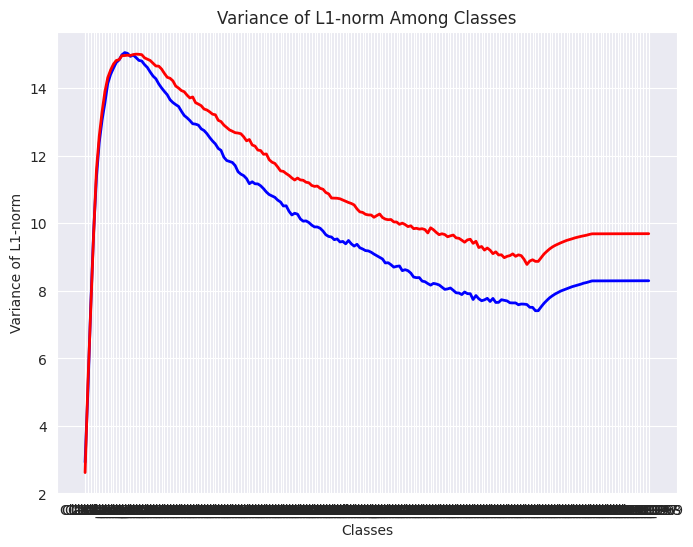

In [41]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list2)), variance_list2, color='red', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()